In [135]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [136]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [137]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [138]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [139]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [140]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [141]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [142]:
# %%timeit
if 'EPA' not in pbp_data.columns:
    pbp_data["EPA"] = pbp_data.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)

In [143]:
pbp_data.head()

,index,id,offense,defense,home,away,offense_score,defense_score,drive_id,period,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EPA
1,1,322430009007,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Northern Arizona,Arizona State,Northern Arizona,6,0,32243000901,1,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [144]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [186]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'AvgEPA', 'IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EPA.mean()

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_epa = team_off_plays.EPA.mean()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEPA" : [avg_epa]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEPADiff, pbp_data.EPA.min()-pbp_data.EPA.max(), pbp_data.EPA.max()-pbp_data.EPA.min(), 0, 10)
    #return translate(team_stat_pack.IsoPPPDiff, pbp_data.EPA.min(), pbp_data.EPA.max(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 4.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 5.5)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,5) + translate(team_stat_pack.OppSRDiff, -1,1,0,5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.05 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EPA' not in game_pbp.columns:
        game_pbp['EPA'] = game_pbp.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,1.791667,-0.052381,0.118588,0.994779,-0.66,0.103211,0.124959,-0.040309,4.740123,-0.019753
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.103211,-0.124959,0.040309,4.759877,0.019753


In [187]:
# %%timeit
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/6644] Getting game information for ESPN game_id: 322432309
[1/6644] Started processing game information for ESPN game_id: 322432309
[1/6644] Skipping checking game_id 322432309 bc one of the teams isn't FBS
[2/6644] Getting game information for ESPN game_id: 322432006
[2/6644] Started processing game information for ESPN game_id: 322432006
[2/6644] Completed processing game information for ESPN game_id: 322432006
[2/6644] Aggreggating game_id 322432006 to master data copy
[3/6644] Getting game information for ESPN game_id: 322430238
[3/6644] Started processing game information for ESPN game_id: 322430238
[3/6644] Completed processing game information for ESPN game_id: 322430238
[3/6644] Aggreggating game_id 322430238 to master data copy
[4/6644] Getting game information for ESPN game_id: 322432117
[4/6644] Started processing game information for ESPN game_id: 322432117
[4/6644] Skipping checking game_id 322432117 bc one of the teams isn't FBS
[5/6644] Getting game information for ES

[35/6644] Completed processing game information for ESPN game_id: 322450025
[35/6644] Aggreggating game_id 322450025 to master data copy
[36/6644] Getting game information for ESPN game_id: 322450103
[36/6644] Started processing game information for ESPN game_id: 322450103
[36/6644] Completed processing game information for ESPN game_id: 322450103
[36/6644] Aggreggating game_id 322450103 to master data copy
[37/6644] Getting game information for ESPN game_id: 322450275
[37/6644] Started processing game information for ESPN game_id: 322450275
[37/6644] Skipping checking game_id 322450275 bc one of the teams isn't FBS
[38/6644] Getting game information for ESPN game_id: 322452509
[38/6644] Started processing game information for ESPN game_id: 322452509
[38/6644] Skipping checking game_id 322452509 bc one of the teams isn't FBS
[39/6644] Getting game information for ESPN game_id: 322450158
[39/6644] Started processing game information for ESPN game_id: 322450158
[39/6644] Completed proces

[71/6644] Completed processing game information for ESPN game_id: 322452638
[71/6644] Aggreggating game_id 322452638 to master data copy
[72/6644] Getting game information for ESPN game_id: 322450264
[72/6644] Started processing game information for ESPN game_id: 322450264
[72/6644] Completed processing game information for ESPN game_id: 322450264
[72/6644] Aggreggating game_id 322450264 to master data copy
[73/6644] Getting game information for ESPN game_id: 322450012
[73/6644] Started processing game information for ESPN game_id: 322450012
[73/6644] Completed processing game information for ESPN game_id: 322450012
[73/6644] Aggreggating game_id 322450012 to master data copy
[74/6644] Getting game information for ESPN game_id: 322460097
[74/6644] Started processing game information for ESPN game_id: 322460097
[74/6644] Completed processing game information for ESPN game_id: 322460097
[74/6644] Aggreggating game_id 322460097 to master data copy
[75/6644] Getting game information for ES

[105/6644] Completed processing game information for ESPN game_id: 322520113
[105/6644] Aggreggating game_id 322520113 to master data copy
[106/6644] Getting game information for ESPN game_id: 322520130
[106/6644] Started processing game information for ESPN game_id: 322520130
[106/6644] Completed processing game information for ESPN game_id: 322520130
[106/6644] Aggreggating game_id 322520130 to master data copy
[107/6644] Getting game information for ESPN game_id: 322522305
[107/6644] Started processing game information for ESPN game_id: 322522305
[107/6644] Completed processing game information for ESPN game_id: 322522305
[107/6644] Aggreggating game_id 322522305 to master data copy
[108/6644] Getting game information for ESPN game_id: 322522294
[108/6644] Started processing game information for ESPN game_id: 322522294
[108/6644] Completed processing game information for ESPN game_id: 322522294
[108/6644] Aggreggating game_id 322522294 to master data copy
[109/6644] Getting game inf

[139/6644] Completed processing game information for ESPN game_id: 322520026
[139/6644] Aggreggating game_id 322520026 to master data copy
[140/6644] Getting game information for ESPN game_id: 322520251
[140/6644] Started processing game information for ESPN game_id: 322520251
[140/6644] Completed processing game information for ESPN game_id: 322520251
[140/6644] Aggreggating game_id 322520251 to master data copy
[141/6644] Getting game information for ESPN game_id: 322520023
[141/6644] Started processing game information for ESPN game_id: 322520023
[141/6644] Skipping checking game_id 322520023 bc one of the teams isn't FBS
[142/6644] Getting game information for ESPN game_id: 322520077
[142/6644] Started processing game information for ESPN game_id: 322520077
[142/6644] Completed processing game information for ESPN game_id: 322520077
[142/6644] Aggreggating game_id 322520077 to master data copy
[143/6644] Getting game information for ESPN game_id: 322520248
[143/6644] Started proces

Could not find drive data for game_id 322592572 on CFB Data API, bailing out
[172/6644] Got 'None' for game_id 322592572's box score, skipping processing
[173/6644] Getting game information for ESPN game_id: 322590059
[173/6644] Started processing game information for ESPN game_id: 322590059
[173/6644] Completed processing game information for ESPN game_id: 322590059
[173/6644] Aggreggating game_id 322590059 to master data copy
[174/6644] Getting game information for ESPN game_id: 322590077
[174/6644] Started processing game information for ESPN game_id: 322590077
[174/6644] Completed processing game information for ESPN game_id: 322590077
[174/6644] Aggreggating game_id 322590077 to master data copy
[175/6644] Getting game information for ESPN game_id: 322592567
[175/6644] Started processing game information for ESPN game_id: 322592567
[175/6644] Completed processing game information for ESPN game_id: 322592567
[175/6644] Aggreggating game_id 322592567 to master data copy
[176/6644] G

[206/6644] Completed processing game information for ESPN game_id: 322590023
[206/6644] Aggreggating game_id 322590023 to master data copy
[207/6644] Getting game information for ESPN game_id: 322590066
[207/6644] Started processing game information for ESPN game_id: 322590066
[207/6644] Skipping checking game_id 322590066 bc one of the teams isn't FBS
[208/6644] Getting game information for ESPN game_id: 322590084
[208/6644] Started processing game information for ESPN game_id: 322590084
[208/6644] Completed processing game information for ESPN game_id: 322590084
[208/6644] Aggreggating game_id 322590084 to master data copy
[209/6644] Getting game information for ESPN game_id: 322590278
[209/6644] Started processing game information for ESPN game_id: 322590278
[209/6644] Completed processing game information for ESPN game_id: 322590278
[209/6644] Aggreggating game_id 322590278 to master data copy
[210/6644] Getting game information for ESPN game_id: 322590275
[210/6644] Started proces

[236/6644] Completed processing game information for ESPN game_id: 322660026
[236/6644] Aggreggating game_id 322660026 to master data copy
[237/6644] Getting game information for ESPN game_id: 322660127
[237/6644] Started processing game information for ESPN game_id: 322660127
[237/6644] Completed processing game information for ESPN game_id: 322660127
[237/6644] Aggreggating game_id 322660127 to master data copy
[238/6644] Getting game information for ESPN game_id: 322660158
[238/6644] Started processing game information for ESPN game_id: 322660158
[238/6644] Skipping checking game_id 322660158 bc one of the teams isn't FBS
[239/6644] Getting game information for ESPN game_id: 322660077
[239/6644] Started processing game information for ESPN game_id: 322660077
[239/6644] Skipping checking game_id 322660077 bc one of the teams isn't FBS
[240/6644] Getting game information for ESPN game_id: 322660221
[240/6644] Started processing game information for ESPN game_id: 322660221
[240/6644] S

[269/6644] Completed processing game information for ESPN game_id: 322660135
[269/6644] Aggreggating game_id 322660135 to master data copy
[270/6644] Getting game information for ESPN game_id: 322660021
[270/6644] Started processing game information for ESPN game_id: 322660021
[270/6644] Completed processing game information for ESPN game_id: 322660021
[270/6644] Aggreggating game_id 322660021 to master data copy
[271/6644] Getting game information for ESPN game_id: 322660202
[271/6644] Started processing game information for ESPN game_id: 322660202
[271/6644] Completed processing game information for ESPN game_id: 322660202
[271/6644] Aggreggating game_id 322660202 to master data copy
[272/6644] Getting game information for ESPN game_id: 322660166
[272/6644] Started processing game information for ESPN game_id: 322660166
[272/6644] Completed processing game information for ESPN game_id: 322660166
[272/6644] Aggreggating game_id 322660166 to master data copy
[273/6644] Getting game inf

Could not find drive data for game_id 322732655 on CFB Data API, bailing out
[301/6644] Got 'None' for game_id 322732655's box score, skipping processing
[302/6644] Getting game information for ESPN game_id: 322732459
[302/6644] Started processing game information for ESPN game_id: 322732459
Could not find drive data for game_id 322732459 locally, checking CFB Data API
Could not find drive data for game_id 322732459 on CFB Data API, bailing out
[302/6644] Got 'None' for game_id 322732459's box score, skipping processing
[303/6644] Getting game information for ESPN game_id: 322732426
[303/6644] Started processing game information for ESPN game_id: 322732426
[303/6644] Completed processing game information for ESPN game_id: 322732426
[303/6644] Aggreggating game_id 322732426 to master data copy
[304/6644] Getting game information for ESPN game_id: 322730153
[304/6644] Started processing game information for ESPN game_id: 322730153
[304/6644] Skipping checking game_id 322730153 bc one of 

[331/6644] Completed processing game information for ESPN game_id: 322782229
[331/6644] Aggreggating game_id 322782229 to master data copy
[332/6644] Getting game information for ESPN game_id: 322782116
[332/6644] Started processing game information for ESPN game_id: 322782116
[332/6644] Completed processing game information for ESPN game_id: 322782116
[332/6644] Aggreggating game_id 322782116 to master data copy
[333/6644] Getting game information for ESPN game_id: 322780254
[333/6644] Started processing game information for ESPN game_id: 322780254
[333/6644] Completed processing game information for ESPN game_id: 322780254
[333/6644] Aggreggating game_id 322780254 to master data copy
[334/6644] Getting game information for ESPN game_id: 322790183
[334/6644] Started processing game information for ESPN game_id: 322790183
[334/6644] Completed processing game information for ESPN game_id: 322790183
[334/6644] Aggreggating game_id 322790183 to master data copy
[335/6644] Getting game inf

[362/6644] Completed processing game information for ESPN game_id: 322802641
[362/6644] Aggreggating game_id 322802641 to master data copy
[363/6644] Getting game information for ESPN game_id: 322800276
[363/6644] Started processing game information for ESPN game_id: 322800276
[363/6644] Completed processing game information for ESPN game_id: 322800276
[363/6644] Aggreggating game_id 322800276 to master data copy
[364/6644] Getting game information for ESPN game_id: 322802509
[364/6644] Started processing game information for ESPN game_id: 322802509
[364/6644] Completed processing game information for ESPN game_id: 322802509
[364/6644] Aggreggating game_id 322802509 to master data copy
[365/6644] Getting game information for ESPN game_id: 322800070
[365/6644] Started processing game information for ESPN game_id: 322800070
[365/6644] Skipping checking game_id 322800070 bc one of the teams isn't FBS
[366/6644] Getting game information for ESPN game_id: 322800309
[366/6644] Started proces

[393/6644] Completed processing game information for ESPN game_id: 322870066
[393/6644] Aggreggating game_id 322870066 to master data copy
[394/6644] Getting game information for ESPN game_id: 322870201
[394/6644] Started processing game information for ESPN game_id: 322870201
[394/6644] Completed processing game information for ESPN game_id: 322870201
[394/6644] Aggreggating game_id 322870201 to master data copy
[395/6644] Getting game information for ESPN game_id: 322870127
[395/6644] Started processing game information for ESPN game_id: 322870127
[395/6644] Completed processing game information for ESPN game_id: 322870127
[395/6644] Aggreggating game_id 322870127 to master data copy
[396/6644] Getting game information for ESPN game_id: 322872509
[396/6644] Started processing game information for ESPN game_id: 322872509
[396/6644] Completed processing game information for ESPN game_id: 322872509
[396/6644] Aggreggating game_id 322872509 to master data copy
[397/6644] Getting game inf

[422/6644] Completed processing game information for ESPN game_id: 322870052
[422/6644] Aggreggating game_id 322870052 to master data copy
[423/6644] Getting game information for ESPN game_id: 322870238
[423/6644] Started processing game information for ESPN game_id: 322870238
[423/6644] Completed processing game information for ESPN game_id: 322870238
[423/6644] Aggreggating game_id 322870238 to master data copy
[424/6644] Getting game information for ESPN game_id: 322872229
[424/6644] Started processing game information for ESPN game_id: 322872229
[424/6644] Completed processing game information for ESPN game_id: 322872229
[424/6644] Aggreggating game_id 322872229 to master data copy
[425/6644] Getting game information for ESPN game_id: 322870021
[425/6644] Started processing game information for ESPN game_id: 322870021
[425/6644] Completed processing game information for ESPN game_id: 322870021
[425/6644] Aggreggating game_id 322870021 to master data copy
[426/6644] Getting game inf

[452/6644] Completed processing game information for ESPN game_id: 322940228
[452/6644] Aggreggating game_id 322940228 to master data copy
[453/6644] Getting game information for ESPN game_id: 322940238
[453/6644] Started processing game information for ESPN game_id: 322940238
[453/6644] Completed processing game information for ESPN game_id: 322940238
[453/6644] Aggreggating game_id 322940238 to master data copy
[454/6644] Getting game information for ESPN game_id: 322940258
[454/6644] Started processing game information for ESPN game_id: 322940258
[454/6644] Completed processing game information for ESPN game_id: 322940258
[454/6644] Aggreggating game_id 322940258 to master data copy
[455/6644] Getting game information for ESPN game_id: 322942199
[455/6644] Started processing game information for ESPN game_id: 322942199
[455/6644] Completed processing game information for ESPN game_id: 322942199
[455/6644] Aggreggating game_id 322942199 to master data copy
[456/6644] Getting game inf

[482/6644] Completed processing game information for ESPN game_id: 322942649
[482/6644] Aggreggating game_id 322942649 to master data copy
[483/6644] Getting game information for ESPN game_id: 322940344
[483/6644] Started processing game information for ESPN game_id: 322940344
[483/6644] Completed processing game information for ESPN game_id: 322940344
[483/6644] Aggreggating game_id 322940344 to master data copy
[484/6644] Getting game information for ESPN game_id: 322940096
[484/6644] Started processing game information for ESPN game_id: 322940096
[484/6644] Completed processing game information for ESPN game_id: 322940096
[484/6644] Aggreggating game_id 322940096 to master data copy
[485/6644] Getting game information for ESPN game_id: 322940005
[485/6644] Started processing game information for ESPN game_id: 322940005
[485/6644] Completed processing game information for ESPN game_id: 322940005
[485/6644] Aggreggating game_id 322940005 to master data copy
[486/6644] Getting game inf

[512/6644] Completed processing game information for ESPN game_id: 323010103
[512/6644] Aggreggating game_id 323010103 to master data copy
[513/6644] Getting game information for ESPN game_id: 323012636
[513/6644] Started processing game information for ESPN game_id: 323012636
[513/6644] Completed processing game information for ESPN game_id: 323012636
[513/6644] Aggreggating game_id 323012636 to master data copy
[514/6644] Getting game information for ESPN game_id: 323010009
[514/6644] Started processing game information for ESPN game_id: 323010009
[514/6644] Completed processing game information for ESPN game_id: 323010009
[514/6644] Aggreggating game_id 323010009 to master data copy
[515/6644] Getting game information for ESPN game_id: 323012567
[515/6644] Started processing game information for ESPN game_id: 323012567
[515/6644] Completed processing game information for ESPN game_id: 323012567
[515/6644] Aggreggating game_id 323012567 to master data copy
[516/6644] Getting game inf

[542/6644] Completed processing game information for ESPN game_id: 323010238
[542/6644] Aggreggating game_id 323010238 to master data copy
[543/6644] Getting game information for ESPN game_id: 323010036
[543/6644] Started processing game information for ESPN game_id: 323010036
[543/6644] Completed processing game information for ESPN game_id: 323010036
[543/6644] Aggreggating game_id 323010036 to master data copy
[544/6644] Getting game information for ESPN game_id: 323010066
[544/6644] Started processing game information for ESPN game_id: 323010066
[544/6644] Completed processing game information for ESPN game_id: 323010066
[544/6644] Aggreggating game_id 323010066 to master data copy
[545/6644] Getting game information for ESPN game_id: 323010058
[545/6644] Started processing game information for ESPN game_id: 323010058
[545/6644] Completed processing game information for ESPN game_id: 323010058
[545/6644] Aggreggating game_id 323010058 to master data copy
[546/6644] Getting game inf

[572/6644] Completed processing game information for ESPN game_id: 323080152
[572/6644] Aggreggating game_id 323080152 to master data copy
[573/6644] Getting game information for ESPN game_id: 323080002
[573/6644] Started processing game information for ESPN game_id: 323080002
[573/6644] Completed processing game information for ESPN game_id: 323080002
[573/6644] Aggreggating game_id 323080002 to master data copy
[574/6644] Getting game information for ESPN game_id: 323082117
[574/6644] Started processing game information for ESPN game_id: 323082117
[574/6644] Completed processing game information for ESPN game_id: 323082117
[574/6644] Aggreggating game_id 323082117 to master data copy
[575/6644] Getting game information for ESPN game_id: 323080038
[575/6644] Started processing game information for ESPN game_id: 323080038
[575/6644] Completed processing game information for ESPN game_id: 323080038
[575/6644] Aggreggating game_id 323080038 to master data copy
[576/6644] Getting game inf

[602/6644] Aggreggating game_id 323080278 to master data copy
[603/6644] Getting game information for ESPN game_id: 323080150
[603/6644] Started processing game information for ESPN game_id: 323080150
[603/6644] Completed processing game information for ESPN game_id: 323080150
[603/6644] Aggreggating game_id 323080150 to master data copy
[604/6644] Getting game information for ESPN game_id: 323080030
[604/6644] Started processing game information for ESPN game_id: 323080030
[604/6644] Completed processing game information for ESPN game_id: 323080030
[604/6644] Aggreggating game_id 323080030 to master data copy
[605/6644] Getting game information for ESPN game_id: 323082572
[605/6644] Started processing game information for ESPN game_id: 323082572
[605/6644] Completed processing game information for ESPN game_id: 323082572
[605/6644] Aggreggating game_id 323082572 to master data copy
[606/6644] Getting game information for ESPN game_id: 323082306
[606/6644] Started processing game infor

[632/6644] Completed processing game information for ESPN game_id: 323150012
[632/6644] Aggreggating game_id 323150012 to master data copy
[633/6644] Getting game information for ESPN game_id: 323152006
[633/6644] Started processing game information for ESPN game_id: 323152006
Could not find drive data for game_id 323152006 locally, checking CFB Data API
Could not find drive data for game_id 323152006 on CFB Data API, bailing out
[633/6644] Got 'None' for game_id 323152006's box score, skipping processing
[634/6644] Getting game information for ESPN game_id: 323150152
[634/6644] Started processing game information for ESPN game_id: 323150152
[634/6644] Completed processing game information for ESPN game_id: 323150152
[634/6644] Aggreggating game_id 323150152 to master data copy
[635/6644] Getting game information for ESPN game_id: 323150030
[635/6644] Started processing game information for ESPN game_id: 323150030
[635/6644] Completed processing game information for ESPN game_id: 32315

[662/6644] Completed processing game information for ESPN game_id: 323150103
[662/6644] Aggreggating game_id 323150103 to master data copy
[663/6644] Getting game information for ESPN game_id: 323150252
[663/6644] Started processing game information for ESPN game_id: 323150252
[663/6644] Skipping checking game_id 323150252 bc one of the teams isn't FBS
[664/6644] Getting game information for ESPN game_id: 323150264
[664/6644] Started processing game information for ESPN game_id: 323150264
[664/6644] Completed processing game information for ESPN game_id: 323150264
[664/6644] Aggreggating game_id 323150264 to master data copy
[665/6644] Getting game information for ESPN game_id: 323150025
[665/6644] Started processing game information for ESPN game_id: 323150025
[665/6644] Completed processing game information for ESPN game_id: 323150025
[665/6644] Aggreggating game_id 323150025 to master data copy
[666/6644] Getting game information for ESPN game_id: 323150265
[666/6644] Started proces

[693/6644] Completed processing game information for ESPN game_id: 323220005
[693/6644] Aggreggating game_id 323220005 to master data copy
[694/6644] Getting game information for ESPN game_id: 323220009
[694/6644] Started processing game information for ESPN game_id: 323220009
[694/6644] Completed processing game information for ESPN game_id: 323220009
[694/6644] Aggreggating game_id 323220009 to master data copy
[695/6644] Getting game information for ESPN game_id: 323222390
[695/6644] Started processing game information for ESPN game_id: 323222390
[695/6644] Completed processing game information for ESPN game_id: 323222390
[695/6644] Aggreggating game_id 323222390 to master data copy
[696/6644] Getting game information for ESPN game_id: 323220113
[696/6644] Started processing game information for ESPN game_id: 323220113
Could not find drive data for game_id 323220113 locally, checking CFB Data API
Could not find drive data for game_id 323220113 on CFB Data API, bailing out
[696/6644]

[724/6644] Completed processing game information for ESPN game_id: 323222572
[724/6644] Aggreggating game_id 323222572 to master data copy
[725/6644] Getting game information for ESPN game_id: 323220239
[725/6644] Started processing game information for ESPN game_id: 323220239
[725/6644] Completed processing game information for ESPN game_id: 323220239
[725/6644] Aggreggating game_id 323220239 to master data copy
[726/6644] Getting game information for ESPN game_id: 323222483
[726/6644] Started processing game information for ESPN game_id: 323222483
[726/6644] Completed processing game information for ESPN game_id: 323222483
[726/6644] Aggreggating game_id 323222483 to master data copy
[727/6644] Getting game information for ESPN game_id: 323220254
[727/6644] Started processing game information for ESPN game_id: 323220254
[727/6644] Completed processing game information for ESPN game_id: 323220254
[727/6644] Aggreggating game_id 323220254 to master data copy
[728/6644] Getting game inf

[754/6644] Completed processing game information for ESPN game_id: 323290077
[754/6644] Aggreggating game_id 323290077 to master data copy
[755/6644] Getting game information for ESPN game_id: 323292633
[755/6644] Started processing game information for ESPN game_id: 323292633
[755/6644] Completed processing game information for ESPN game_id: 323292633
[755/6644] Aggreggating game_id 323292633 to master data copy
[756/6644] Getting game information for ESPN game_id: 323290150
[756/6644] Started processing game information for ESPN game_id: 323290150
[756/6644] Completed processing game information for ESPN game_id: 323290150
[756/6644] Aggreggating game_id 323290150 to master data copy
[757/6644] Getting game information for ESPN game_id: 323290098
[757/6644] Started processing game information for ESPN game_id: 323290098
[757/6644] Completed processing game information for ESPN game_id: 323290098
[757/6644] Aggreggating game_id 323290098 to master data copy
[758/6644] Getting game inf

[784/6644] Completed processing game information for ESPN game_id: 323290030
[784/6644] Aggreggating game_id 323290030 to master data copy
[785/6644] Getting game information for ESPN game_id: 323290023
[785/6644] Started processing game information for ESPN game_id: 323290023
[785/6644] Completed processing game information for ESPN game_id: 323290023
[785/6644] Aggreggating game_id 323290023 to master data copy
[786/6644] Getting game information for ESPN game_id: 323290062
[786/6644] Started processing game information for ESPN game_id: 323290062
[786/6644] Completed processing game information for ESPN game_id: 323290062
[786/6644] Aggreggating game_id 323290062 to master data copy
[787/6644] Getting game information for ESPN game_id: 323340164
[787/6644] Started processing game information for ESPN game_id: 323340164
[787/6644] Completed processing game information for ESPN game_id: 323340164
[787/6644] Aggreggating game_id 323340164 to master data copy
[788/6644] Getting game inf

[819/6644] Completed processing game information for ESPN game_id: 332410254
[819/6644] Aggreggating game_id 332410254 to master data copy
[820/6644] Getting game information for ESPN game_id: 332410238
[820/6644] Started processing game information for ESPN game_id: 332410238
[820/6644] Completed processing game information for ESPN game_id: 332410238
[820/6644] Aggreggating game_id 332410238 to master data copy
[821/6644] Getting game information for ESPN game_id: 332410023
[821/6644] Started processing game information for ESPN game_id: 332410023
[821/6644] Skipping checking game_id 332410023 bc one of the teams isn't FBS
[822/6644] Getting game information for ESPN game_id: 332410278
[822/6644] Started processing game information for ESPN game_id: 332410278
[822/6644] Completed processing game information for ESPN game_id: 332410278
[822/6644] Aggreggating game_id 332410278 to master data copy
[823/6644] Getting game information for ESPN game_id: 332410062
[823/6644] Started proces

[852/6644] Completed processing game information for ESPN game_id: 332430008
[852/6644] Aggreggating game_id 332430008 to master data copy
[853/6644] Getting game information for ESPN game_id: 332430259
[853/6644] Started processing game information for ESPN game_id: 332430259
[853/6644] Completed processing game information for ESPN game_id: 332430259
[853/6644] Aggreggating game_id 332430259 to master data copy
[854/6644] Getting game information for ESPN game_id: 332432199
[854/6644] Started processing game information for ESPN game_id: 332432199
[854/6644] Skipping checking game_id 332432199 bc one of the teams isn't FBS
[855/6644] Getting game information for ESPN game_id: 332430204
[855/6644] Started processing game information for ESPN game_id: 332430204
[855/6644] Skipping checking game_id 332430204 bc one of the teams isn't FBS
[856/6644] Getting game information for ESPN game_id: 332432633
[856/6644] Started processing game information for ESPN game_id: 332432633
[856/6644] S

[884/6644] Completed processing game information for ESPN game_id: 332490103
[884/6644] Aggreggating game_id 332490103 to master data copy
[885/6644] Getting game information for ESPN game_id: 332492229
[885/6644] Started processing game information for ESPN game_id: 332492229
[885/6644] Completed processing game information for ESPN game_id: 332492229
[885/6644] Aggreggating game_id 332492229 to master data copy
[886/6644] Getting game information for ESPN game_id: 332502294
[886/6644] Started processing game information for ESPN game_id: 332502294
[886/6644] Skipping checking game_id 332502294 bc one of the teams isn't FBS
[887/6644] Getting game information for ESPN game_id: 332502309
[887/6644] Started processing game information for ESPN game_id: 332502309
[887/6644] Completed processing game information for ESPN game_id: 332502309
[887/6644] Aggreggating game_id 332502309 to master data copy
[888/6644] Getting game information for ESPN game_id: 332502509
[888/6644] Started proces

[917/6644] Completed processing game information for ESPN game_id: 332500120
[917/6644] Aggreggating game_id 332500120 to master data copy
[918/6644] Getting game information for ESPN game_id: 332502751
[918/6644] Started processing game information for ESPN game_id: 332502751
[918/6644] Skipping checking game_id 332502751 bc one of the teams isn't FBS
[919/6644] Getting game information for ESPN game_id: 332500061
[919/6644] Started processing game information for ESPN game_id: 332500061
[919/6644] Completed processing game information for ESPN game_id: 332500061
[919/6644] Aggreggating game_id 332500061 to master data copy
[920/6644] Getting game information for ESPN game_id: 332500235
[920/6644] Started processing game information for ESPN game_id: 332500235
[920/6644] Completed processing game information for ESPN game_id: 332500235
[920/6644] Aggreggating game_id 332500235 to master data copy
[921/6644] Getting game information for ESPN game_id: 332500025
[921/6644] Started proces

[954/6644] Completed processing game information for ESPN game_id: 332500030
[954/6644] Aggreggating game_id 332500030 to master data copy
[955/6644] Getting game information for ESPN game_id: 332502439
[955/6644] Started processing game information for ESPN game_id: 332502439
[955/6644] Completed processing game information for ESPN game_id: 332502439
[955/6644] Aggreggating game_id 332502439 to master data copy
[956/6644] Getting game information for ESPN game_id: 332500024
[956/6644] Started processing game information for ESPN game_id: 332500024
[956/6644] Completed processing game information for ESPN game_id: 332500024
[956/6644] Aggreggating game_id 332500024 to master data copy
[957/6644] Getting game information for ESPN game_id: 332552032
[957/6644] Started processing game information for ESPN game_id: 332552032
[957/6644] Completed processing game information for ESPN game_id: 332552032
[957/6644] Aggreggating game_id 332552032 to master data copy
[958/6644] Getting game inf

[986/6644] Completed processing game information for ESPN game_id: 332570249
[986/6644] Aggreggating game_id 332570249 to master data copy
[987/6644] Getting game information for ESPN game_id: 332570070
[987/6644] Started processing game information for ESPN game_id: 332570070
[987/6644] Skipping checking game_id 332570070 bc one of the teams isn't FBS
[988/6644] Getting game information for ESPN game_id: 332570213
[988/6644] Started processing game information for ESPN game_id: 332570213
[988/6644] Completed processing game information for ESPN game_id: 332570213
[988/6644] Aggreggating game_id 332570213 to master data copy
[989/6644] Getting game information for ESPN game_id: 332570295
[989/6644] Started processing game information for ESPN game_id: 332570295
[989/6644] Skipping checking game_id 332570295 bc one of the teams isn't FBS
[990/6644] Getting game information for ESPN game_id: 332570066
[990/6644] Started processing game information for ESPN game_id: 332570066
[990/6644] C

[1018/6644] Completed processing game information for ESPN game_id: 332620152
[1018/6644] Aggreggating game_id 332620152 to master data copy
[1019/6644] Getting game information for ESPN game_id: 332630278
[1019/6644] Started processing game information for ESPN game_id: 332630278
[1019/6644] Completed processing game information for ESPN game_id: 332630278
[1019/6644] Aggreggating game_id 332630278 to master data copy
[1020/6644] Getting game information for ESPN game_id: 332640349
[1020/6644] Started processing game information for ESPN game_id: 332640349
[1020/6644] Completed processing game information for ESPN game_id: 332640349
[1020/6644] Aggreggating game_id 332640349 to master data copy
[1021/6644] Getting game information for ESPN game_id: 332642226
[1021/6644] Started processing game information for ESPN game_id: 332642226
[1021/6644] Completed processing game information for ESPN game_id: 332642226
[1021/6644] Aggreggating game_id 332642226 to master data copy
[1022/6644] G

[1050/6644] Completed processing game information for ESPN game_id: 332640030
[1050/6644] Aggreggating game_id 332640030 to master data copy
[1051/6644] Getting game information for ESPN game_id: 332640239
[1051/6644] Started processing game information for ESPN game_id: 332640239
[1051/6644] Completed processing game information for ESPN game_id: 332640239
[1051/6644] Aggreggating game_id 332640239 to master data copy
[1052/6644] Getting game information for ESPN game_id: 332640193
[1052/6644] Started processing game information for ESPN game_id: 332640193
[1052/6644] Completed processing game information for ESPN game_id: 332640193
[1052/6644] Aggreggating game_id 332640193 to master data copy
[1053/6644] Getting game information for ESPN game_id: 332640235
[1053/6644] Started processing game information for ESPN game_id: 332640235
[1053/6644] Completed processing game information for ESPN game_id: 332640235
[1053/6644] Aggreggating game_id 332640235 to master data copy
[1054/6644] G

[1081/6644] Completed processing game information for ESPN game_id: 332712116
[1081/6644] Aggreggating game_id 332712116 to master data copy
[1082/6644] Getting game information for ESPN game_id: 332710277
[1082/6644] Started processing game information for ESPN game_id: 332710277
[1082/6644] Completed processing game information for ESPN game_id: 332710277
[1082/6644] Aggreggating game_id 332710277 to master data copy
[1083/6644] Getting game information for ESPN game_id: 332710058
[1083/6644] Started processing game information for ESPN game_id: 332710058
[1083/6644] Completed processing game information for ESPN game_id: 332710058
[1083/6644] Aggreggating game_id 332710058 to master data copy
[1084/6644] Getting game information for ESPN game_id: 332712509
[1084/6644] Started processing game information for ESPN game_id: 332712509
[1084/6644] Completed processing game information for ESPN game_id: 332712509
[1084/6644] Aggreggating game_id 332712509 to master data copy
[1085/6644] G

[1111/6644] Completed processing game information for ESPN game_id: 332710096
[1111/6644] Aggreggating game_id 332710096 to master data copy
[1112/6644] Getting game information for ESPN game_id: 332712711
[1112/6644] Started processing game information for ESPN game_id: 332712711
[1112/6644] Completed processing game information for ESPN game_id: 332712711
[1112/6644] Aggreggating game_id 332712711 to master data copy
[1113/6644] Getting game information for ESPN game_id: 332710326
[1113/6644] Started processing game information for ESPN game_id: 332710326
[1113/6644] Completed processing game information for ESPN game_id: 332710326
[1113/6644] Aggreggating game_id 332710326 to master data copy
[1114/6644] Getting game information for ESPN game_id: 332712433
[1114/6644] Started processing game information for ESPN game_id: 332712433
[1114/6644] Completed processing game information for ESPN game_id: 332712433
[1114/6644] Aggreggating game_id 332712433 to master data copy
[1115/6644] G

[1141/6644] Completed processing game information for ESPN game_id: 332780333
[1141/6644] Aggreggating game_id 332780333 to master data copy
[1142/6644] Getting game information for ESPN game_id: 332780259
[1142/6644] Started processing game information for ESPN game_id: 332780259
[1142/6644] Completed processing game information for ESPN game_id: 332780259
[1142/6644] Aggreggating game_id 332780259 to master data copy
[1143/6644] Getting game information for ESPN game_id: 332782653
[1143/6644] Started processing game information for ESPN game_id: 332782653
[1143/6644] Completed processing game information for ESPN game_id: 332782653
[1143/6644] Aggreggating game_id 332782653 to master data copy
[1144/6644] Getting game information for ESPN game_id: 332780193
[1144/6644] Started processing game information for ESPN game_id: 332780193
[1144/6644] Completed processing game information for ESPN game_id: 332780193
[1144/6644] Aggreggating game_id 332780193 to master data copy
[1145/6644] G

[1171/6644] Completed processing game information for ESPN game_id: 332780309
[1171/6644] Aggreggating game_id 332780309 to master data copy
[1172/6644] Getting game information for ESPN game_id: 332780167
[1172/6644] Started processing game information for ESPN game_id: 332780167
[1172/6644] Completed processing game information for ESPN game_id: 332780167
[1172/6644] Aggreggating game_id 332780167 to master data copy
[1173/6644] Getting game information for ESPN game_id: 332780057
[1173/6644] Started processing game information for ESPN game_id: 332780057
[1173/6644] Completed processing game information for ESPN game_id: 332780057
[1173/6644] Aggreggating game_id 332780057 to master data copy
[1174/6644] Getting game information for ESPN game_id: 332780238
[1174/6644] Started processing game information for ESPN game_id: 332780238
[1174/6644] Completed processing game information for ESPN game_id: 332780238
[1174/6644] Aggreggating game_id 332780238 to master data copy
[1175/6644] G

[1202/6644] Completed processing game information for ESPN game_id: 332852050
[1202/6644] Aggreggating game_id 332852050 to master data copy
[1203/6644] Getting game information for ESPN game_id: 332850099
[1203/6644] Started processing game information for ESPN game_id: 332850099
[1203/6644] Completed processing game information for ESPN game_id: 332850099
[1203/6644] Aggreggating game_id 332850099 to master data copy
[1204/6644] Getting game information for ESPN game_id: 332850228
[1204/6644] Started processing game information for ESPN game_id: 332850228
[1204/6644] Completed processing game information for ESPN game_id: 332850228
[1204/6644] Aggreggating game_id 332850228 to master data copy
[1205/6644] Getting game information for ESPN game_id: 332852306
[1205/6644] Started processing game information for ESPN game_id: 332852306
[1205/6644] Completed processing game information for ESPN game_id: 332852306
[1205/6644] Aggreggating game_id 332852306 to master data copy
[1206/6644] G

[1233/6644] Completed processing game information for ESPN game_id: 332880098
[1233/6644] Aggreggating game_id 332880098 to master data copy
[1234/6644] Getting game information for ESPN game_id: 332900153
[1234/6644] Started processing game information for ESPN game_id: 332900153
[1234/6644] Completed processing game information for ESPN game_id: 332900153
[1234/6644] Aggreggating game_id 332900153 to master data copy
[1235/6644] Getting game information for ESPN game_id: 332910097
[1235/6644] Started processing game information for ESPN game_id: 332910097
[1235/6644] Completed processing game information for ESPN game_id: 332910097
[1235/6644] Aggreggating game_id 332910097 to master data copy
[1236/6644] Getting game information for ESPN game_id: 332922649
[1236/6644] Started processing game information for ESPN game_id: 332922649
[1236/6644] Completed processing game information for ESPN game_id: 332922649
[1236/6644] Aggreggating game_id 332922649 to master data copy
[1237/6644] G

[1264/6644] Completed processing game information for ESPN game_id: 332920130
[1264/6644] Aggreggating game_id 332920130 to master data copy
[1265/6644] Getting game information for ESPN game_id: 332920024
[1265/6644] Started processing game information for ESPN game_id: 332920024
[1265/6644] Completed processing game information for ESPN game_id: 332920024
[1265/6644] Aggreggating game_id 332920024 to master data copy
[1266/6644] Getting game information for ESPN game_id: 332920009
[1266/6644] Started processing game information for ESPN game_id: 332920009
[1266/6644] Completed processing game information for ESPN game_id: 332920009
[1266/6644] Aggreggating game_id 332920009 to master data copy
[1267/6644] Getting game information for ESPN game_id: 332920221
[1267/6644] Started processing game information for ESPN game_id: 332920221
[1267/6644] Completed processing game information for ESPN game_id: 332920221
[1267/6644] Aggreggating game_id 332920221 to master data copy
[1268/6644] G

[1295/6644] Completed processing game information for ESPN game_id: 332990258
[1295/6644] Aggreggating game_id 332990258 to master data copy
[1296/6644] Getting game information for ESPN game_id: 332992426
[1296/6644] Started processing game information for ESPN game_id: 332992426
[1296/6644] Completed processing game information for ESPN game_id: 332992426
[1296/6644] Aggreggating game_id 332992426 to master data copy
[1297/6644] Getting game information for ESPN game_id: 332992450
[1297/6644] Started processing game information for ESPN game_id: 332992450
[1297/6644] Skipping checking game_id 332992450 bc one of the teams isn't FBS
[1298/6644] Getting game information for ESPN game_id: 332990195
[1298/6644] Started processing game information for ESPN game_id: 332990195
[1298/6644] Completed processing game information for ESPN game_id: 332990195
[1298/6644] Aggreggating game_id 332990195 to master data copy
[1299/6644] Getting game information for ESPN game_id: 332990189
[1299/6644]

[1326/6644] Completed processing game information for ESPN game_id: 332990326
[1326/6644] Aggreggating game_id 332990326 to master data copy
[1327/6644] Getting game information for ESPN game_id: 332992572
[1327/6644] Started processing game information for ESPN game_id: 332992572
[1327/6644] Completed processing game information for ESPN game_id: 332992572
[1327/6644] Aggreggating game_id 332992572 to master data copy
[1328/6644] Getting game information for ESPN game_id: 332992628
[1328/6644] Started processing game information for ESPN game_id: 332992628
[1328/6644] Completed processing game information for ESPN game_id: 332992628
[1328/6644] Aggreggating game_id 332992628 to master data copy
[1329/6644] Getting game information for ESPN game_id: 332990145
[1329/6644] Started processing game information for ESPN game_id: 332990145
[1329/6644] Skipping checking game_id 332990145 bc one of the teams isn't FBS
[1330/6644] Getting game information for ESPN game_id: 332990002
[1330/6644]

[1358/6644] Completed processing game information for ESPN game_id: 333060202
[1358/6644] Aggreggating game_id 333060202 to master data copy
[1359/6644] Getting game information for ESPN game_id: 333060258
[1359/6644] Started processing game information for ESPN game_id: 333060258
[1359/6644] Completed processing game information for ESPN game_id: 333060258
[1359/6644] Aggreggating game_id 333060258 to master data copy
[1360/6644] Getting game information for ESPN game_id: 333060127
[1360/6644] Started processing game information for ESPN game_id: 333060127
[1360/6644] Completed processing game information for ESPN game_id: 333060127
[1360/6644] Aggreggating game_id 333060127 to master data copy
[1361/6644] Getting game information for ESPN game_id: 333060087
[1361/6644] Started processing game information for ESPN game_id: 333060087
[1361/6644] Completed processing game information for ESPN game_id: 333060087
[1361/6644] Aggreggating game_id 333060087 to master data copy
[1362/6644] G

[1388/6644] Aggreggating game_id 333060278 to master data copy
[1389/6644] Getting game information for ESPN game_id: 333090193
[1389/6644] Started processing game information for ESPN game_id: 333090193
[1389/6644] Completed processing game information for ESPN game_id: 333090193
[1389/6644] Aggreggating game_id 333090193 to master data copy
[1390/6644] Getting game information for ESPN game_id: 333092084
[1390/6644] Started processing game information for ESPN game_id: 333092084
[1390/6644] Completed processing game information for ESPN game_id: 333092084
[1390/6644] Aggreggating game_id 333092084 to master data copy
[1391/6644] Getting game information for ESPN game_id: 333102050
[1391/6644] Started processing game information for ESPN game_id: 333102050
[1391/6644] Completed processing game information for ESPN game_id: 333102050
[1391/6644] Aggreggating game_id 333102050 to master data copy
[1392/6644] Getting game information for ESPN game_id: 333110309
[1392/6644] Started proces

[1418/6644] Completed processing game information for ESPN game_id: 333130130
[1418/6644] Aggreggating game_id 333130130 to master data copy
[1419/6644] Getting game information for ESPN game_id: 333130249
[1419/6644] Started processing game information for ESPN game_id: 333130249
[1419/6644] Completed processing game information for ESPN game_id: 333130249
[1419/6644] Aggreggating game_id 333130249 to master data copy
[1420/6644] Getting game information for ESPN game_id: 333130084
[1420/6644] Started processing game information for ESPN game_id: 333130084
[1420/6644] Completed processing game information for ESPN game_id: 333130084
[1420/6644] Aggreggating game_id 333130084 to master data copy
[1421/6644] Getting game information for ESPN game_id: 333130166
[1421/6644] Started processing game information for ESPN game_id: 333130166
[1421/6644] Completed processing game information for ESPN game_id: 333130166
[1421/6644] Aggreggating game_id 333130166 to master data copy
[1422/6644] G

[1449/6644] Completed processing game information for ESPN game_id: 333200145
[1449/6644] Aggreggating game_id 333200145 to master data copy
[1450/6644] Getting game information for ESPN game_id: 333200356
[1450/6644] Started processing game information for ESPN game_id: 333200356
[1450/6644] Completed processing game information for ESPN game_id: 333200356
[1450/6644] Aggreggating game_id 333200356 to master data copy
[1451/6644] Getting game information for ESPN game_id: 333200275
[1451/6644] Started processing game information for ESPN game_id: 333200275
[1451/6644] Completed processing game information for ESPN game_id: 333200275
[1451/6644] Aggreggating game_id 333200275 to master data copy
[1452/6644] Getting game information for ESPN game_id: 333202711
[1452/6644] Started processing game information for ESPN game_id: 333202711
[1452/6644] Completed processing game information for ESPN game_id: 333202711
[1452/6644] Aggreggating game_id 333202711 to master data copy
[1453/6644] G

[1479/6644] Completed processing game information for ESPN game_id: 333200038
[1479/6644] Aggreggating game_id 333200038 to master data copy
[1480/6644] Getting game information for ESPN game_id: 333200058
[1480/6644] Started processing game information for ESPN game_id: 333200058
[1480/6644] Completed processing game information for ESPN game_id: 333200058
[1480/6644] Aggreggating game_id 333200058 to master data copy
[1481/6644] Getting game information for ESPN game_id: 333200242
[1481/6644] Started processing game information for ESPN game_id: 333200242
[1481/6644] Completed processing game information for ESPN game_id: 333200242
[1481/6644] Aggreggating game_id 333200242 to master data copy
[1482/6644] Getting game information for ESPN game_id: 333200167
[1482/6644] Started processing game information for ESPN game_id: 333200167
[1482/6644] Completed processing game information for ESPN game_id: 333200167
[1482/6644] Aggreggating game_id 333200167 to master data copy
[1483/6644] G

[1509/6644] Completed processing game information for ESPN game_id: 333272306
[1509/6644] Aggreggating game_id 333272306 to master data copy
[1510/6644] Getting game information for ESPN game_id: 333270153
[1510/6644] Started processing game information for ESPN game_id: 333270153
[1510/6644] Completed processing game information for ESPN game_id: 333270153
[1510/6644] Aggreggating game_id 333270153 to master data copy
[1511/6644] Getting game information for ESPN game_id: 333270008
[1511/6644] Started processing game information for ESPN game_id: 333270008
[1511/6644] Completed processing game information for ESPN game_id: 333270008
[1511/6644] Aggreggating game_id 333270008 to master data copy
[1512/6644] Getting game information for ESPN game_id: 333270152
[1512/6644] Started processing game information for ESPN game_id: 333270152
[1512/6644] Completed processing game information for ESPN game_id: 333270152
[1512/6644] Aggreggating game_id 333270152 to master data copy
[1513/6644] G

[1539/6644] Completed processing game information for ESPN game_id: 333270326
[1539/6644] Aggreggating game_id 333270326 to master data copy
[1540/6644] Getting game information for ESPN game_id: 333270218
[1540/6644] Started processing game information for ESPN game_id: 333270218
[1540/6644] Completed processing game information for ESPN game_id: 333270218
[1540/6644] Aggreggating game_id 333270218 to master data copy
[1541/6644] Getting game information for ESPN game_id: 333270006
[1541/6644] Started processing game information for ESPN game_id: 333270006
[1541/6644] Completed processing game information for ESPN game_id: 333270006
[1541/6644] Aggreggating game_id 333270006 to master data copy
[1542/6644] Getting game information for ESPN game_id: 333270061
[1542/6644] Started processing game information for ESPN game_id: 333270061
[1542/6644] Completed processing game information for ESPN game_id: 333270061
[1542/6644] Aggreggating game_id 333270061 to master data copy
[1543/6644] G

[1569/6644] Completed processing game information for ESPN game_id: 333330023
[1569/6644] Aggreggating game_id 333330023 to master data copy
[1570/6644] Getting game information for ESPN game_id: 333332483
[1570/6644] Started processing game information for ESPN game_id: 333332483
[1570/6644] Completed processing game information for ESPN game_id: 333332483
[1570/6644] Aggreggating game_id 333332483 to master data copy
[1571/6644] Getting game information for ESPN game_id: 333332116
[1571/6644] Started processing game information for ESPN game_id: 333332116
[1571/6644] Completed processing game information for ESPN game_id: 333332116
[1571/6644] Aggreggating game_id 333332116 to master data copy
[1572/6644] Getting game information for ESPN game_id: 333340041
[1572/6644] Started processing game information for ESPN game_id: 333340041
[1572/6644] Completed processing game information for ESPN game_id: 333340041
[1572/6644] Aggreggating game_id 333340041 to master data copy
[1573/6644] G

[1598/6644] Aggreggating game_id 333342636 to master data copy
[1599/6644] Getting game information for ESPN game_id: 333342393
[1599/6644] Started processing game information for ESPN game_id: 333342393
[1599/6644] Completed processing game information for ESPN game_id: 333342393
[1599/6644] Aggreggating game_id 333342393 to master data copy
[1600/6644] Getting game information for ESPN game_id: 333340277
[1600/6644] Started processing game information for ESPN game_id: 333340277
[1600/6644] Completed processing game information for ESPN game_id: 333340277
[1600/6644] Aggreggating game_id 333340277 to master data copy
[1601/6644] Getting game information for ESPN game_id: 333340098
[1601/6644] Started processing game information for ESPN game_id: 333340098
[1601/6644] Completed processing game information for ESPN game_id: 333340098
[1601/6644] Aggreggating game_id 333340098 to master data copy
[1602/6644] Getting game information for ESPN game_id: 333340096
[1602/6644] Started proces

[1628/6644] Completed processing game information for ESPN game_id: 400548402
[1628/6644] Aggreggating game_id 400548402 to master data copy
[1629/6644] Getting game information for ESPN game_id: 400548092
[1629/6644] Started processing game information for ESPN game_id: 400548092
[1629/6644] Skipping checking game_id 400548092 bc one of the teams isn't FBS
[1630/6644] Getting game information for ESPN game_id: 400547829
[1630/6644] Started processing game information for ESPN game_id: 400547829
[1630/6644] Completed processing game information for ESPN game_id: 400547829
[1630/6644] Aggreggating game_id 400547829 to master data copy
[1631/6644] Getting game information for ESPN game_id: 400547960
[1631/6644] Started processing game information for ESPN game_id: 400547960
[1631/6644] Skipping checking game_id 400547960 bc one of the teams isn't FBS
[1632/6644] Getting game information for ESPN game_id: 400548090
[1632/6644] Started processing game information for ESPN game_id: 40054809

[1661/6644] Completed processing game information for ESPN game_id: 400547802
[1661/6644] Aggreggating game_id 400547802 to master data copy
[1662/6644] Getting game information for ESPN game_id: 400547772
[1662/6644] Started processing game information for ESPN game_id: 400547772
[1662/6644] Skipping checking game_id 400547772 bc one of the teams isn't FBS
[1663/6644] Getting game information for ESPN game_id: 400548093
[1663/6644] Started processing game information for ESPN game_id: 400548093
[1663/6644] Skipping checking game_id 400548093 bc one of the teams isn't FBS
[1664/6644] Getting game information for ESPN game_id: 400548170
[1664/6644] Started processing game information for ESPN game_id: 400548170
[1664/6644] Skipping checking game_id 400548170 bc one of the teams isn't FBS
[1665/6644] Getting game information for ESPN game_id: 400547728
[1665/6644] Started processing game information for ESPN game_id: 400547728
[1665/6644] Completed processing game information for ESPN ga

[1700/6644] Completed processing game information for ESPN game_id: 400548172
[1700/6644] Aggreggating game_id 400548172 to master data copy
[1701/6644] Getting game information for ESPN game_id: 400548011
[1701/6644] Started processing game information for ESPN game_id: 400548011
[1701/6644] Completed processing game information for ESPN game_id: 400548011
[1701/6644] Aggreggating game_id 400548011 to master data copy
[1702/6644] Getting game information for ESPN game_id: 400547762
[1702/6644] Started processing game information for ESPN game_id: 400547762
[1702/6644] Completed processing game information for ESPN game_id: 400547762
[1702/6644] Aggreggating game_id 400547762 to master data copy
[1703/6644] Getting game information for ESPN game_id: 400547643
[1703/6644] Started processing game information for ESPN game_id: 400547643
[1703/6644] Skipping checking game_id 400547643 bc one of the teams isn't FBS
[1704/6644] Getting game information for ESPN game_id: 400547836
[1704/6644]

[1731/6644] Completed processing game information for ESPN game_id: 400548104
[1731/6644] Aggreggating game_id 400548104 to master data copy
[1732/6644] Getting game information for ESPN game_id: 400548409
[1732/6644] Started processing game information for ESPN game_id: 400548409
Could not find drive data for game_id 400548409 locally, checking CFB Data API
Could not find drive data for game_id 400548409 bc of issues with 2016 and 2014 data source, bailing out
[1732/6644] Got 'None' for game_id 400548409's box score, skipping processing
[1733/6644] Getting game information for ESPN game_id: 400548262
[1733/6644] Started processing game information for ESPN game_id: 400548262
[1733/6644] Skipping checking game_id 400548262 bc one of the teams isn't FBS
[1734/6644] Getting game information for ESPN game_id: 400548182
[1734/6644] Started processing game information for ESPN game_id: 400548182
[1734/6644] Completed processing game information for ESPN game_id: 400548182
[1734/6644] Aggreg

[1764/6644] Completed processing game information for ESPN game_id: 400548014
[1764/6644] Aggreggating game_id 400548014 to master data copy
[1765/6644] Getting game information for ESPN game_id: 400547752
[1765/6644] Started processing game information for ESPN game_id: 400547752
[1765/6644] Completed processing game information for ESPN game_id: 400547752
[1765/6644] Aggreggating game_id 400547752 to master data copy
[1766/6644] Getting game information for ESPN game_id: 400547787
[1766/6644] Started processing game information for ESPN game_id: 400547787
[1766/6644] Skipping checking game_id 400547787 bc one of the teams isn't FBS
[1767/6644] Getting game information for ESPN game_id: 400547847
[1767/6644] Started processing game information for ESPN game_id: 400547847
[1767/6644] Skipping checking game_id 400547847 bc one of the teams isn't FBS
[1768/6644] Getting game information for ESPN game_id: 400547841
[1768/6644] Started processing game information for ESPN game_id: 40054784

[1795/6644] Completed processing game information for ESPN game_id: 400547661
[1795/6644] Aggreggating game_id 400547661 to master data copy
[1796/6644] Getting game information for ESPN game_id: 400547773
[1796/6644] Started processing game information for ESPN game_id: 400547773
[1796/6644] Completed processing game information for ESPN game_id: 400547773
[1796/6644] Aggreggating game_id 400547773 to master data copy
[1797/6644] Getting game information for ESPN game_id: 400547816
[1797/6644] Started processing game information for ESPN game_id: 400547816
[1797/6644] Completed processing game information for ESPN game_id: 400547816
[1797/6644] Aggreggating game_id 400547816 to master data copy
[1798/6644] Getting game information for ESPN game_id: 400547849
[1798/6644] Started processing game information for ESPN game_id: 400547849
[1798/6644] Completed processing game information for ESPN game_id: 400547849
[1798/6644] Aggreggating game_id 400547849 to master data copy
[1799/6644] G

[1826/6644] Completed processing game information for ESPN game_id: 400548020
[1826/6644] Aggreggating game_id 400548020 to master data copy
[1827/6644] Getting game information for ESPN game_id: 400547853
[1827/6644] Started processing game information for ESPN game_id: 400547853
[1827/6644] Completed processing game information for ESPN game_id: 400547853
[1827/6644] Aggreggating game_id 400547853 to master data copy
[1828/6644] Getting game information for ESPN game_id: 400547990
[1828/6644] Started processing game information for ESPN game_id: 400547990
[1828/6644] Completed processing game information for ESPN game_id: 400547990
[1828/6644] Aggreggating game_id 400547990 to master data copy
[1829/6644] Getting game information for ESPN game_id: 400548388
[1829/6644] Started processing game information for ESPN game_id: 400548388
[1829/6644] Completed processing game information for ESPN game_id: 400548388
[1829/6644] Aggreggating game_id 400548388 to master data copy
[1830/6644] G

[1858/6644] Completed processing game information for ESPN game_id: 400548029
[1858/6644] Aggreggating game_id 400548029 to master data copy
[1859/6644] Getting game information for ESPN game_id: 400547822
[1859/6644] Started processing game information for ESPN game_id: 400547822
[1859/6644] Completed processing game information for ESPN game_id: 400547822
[1859/6644] Aggreggating game_id 400547822 to master data copy
[1860/6644] Getting game information for ESPN game_id: 400548030
[1860/6644] Started processing game information for ESPN game_id: 400548030
[1860/6644] Skipping checking game_id 400548030 bc one of the teams isn't FBS
[1861/6644] Getting game information for ESPN game_id: 400548114
[1861/6644] Started processing game information for ESPN game_id: 400548114
[1861/6644] Skipping checking game_id 400548114 bc one of the teams isn't FBS
[1862/6644] Getting game information for ESPN game_id: 400547669
[1862/6644] Started processing game information for ESPN game_id: 40054766

[1889/6644] Completed processing game information for ESPN game_id: 400547858
[1889/6644] Aggreggating game_id 400547858 to master data copy
[1890/6644] Getting game information for ESPN game_id: 400548387
[1890/6644] Started processing game information for ESPN game_id: 400548387
[1890/6644] Completed processing game information for ESPN game_id: 400548387
[1890/6644] Aggreggating game_id 400548387 to master data copy
[1891/6644] Getting game information for ESPN game_id: 400547742
[1891/6644] Started processing game information for ESPN game_id: 400547742
[1891/6644] Completed processing game information for ESPN game_id: 400547742
[1891/6644] Aggreggating game_id 400547742 to master data copy
[1892/6644] Getting game information for ESPN game_id: 400548197
[1892/6644] Started processing game information for ESPN game_id: 400548197
[1892/6644] Completed processing game information for ESPN game_id: 400548197
[1892/6644] Aggreggating game_id 400548197 to master data copy
[1893/6644] G

[1918/6644] Completed processing game information for ESPN game_id: 400547811
[1918/6644] Aggreggating game_id 400547811 to master data copy
[1919/6644] Getting game information for ESPN game_id: 400548118
[1919/6644] Started processing game information for ESPN game_id: 400548118
[1919/6644] Skipping checking game_id 400548118 bc one of the teams isn't FBS
[1920/6644] Getting game information for ESPN game_id: 400548116
[1920/6644] Started processing game information for ESPN game_id: 400548116
[1920/6644] Completed processing game information for ESPN game_id: 400548116
[1920/6644] Aggreggating game_id 400548116 to master data copy
[1921/6644] Getting game information for ESPN game_id: 400548382
[1921/6644] Started processing game information for ESPN game_id: 400548382
[1921/6644] Completed processing game information for ESPN game_id: 400548382
[1921/6644] Aggreggating game_id 400548382 to master data copy
[1922/6644] Getting game information for ESPN game_id: 400547764
[1922/6644]

[1948/6644] Completed processing game information for ESPN game_id: 400547818
[1948/6644] Aggreggating game_id 400547818 to master data copy
[1949/6644] Getting game information for ESPN game_id: 400548272
[1949/6644] Started processing game information for ESPN game_id: 400548272
[1949/6644] Completed processing game information for ESPN game_id: 400548272
[1949/6644] Aggreggating game_id 400548272 to master data copy
[1950/6644] Getting game information for ESPN game_id: 400547860
[1950/6644] Started processing game information for ESPN game_id: 400547860
[1950/6644] Completed processing game information for ESPN game_id: 400547860
[1950/6644] Aggreggating game_id 400547860 to master data copy
[1951/6644] Getting game information for ESPN game_id: 400547908
[1951/6644] Started processing game information for ESPN game_id: 400547908
[1951/6644] Completed processing game information for ESPN game_id: 400547908
[1951/6644] Aggreggating game_id 400547908 to master data copy
[1952/6644] G

[1978/6644] Completed processing game information for ESPN game_id: 400548374
[1978/6644] Aggreggating game_id 400548374 to master data copy
[1979/6644] Getting game information for ESPN game_id: 400547979
[1979/6644] Started processing game information for ESPN game_id: 400547979
[1979/6644] Completed processing game information for ESPN game_id: 400547979
[1979/6644] Aggreggating game_id 400547979 to master data copy
[1980/6644] Getting game information for ESPN game_id: 400548205
[1980/6644] Started processing game information for ESPN game_id: 400548205
[1980/6644] Completed processing game information for ESPN game_id: 400548205
[1980/6644] Aggreggating game_id 400548205 to master data copy
[1981/6644] Getting game information for ESPN game_id: 400548044
[1981/6644] Started processing game information for ESPN game_id: 400548044
[1981/6644] Completed processing game information for ESPN game_id: 400548044
[1981/6644] Aggreggating game_id 400548044 to master data copy
[1982/6644] G

[2007/6644] Completed processing game information for ESPN game_id: 400547956
[2007/6644] Aggreggating game_id 400547956 to master data copy
[2008/6644] Getting game information for ESPN game_id: 400548278
[2008/6644] Started processing game information for ESPN game_id: 400548278
[2008/6644] Completed processing game information for ESPN game_id: 400548278
[2008/6644] Aggreggating game_id 400548278 to master data copy
[2009/6644] Getting game information for ESPN game_id: 400548276
[2009/6644] Started processing game information for ESPN game_id: 400548276
[2009/6644] Completed processing game information for ESPN game_id: 400548276
[2009/6644] Aggreggating game_id 400548276 to master data copy
[2010/6644] Getting game information for ESPN game_id: 400548206
[2010/6644] Started processing game information for ESPN game_id: 400548206
[2010/6644] Completed processing game information for ESPN game_id: 400548206
[2010/6644] Aggreggating game_id 400548206 to master data copy
[2011/6644] G

[2037/6644] Completed processing game information for ESPN game_id: 400547957
[2037/6644] Aggreggating game_id 400547957 to master data copy
[2038/6644] Getting game information for ESPN game_id: 400547798
[2038/6644] Started processing game information for ESPN game_id: 400547798
[2038/6644] Completed processing game information for ESPN game_id: 400547798
[2038/6644] Aggreggating game_id 400547798 to master data copy
[2039/6644] Getting game information for ESPN game_id: 400548047
[2039/6644] Started processing game information for ESPN game_id: 400548047
[2039/6644] Completed processing game information for ESPN game_id: 400548047
[2039/6644] Aggreggating game_id 400548047 to master data copy
[2040/6644] Getting game information for ESPN game_id: 400547872
[2040/6644] Started processing game information for ESPN game_id: 400547872
[2040/6644] Completed processing game information for ESPN game_id: 400547872
[2040/6644] Aggreggating game_id 400547872 to master data copy
[2041/6644] G

[2067/6644] Completed processing game information for ESPN game_id: 400548284
[2067/6644] Aggreggating game_id 400548284 to master data copy
[2068/6644] Getting game information for ESPN game_id: 400548216
[2068/6644] Started processing game information for ESPN game_id: 400548216
[2068/6644] Completed processing game information for ESPN game_id: 400548216
[2068/6644] Aggreggating game_id 400548216 to master data copy
[2069/6644] Getting game information for ESPN game_id: 400547694
[2069/6644] Started processing game information for ESPN game_id: 400547694
[2069/6644] Completed processing game information for ESPN game_id: 400547694
[2069/6644] Aggreggating game_id 400547694 to master data copy
[2070/6644] Getting game information for ESPN game_id: 400547877
[2070/6644] Started processing game information for ESPN game_id: 400547877
[2070/6644] Completed processing game information for ESPN game_id: 400547877
[2070/6644] Aggreggating game_id 400547877 to master data copy
[2071/6644] G

[2097/6644] Completed processing game information for ESPN game_id: 400548220
[2097/6644] Aggreggating game_id 400548220 to master data copy
[2098/6644] Getting game information for ESPN game_id: 400548359
[2098/6644] Started processing game information for ESPN game_id: 400548359
[2098/6644] Completed processing game information for ESPN game_id: 400548359
[2098/6644] Aggreggating game_id 400548359 to master data copy
[2099/6644] Getting game information for ESPN game_id: 400547876
[2099/6644] Started processing game information for ESPN game_id: 400547876
[2099/6644] Completed processing game information for ESPN game_id: 400547876
[2099/6644] Aggreggating game_id 400547876 to master data copy
[2100/6644] Getting game information for ESPN game_id: 400548430
[2100/6644] Started processing game information for ESPN game_id: 400548430
[2100/6644] Skipping checking game_id 400548430 bc one of the teams isn't FBS
[2101/6644] Getting game information for ESPN game_id: 400548137
[2101/6644]

[2127/6644] Completed processing game information for ESPN game_id: 400548057
[2127/6644] Aggreggating game_id 400548057 to master data copy
[2128/6644] Getting game information for ESPN game_id: 400547878
[2128/6644] Started processing game information for ESPN game_id: 400547878
[2128/6644] Completed processing game information for ESPN game_id: 400547878
[2128/6644] Aggreggating game_id 400547878 to master data copy
[2129/6644] Getting game information for ESPN game_id: 400547972
[2129/6644] Started processing game information for ESPN game_id: 400547972
[2129/6644] Completed processing game information for ESPN game_id: 400547972
[2129/6644] Aggreggating game_id 400547972 to master data copy
[2130/6644] Getting game information for ESPN game_id: 400548059
[2130/6644] Started processing game information for ESPN game_id: 400548059
[2130/6644] Completed processing game information for ESPN game_id: 400548059
[2130/6644] Aggreggating game_id 400548059 to master data copy
[2131/6644] G

[2157/6644] Completed processing game information for ESPN game_id: 400547746
[2157/6644] Aggreggating game_id 400547746 to master data copy
[2158/6644] Getting game information for ESPN game_id: 400548060
[2158/6644] Started processing game information for ESPN game_id: 400548060
[2158/6644] Completed processing game information for ESPN game_id: 400548060
[2158/6644] Aggreggating game_id 400548060 to master data copy
[2159/6644] Getting game information for ESPN game_id: 400548433
[2159/6644] Started processing game information for ESPN game_id: 400548433
[2159/6644] Completed processing game information for ESPN game_id: 400548433
[2159/6644] Aggreggating game_id 400548433 to master data copy
[2160/6644] Getting game information for ESPN game_id: 400548354
[2160/6644] Started processing game information for ESPN game_id: 400548354
[2160/6644] Completed processing game information for ESPN game_id: 400548354
[2160/6644] Aggreggating game_id 400548354 to master data copy
[2161/6644] G

[2186/6644] Completed processing game information for ESPN game_id: 400548063
[2186/6644] Aggreggating game_id 400548063 to master data copy
[2187/6644] Getting game information for ESPN game_id: 400547806
[2187/6644] Started processing game information for ESPN game_id: 400547806
[2187/6644] Completed processing game information for ESPN game_id: 400547806
[2187/6644] Aggreggating game_id 400547806 to master data copy
[2188/6644] Getting game information for ESPN game_id: 400548435
[2188/6644] Started processing game information for ESPN game_id: 400548435
[2188/6644] Completed processing game information for ESPN game_id: 400548435
[2188/6644] Aggreggating game_id 400548435 to master data copy
[2189/6644] Getting game information for ESPN game_id: 400547973
[2189/6644] Started processing game information for ESPN game_id: 400547973
[2189/6644] Completed processing game information for ESPN game_id: 400547973
[2189/6644] Aggreggating game_id 400547973 to master data copy
[2190/6644] G

[2216/6644] Completed processing game information for ESPN game_id: 400548295
[2216/6644] Aggreggating game_id 400548295 to master data copy
[2217/6644] Getting game information for ESPN game_id: 400548300
[2217/6644] Started processing game information for ESPN game_id: 400548300
[2217/6644] Completed processing game information for ESPN game_id: 400548300
[2217/6644] Aggreggating game_id 400548300 to master data copy
[2218/6644] Getting game information for ESPN game_id: 400548228
[2218/6644] Started processing game information for ESPN game_id: 400548228
[2218/6644] Completed processing game information for ESPN game_id: 400548228
[2218/6644] Aggreggating game_id 400548228 to master data copy
[2219/6644] Getting game information for ESPN game_id: 400548229
[2219/6644] Started processing game information for ESPN game_id: 400548229
[2219/6644] Completed processing game information for ESPN game_id: 400548229
[2219/6644] Aggreggating game_id 400548229 to master data copy
[2220/6644] G

[2247/6644] Completed processing game information for ESPN game_id: 400548067
[2247/6644] Aggreggating game_id 400548067 to master data copy
[2248/6644] Getting game information for ESPN game_id: 400547950
[2248/6644] Started processing game information for ESPN game_id: 400547950
[2248/6644] Completed processing game information for ESPN game_id: 400547950
[2248/6644] Aggreggating game_id 400547950 to master data copy
[2249/6644] Getting game information for ESPN game_id: 400547887
[2249/6644] Started processing game information for ESPN game_id: 400547887
[2249/6644] Completed processing game information for ESPN game_id: 400547887
[2249/6644] Aggreggating game_id 400547887 to master data copy
[2250/6644] Getting game information for ESPN game_id: 400548232
[2250/6644] Started processing game information for ESPN game_id: 400548232
[2250/6644] Completed processing game information for ESPN game_id: 400548232
[2250/6644] Aggreggating game_id 400548232 to master data copy
[2251/6644] G

[2277/6644] Completed processing game information for ESPN game_id: 400548306
[2277/6644] Aggreggating game_id 400548306 to master data copy
[2278/6644] Getting game information for ESPN game_id: 400547709
[2278/6644] Started processing game information for ESPN game_id: 400547709
[2278/6644] Completed processing game information for ESPN game_id: 400547709
[2278/6644] Aggreggating game_id 400547709 to master data copy
[2279/6644] Getting game information for ESPN game_id: 400547713
[2279/6644] Started processing game information for ESPN game_id: 400547713
[2279/6644] Completed processing game information for ESPN game_id: 400547713
[2279/6644] Aggreggating game_id 400547713 to master data copy
[2280/6644] Getting game information for ESPN game_id: 400547965
[2280/6644] Started processing game information for ESPN game_id: 400547965
[2280/6644] Completed processing game information for ESPN game_id: 400547965
[2280/6644] Aggreggating game_id 400547965 to master data copy
[2281/6644] G

[2307/6644] Completed processing game information for ESPN game_id: 400548309
[2307/6644] Aggreggating game_id 400548309 to master data copy
[2308/6644] Getting game information for ESPN game_id: 400548242
[2308/6644] Started processing game information for ESPN game_id: 400548242
[2308/6644] Completed processing game information for ESPN game_id: 400548242
[2308/6644] Aggreggating game_id 400548242 to master data copy
[2309/6644] Getting game information for ESPN game_id: 400548448
[2309/6644] Started processing game information for ESPN game_id: 400548448
[2309/6644] Completed processing game information for ESPN game_id: 400548448
[2309/6644] Aggreggating game_id 400548448 to master data copy
[2310/6644] Getting game information for ESPN game_id: 400548337
[2310/6644] Started processing game information for ESPN game_id: 400548337
[2310/6644] Completed processing game information for ESPN game_id: 400548337
[2310/6644] Aggreggating game_id 400548337 to master data copy
[2311/6644] G

[2337/6644] Completed processing game information for ESPN game_id: 400548333
[2337/6644] Aggreggating game_id 400548333 to master data copy
[2338/6644] Getting game information for ESPN game_id: 400548460
[2338/6644] Started processing game information for ESPN game_id: 400548460
[2338/6644] Skipping checking game_id 400548460 bc one of the teams isn't FBS
[2339/6644] Getting game information for ESPN game_id: 400547714
[2339/6644] Started processing game information for ESPN game_id: 400547714
[2339/6644] Completed processing game information for ESPN game_id: 400547714
[2339/6644] Aggreggating game_id 400547714 to master data copy
[2340/6644] Getting game information for ESPN game_id: 400548083
[2340/6644] Started processing game information for ESPN game_id: 400548083
[2340/6644] Completed processing game information for ESPN game_id: 400548083
[2340/6644] Aggreggating game_id 400548083 to master data copy
[2341/6644] Getting game information for ESPN game_id: 400547717
[2341/6644]

[2367/6644] Completed processing game information for ESPN game_id: 400548313
[2367/6644] Aggreggating game_id 400548313 to master data copy
[2368/6644] Getting game information for ESPN game_id: 400548329
[2368/6644] Started processing game information for ESPN game_id: 400548329
[2368/6644] Skipping checking game_id 400548329 bc one of the teams isn't FBS
[2369/6644] Getting game information for ESPN game_id: 400547793
[2369/6644] Started processing game information for ESPN game_id: 400547793
[2369/6644] Completed processing game information for ESPN game_id: 400547793
[2369/6644] Aggreggating game_id 400547793 to master data copy
[2370/6644] Getting game information for ESPN game_id: 400548080
[2370/6644] Started processing game information for ESPN game_id: 400548080
Could not find drive data for game_id 400548080 locally, checking CFB Data API
Could not find drive data for game_id 400548080 bc of issues with 2016 and 2014 data source, bailing out
[2370/6644] Got 'None' for game_i

[2396/6644] Completed processing game information for ESPN game_id: 400548317
[2396/6644] Aggreggating game_id 400548317 to master data copy
[2397/6644] Getting game information for ESPN game_id: 400547824
[2397/6644] Started processing game information for ESPN game_id: 400547824
[2397/6644] Completed processing game information for ESPN game_id: 400547824
[2397/6644] Aggreggating game_id 400547824 to master data copy
[2398/6644] Getting game information for ESPN game_id: 400547720
[2398/6644] Started processing game information for ESPN game_id: 400547720
[2398/6644] Completed processing game information for ESPN game_id: 400547720
[2398/6644] Aggreggating game_id 400547720 to master data copy
[2399/6644] Getting game information for ESPN game_id: 400547750
[2399/6644] Started processing game information for ESPN game_id: 400547750
[2399/6644] Completed processing game information for ESPN game_id: 400547750
[2399/6644] Aggreggating game_id 400547750 to master data copy
[2400/6644] G

[2426/6644] Completed processing game information for ESPN game_id: 400547771
[2426/6644] Aggreggating game_id 400547771 to master data copy
[2427/6644] Getting game information for ESPN game_id: 400548326
[2427/6644] Started processing game information for ESPN game_id: 400548326
[2427/6644] Completed processing game information for ESPN game_id: 400548326
[2427/6644] Aggreggating game_id 400548326 to master data copy
[2428/6644] Getting game information for ESPN game_id: 400547723
[2428/6644] Started processing game information for ESPN game_id: 400547723
[2428/6644] Completed processing game information for ESPN game_id: 400547723
[2428/6644] Aggreggating game_id 400547723 to master data copy
[2429/6644] Getting game information for ESPN game_id: 400547900
[2429/6644] Started processing game information for ESPN game_id: 400547900
[2429/6644] Completed processing game information for ESPN game_id: 400547900
[2429/6644] Aggreggating game_id 400547900 to master data copy
[2430/6644] G

[2456/6644] Completed processing game information for ESPN game_id: 400763593
[2456/6644] Aggreggating game_id 400763593 to master data copy
[2457/6644] Getting game information for ESPN game_id: 400603840
[2457/6644] Started processing game information for ESPN game_id: 400603840
[2457/6644] Completed processing game information for ESPN game_id: 400603840
[2457/6644] Aggreggating game_id 400603840 to master data copy
[2458/6644] Getting game information for ESPN game_id: 400763399
[2458/6644] Started processing game information for ESPN game_id: 400763399
[2458/6644] Completed processing game information for ESPN game_id: 400763399
[2458/6644] Aggreggating game_id 400763399 to master data copy
[2459/6644] Getting game information for ESPN game_id: 400756896
[2459/6644] Started processing game information for ESPN game_id: 400756896
[2459/6644] Skipping checking game_id 400756896 bc one of the teams isn't FBS
[2460/6644] Getting game information for ESPN game_id: 400787299
[2460/6644]

[2493/6644] Completed processing game information for ESPN game_id: 400835430
[2493/6644] Aggreggating game_id 400835430 to master data copy
[2494/6644] Getting game information for ESPN game_id: 400603828
[2494/6644] Started processing game information for ESPN game_id: 400603828
[2494/6644] Completed processing game information for ESPN game_id: 400603828
[2494/6644] Aggreggating game_id 400603828 to master data copy
[2495/6644] Getting game information for ESPN game_id: 400756904
[2495/6644] Started processing game information for ESPN game_id: 400756904
[2495/6644] Completed processing game information for ESPN game_id: 400756904
[2495/6644] Aggreggating game_id 400756904 to master data copy
[2496/6644] Getting game information for ESPN game_id: 400603829
[2496/6644] Started processing game information for ESPN game_id: 400603829
[2496/6644] Completed processing game information for ESPN game_id: 400603829
[2496/6644] Aggreggating game_id 400603829 to master data copy
[2497/6644] G

[2527/6644] Completed processing game information for ESPN game_id: 400787115
[2527/6644] Aggreggating game_id 400787115 to master data copy
[2528/6644] Getting game information for ESPN game_id: 400603830
[2528/6644] Started processing game information for ESPN game_id: 400603830
[2528/6644] Completed processing game information for ESPN game_id: 400603830
[2528/6644] Aggreggating game_id 400603830 to master data copy
[2529/6644] Getting game information for ESPN game_id: 400756886
[2529/6644] Started processing game information for ESPN game_id: 400756886
[2529/6644] Skipping checking game_id 400756886 bc one of the teams isn't FBS
[2530/6644] Getting game information for ESPN game_id: 400603827
[2530/6644] Started processing game information for ESPN game_id: 400603827
[2530/6644] Completed processing game information for ESPN game_id: 400603827
[2530/6644] Aggreggating game_id 400603827 to master data copy
[2531/6644] Getting game information for ESPN game_id: 400791346
[2531/6644]

[2559/6644] Completed processing game information for ESPN game_id: 400757016
[2559/6644] Aggreggating game_id 400757016 to master data copy
[2560/6644] Getting game information for ESPN game_id: 400757020
[2560/6644] Started processing game information for ESPN game_id: 400757020
[2560/6644] Skipping checking game_id 400757020 bc one of the teams isn't FBS
[2561/6644] Getting game information for ESPN game_id: 400763416
[2561/6644] Started processing game information for ESPN game_id: 400763416
[2561/6644] Completed processing game information for ESPN game_id: 400763416
[2561/6644] Aggreggating game_id 400763416 to master data copy
[2562/6644] Getting game information for ESPN game_id: 400763415
[2562/6644] Started processing game information for ESPN game_id: 400763415
[2562/6644] Completed processing game information for ESPN game_id: 400763415
[2562/6644] Aggreggating game_id 400763415 to master data copy
[2563/6644] Getting game information for ESPN game_id: 400787306
[2563/6644]

[2595/6644] Completed processing game information for ESPN game_id: 400763597
[2595/6644] Aggreggating game_id 400763597 to master data copy
[2596/6644] Getting game information for ESPN game_id: 400763595
[2596/6644] Started processing game information for ESPN game_id: 400763595
[2596/6644] Completed processing game information for ESPN game_id: 400763595
[2596/6644] Aggreggating game_id 400763595 to master data copy
[2597/6644] Getting game information for ESPN game_id: 400763410
[2597/6644] Started processing game information for ESPN game_id: 400763410
[2597/6644] Completed processing game information for ESPN game_id: 400763410
[2597/6644] Aggreggating game_id 400763410 to master data copy
[2598/6644] Getting game information for ESPN game_id: 400603869
[2598/6644] Started processing game information for ESPN game_id: 400603869
[2598/6644] Completed processing game information for ESPN game_id: 400603869
[2598/6644] Aggreggating game_id 400603869 to master data copy
[2599/6644] G

[2626/6644] Completed processing game information for ESPN game_id: 400603858
[2626/6644] Aggreggating game_id 400603858 to master data copy
[2627/6644] Getting game information for ESPN game_id: 400603856
[2627/6644] Started processing game information for ESPN game_id: 400603856
[2627/6644] Completed processing game information for ESPN game_id: 400603856
[2627/6644] Aggreggating game_id 400603856 to master data copy
[2628/6644] Getting game information for ESPN game_id: 400763512
[2628/6644] Started processing game information for ESPN game_id: 400763512
[2628/6644] Completed processing game information for ESPN game_id: 400763512
[2628/6644] Aggreggating game_id 400763512 to master data copy
[2629/6644] Getting game information for ESPN game_id: 400787310
[2629/6644] Started processing game information for ESPN game_id: 400787310
[2629/6644] Skipping checking game_id 400787310 bc one of the teams isn't FBS
[2630/6644] Getting game information for ESPN game_id: 400763511
[2630/6644]

[2659/6644] Completed processing game information for ESPN game_id: 400603852
[2659/6644] Aggreggating game_id 400603852 to master data copy
[2660/6644] Getting game information for ESPN game_id: 400763601
[2660/6644] Started processing game information for ESPN game_id: 400763601
[2660/6644] Skipping checking game_id 400763601 bc one of the teams isn't FBS
[2661/6644] Getting game information for ESPN game_id: 400756925
[2661/6644] Started processing game information for ESPN game_id: 400756925
[2661/6644] Completed processing game information for ESPN game_id: 400756925
[2661/6644] Aggreggating game_id 400756925 to master data copy
[2662/6644] Getting game information for ESPN game_id: 400763603
[2662/6644] Started processing game information for ESPN game_id: 400763603
[2662/6644] Completed processing game information for ESPN game_id: 400763603
[2662/6644] Aggreggating game_id 400763603 to master data copy
[2663/6644] Getting game information for ESPN game_id: 400763606
[2663/6644]

[2690/6644] Completed processing game information for ESPN game_id: 400763520
[2690/6644] Aggreggating game_id 400763520 to master data copy
[2691/6644] Getting game information for ESPN game_id: 400603845
[2691/6644] Started processing game information for ESPN game_id: 400603845
[2691/6644] Skipping checking game_id 400603845 bc one of the teams isn't FBS
[2692/6644] Getting game information for ESPN game_id: 400603849
[2692/6644] Started processing game information for ESPN game_id: 400603849
[2692/6644] Completed processing game information for ESPN game_id: 400603849
[2692/6644] Aggreggating game_id 400603849 to master data copy
[2693/6644] Getting game information for ESPN game_id: 400763519
[2693/6644] Started processing game information for ESPN game_id: 400763519
[2693/6644] Completed processing game information for ESPN game_id: 400763519
[2693/6644] Aggreggating game_id 400763519 to master data copy
[2694/6644] Getting game information for ESPN game_id: 400763423
[2694/6644]

[2720/6644] Completed processing game information for ESPN game_id: 400603841
[2720/6644] Aggreggating game_id 400603841 to master data copy
[2721/6644] Getting game information for ESPN game_id: 400763425
[2721/6644] Started processing game information for ESPN game_id: 400763425
[2721/6644] Completed processing game information for ESPN game_id: 400763425
[2721/6644] Aggreggating game_id 400763425 to master data copy
[2722/6644] Getting game information for ESPN game_id: 400757040
[2722/6644] Started processing game information for ESPN game_id: 400757040
[2722/6644] Completed processing game information for ESPN game_id: 400757040
[2722/6644] Aggreggating game_id 400757040 to master data copy
[2723/6644] Getting game information for ESPN game_id: 400760493
[2723/6644] Started processing game information for ESPN game_id: 400760493
[2723/6644] Completed processing game information for ESPN game_id: 400760493
[2723/6644] Aggreggating game_id 400760493 to master data copy
[2724/6644] G

[2752/6644] Completed processing game information for ESPN game_id: 400760494
[2752/6644] Aggreggating game_id 400760494 to master data copy
[2753/6644] Getting game information for ESPN game_id: 400764878
[2753/6644] Started processing game information for ESPN game_id: 400764878
[2753/6644] Completed processing game information for ESPN game_id: 400764878
[2753/6644] Aggreggating game_id 400764878 to master data copy
[2754/6644] Getting game information for ESPN game_id: 400763428
[2754/6644] Started processing game information for ESPN game_id: 400763428
[2754/6644] Completed processing game information for ESPN game_id: 400763428
[2754/6644] Aggreggating game_id 400763428 to master data copy
[2755/6644] Getting game information for ESPN game_id: 400763532
[2755/6644] Started processing game information for ESPN game_id: 400763532
[2755/6644] Completed processing game information for ESPN game_id: 400763532
[2755/6644] Aggreggating game_id 400763532 to master data copy
[2756/6644] G

[2782/6644] Completed processing game information for ESPN game_id: 400763429
[2782/6644] Aggreggating game_id 400763429 to master data copy
[2783/6644] Getting game information for ESPN game_id: 400763528
[2783/6644] Started processing game information for ESPN game_id: 400763528
[2783/6644] Completed processing game information for ESPN game_id: 400763528
[2783/6644] Aggreggating game_id 400763528 to master data copy
[2784/6644] Getting game information for ESPN game_id: 400763618
[2784/6644] Started processing game information for ESPN game_id: 400763618
[2784/6644] Completed processing game information for ESPN game_id: 400763618
[2784/6644] Aggreggating game_id 400763618 to master data copy
[2785/6644] Getting game information for ESPN game_id: 400603881
[2785/6644] Started processing game information for ESPN game_id: 400603881
[2785/6644] Completed processing game information for ESPN game_id: 400603881
[2785/6644] Aggreggating game_id 400603881 to master data copy
[2786/6644] G

[2812/6644] Completed processing game information for ESPN game_id: 400763432
[2812/6644] Aggreggating game_id 400763432 to master data copy
[2813/6644] Getting game information for ESPN game_id: 400763434
[2813/6644] Started processing game information for ESPN game_id: 400763434
[2813/6644] Completed processing game information for ESPN game_id: 400763434
[2813/6644] Aggreggating game_id 400763434 to master data copy
[2814/6644] Getting game information for ESPN game_id: 400764882
[2814/6644] Started processing game information for ESPN game_id: 400764882
[2814/6644] Completed processing game information for ESPN game_id: 400764882
[2814/6644] Aggreggating game_id 400764882 to master data copy
[2815/6644] Getting game information for ESPN game_id: 400603902
[2815/6644] Started processing game information for ESPN game_id: 400603902
[2815/6644] Completed processing game information for ESPN game_id: 400603902
[2815/6644] Aggreggating game_id 400603902 to master data copy
[2816/6644] G

[2842/6644] Completed processing game information for ESPN game_id: 400757049
[2842/6644] Aggreggating game_id 400757049 to master data copy
[2843/6644] Getting game information for ESPN game_id: 400764883
[2843/6644] Started processing game information for ESPN game_id: 400764883
[2843/6644] Completed processing game information for ESPN game_id: 400764883
[2843/6644] Aggreggating game_id 400764883 to master data copy
[2844/6644] Getting game information for ESPN game_id: 400787449
[2844/6644] Started processing game information for ESPN game_id: 400787449
[2844/6644] Completed processing game information for ESPN game_id: 400787449
[2844/6644] Aggreggating game_id 400787449 to master data copy
[2845/6644] Getting game information for ESPN game_id: 400763625
[2845/6644] Started processing game information for ESPN game_id: 400763625
[2845/6644] Completed processing game information for ESPN game_id: 400763625
[2845/6644] Aggreggating game_id 400763625 to master data copy
[2846/6644] G

[2871/6644] Aggreggating game_id 400763546 to master data copy
[2872/6644] Getting game information for ESPN game_id: 400787328
[2872/6644] Started processing game information for ESPN game_id: 400787328
[2872/6644] Completed processing game information for ESPN game_id: 400787328
[2872/6644] Aggreggating game_id 400787328 to master data copy
[2873/6644] Getting game information for ESPN game_id: 400603895
[2873/6644] Started processing game information for ESPN game_id: 400603895
[2873/6644] Completed processing game information for ESPN game_id: 400603895
[2873/6644] Aggreggating game_id 400603895 to master data copy
[2874/6644] Getting game information for ESPN game_id: 400760495
[2874/6644] Started processing game information for ESPN game_id: 400760495
[2874/6644] Skipping checking game_id 400760495 bc one of the teams isn't FBS
[2875/6644] Getting game information for ESPN game_id: 400763627
[2875/6644] Started processing game information for ESPN game_id: 400763627
[2875/6644] C

[2901/6644] Completed processing game information for ESPN game_id: 400787264
[2901/6644] Aggreggating game_id 400787264 to master data copy
[2902/6644] Getting game information for ESPN game_id: 400787452
[2902/6644] Started processing game information for ESPN game_id: 400787452
[2902/6644] Completed processing game information for ESPN game_id: 400787452
[2902/6644] Aggreggating game_id 400787452 to master data copy
[2903/6644] Getting game information for ESPN game_id: 400787262
[2903/6644] Started processing game information for ESPN game_id: 400787262
[2903/6644] Completed processing game information for ESPN game_id: 400787262
[2903/6644] Aggreggating game_id 400787262 to master data copy
[2904/6644] Getting game information for ESPN game_id: 400756957
[2904/6644] Started processing game information for ESPN game_id: 400756957
[2904/6644] Completed processing game information for ESPN game_id: 400756957
[2904/6644] Aggreggating game_id 400756957 to master data copy
[2905/6644] G

[2931/6644] Completed processing game information for ESPN game_id: 400763632
[2931/6644] Aggreggating game_id 400763632 to master data copy
[2932/6644] Getting game information for ESPN game_id: 400756964
[2932/6644] Started processing game information for ESPN game_id: 400756964
[2932/6644] Completed processing game information for ESPN game_id: 400756964
[2932/6644] Aggreggating game_id 400756964 to master data copy
[2933/6644] Getting game information for ESPN game_id: 400763550
[2933/6644] Started processing game information for ESPN game_id: 400763550
[2933/6644] Completed processing game information for ESPN game_id: 400763550
[2933/6644] Aggreggating game_id 400763550 to master data copy
[2934/6644] Getting game information for ESPN game_id: 400756959
[2934/6644] Started processing game information for ESPN game_id: 400756959
[2934/6644] Completed processing game information for ESPN game_id: 400756959
[2934/6644] Aggreggating game_id 400756959 to master data copy
[2935/6644] G

[2961/6644] Completed processing game information for ESPN game_id: 400763636
[2961/6644] Aggreggating game_id 400763636 to master data copy
[2962/6644] Getting game information for ESPN game_id: 400603890
[2962/6644] Started processing game information for ESPN game_id: 400603890
[2962/6644] Completed processing game information for ESPN game_id: 400603890
[2962/6644] Aggreggating game_id 400603890 to master data copy
[2963/6644] Getting game information for ESPN game_id: 400603888
[2963/6644] Started processing game information for ESPN game_id: 400603888
[2963/6644] Completed processing game information for ESPN game_id: 400603888
[2963/6644] Aggreggating game_id 400603888 to master data copy
[2964/6644] Getting game information for ESPN game_id: 400787269
[2964/6644] Started processing game information for ESPN game_id: 400787269
[2964/6644] Completed processing game information for ESPN game_id: 400787269
[2964/6644] Aggreggating game_id 400787269 to master data copy
[2965/6644] G

[2991/6644] Completed processing game information for ESPN game_id: 400603876
[2991/6644] Aggreggating game_id 400603876 to master data copy
[2992/6644] Getting game information for ESPN game_id: 400763640
[2992/6644] Started processing game information for ESPN game_id: 400763640
[2992/6644] Completed processing game information for ESPN game_id: 400763640
[2992/6644] Aggreggating game_id 400763640 to master data copy
[2993/6644] Getting game information for ESPN game_id: 400756968
[2993/6644] Started processing game information for ESPN game_id: 400756968
[2993/6644] Completed processing game information for ESPN game_id: 400756968
[2993/6644] Aggreggating game_id 400756968 to master data copy
[2994/6644] Getting game information for ESPN game_id: 400787342
[2994/6644] Started processing game information for ESPN game_id: 400787342
[2994/6644] Completed processing game information for ESPN game_id: 400787342
[2994/6644] Aggreggating game_id 400787342 to master data copy
[2995/6644] G

[3021/6644] Completed processing game information for ESPN game_id: 400603875
[3021/6644] Aggreggating game_id 400603875 to master data copy
[3022/6644] Getting game information for ESPN game_id: 400763585
[3022/6644] Started processing game information for ESPN game_id: 400763585
[3022/6644] Completed processing game information for ESPN game_id: 400763585
[3022/6644] Aggreggating game_id 400763585 to master data copy
[3023/6644] Getting game information for ESPN game_id: 400787462
[3023/6644] Started processing game information for ESPN game_id: 400787462
[3023/6644] Skipping checking game_id 400787462 bc one of the teams isn't FBS
[3024/6644] Getting game information for ESPN game_id: 400787271
[3024/6644] Started processing game information for ESPN game_id: 400787271
[3024/6644] Completed processing game information for ESPN game_id: 400787271
[3024/6644] Aggreggating game_id 400787271 to master data copy
[3025/6644] Getting game information for ESPN game_id: 400757066
[3025/6644]

[3051/6644] Completed processing game information for ESPN game_id: 400757070
[3051/6644] Aggreggating game_id 400757070 to master data copy
[3052/6644] Getting game information for ESPN game_id: 400787465
[3052/6644] Started processing game information for ESPN game_id: 400787465
[3052/6644] Completed processing game information for ESPN game_id: 400787465
[3052/6644] Aggreggating game_id 400787465 to master data copy
[3053/6644] Getting game information for ESPN game_id: 400787347
[3053/6644] Started processing game information for ESPN game_id: 400787347
[3053/6644] Completed processing game information for ESPN game_id: 400787347
[3053/6644] Aggreggating game_id 400787347 to master data copy
[3054/6644] Getting game information for ESPN game_id: 400756977
[3054/6644] Started processing game information for ESPN game_id: 400756977
[3054/6644] Completed processing game information for ESPN game_id: 400756977
[3054/6644] Aggreggating game_id 400756977 to master data copy
[3055/6644] G

[3081/6644] Completed processing game information for ESPN game_id: 400757071
[3081/6644] Aggreggating game_id 400757071 to master data copy
[3082/6644] Getting game information for ESPN game_id: 400763452
[3082/6644] Started processing game information for ESPN game_id: 400763452
[3082/6644] Completed processing game information for ESPN game_id: 400763452
[3082/6644] Aggreggating game_id 400763452 to master data copy
[3083/6644] Getting game information for ESPN game_id: 400603905
[3083/6644] Started processing game information for ESPN game_id: 400603905
[3083/6644] Completed processing game information for ESPN game_id: 400603905
[3083/6644] Aggreggating game_id 400603905 to master data copy
[3084/6644] Getting game information for ESPN game_id: 400763562
[3084/6644] Started processing game information for ESPN game_id: 400763562
[3084/6644] Completed processing game information for ESPN game_id: 400763562
[3084/6644] Aggreggating game_id 400763562 to master data copy
[3085/6644] G

[3111/6644] Completed processing game information for ESPN game_id: 400757075
[3111/6644] Aggreggating game_id 400757075 to master data copy
[3112/6644] Getting game information for ESPN game_id: 400787471
[3112/6644] Started processing game information for ESPN game_id: 400787471
[3112/6644] Completed processing game information for ESPN game_id: 400787471
[3112/6644] Aggreggating game_id 400787471 to master data copy
[3113/6644] Getting game information for ESPN game_id: 400787354
[3113/6644] Started processing game information for ESPN game_id: 400787354
[3113/6644] Completed processing game information for ESPN game_id: 400787354
[3113/6644] Aggreggating game_id 400787354 to master data copy
[3114/6644] Getting game information for ESPN game_id: 400763455
[3114/6644] Started processing game information for ESPN game_id: 400763455
[3114/6644] Completed processing game information for ESPN game_id: 400763455
[3114/6644] Aggreggating game_id 400763455 to master data copy
[3115/6644] G

[3141/6644] Completed processing game information for ESPN game_id: 400787281
[3141/6644] Aggreggating game_id 400787281 to master data copy
[3142/6644] Getting game information for ESPN game_id: 400787285
[3142/6644] Started processing game information for ESPN game_id: 400787285
[3142/6644] Completed processing game information for ESPN game_id: 400787285
[3142/6644] Aggreggating game_id 400787285 to master data copy
[3143/6644] Getting game information for ESPN game_id: 400757078
[3143/6644] Started processing game information for ESPN game_id: 400757078
[3143/6644] Completed processing game information for ESPN game_id: 400757078
[3143/6644] Aggreggating game_id 400757078 to master data copy
[3144/6644] Getting game information for ESPN game_id: 400757076
[3144/6644] Started processing game information for ESPN game_id: 400757076
[3144/6644] Completed processing game information for ESPN game_id: 400757076
[3144/6644] Aggreggating game_id 400757076 to master data copy
[3145/6644] G

Could not find drive data for game_id 400763654 on CFB Data API, bailing out
[3170/6644] Got 'None' for game_id 400763654's box score, skipping processing
[3171/6644] Getting game information for ESPN game_id: 400756989
[3171/6644] Started processing game information for ESPN game_id: 400756989
[3171/6644] Skipping checking game_id 400756989 bc one of the teams isn't FBS
[3172/6644] Getting game information for ESPN game_id: 400787288
[3172/6644] Started processing game information for ESPN game_id: 400787288
[3172/6644] Completed processing game information for ESPN game_id: 400787288
[3172/6644] Aggreggating game_id 400787288 to master data copy
[3173/6644] Getting game information for ESPN game_id: 400787360
[3173/6644] Started processing game information for ESPN game_id: 400787360
[3173/6644] Completed processing game information for ESPN game_id: 400787360
[3173/6644] Aggreggating game_id 400787360 to master data copy
[3174/6644] Getting game information for ESPN game_id: 4007570

[3200/6644] Completed processing game information for ESPN game_id: 400763462
[3200/6644] Aggreggating game_id 400763462 to master data copy
[3201/6644] Getting game information for ESPN game_id: 400763461
[3201/6644] Started processing game information for ESPN game_id: 400763461
[3201/6644] Completed processing game information for ESPN game_id: 400763461
[3201/6644] Aggreggating game_id 400763461 to master data copy
[3202/6644] Getting game information for ESPN game_id: 400764914
[3202/6644] Started processing game information for ESPN game_id: 400764914
[3202/6644] Completed processing game information for ESPN game_id: 400764914
[3202/6644] Aggreggating game_id 400764914 to master data copy
[3203/6644] Getting game information for ESPN game_id: 400757084
[3203/6644] Started processing game information for ESPN game_id: 400757084
[3203/6644] Completed processing game information for ESPN game_id: 400757084
[3203/6644] Aggreggating game_id 400757084 to master data copy
[3204/6644] G

[3229/6644] Completed processing game information for ESPN game_id: 400764919
[3229/6644] Aggreggating game_id 400764919 to master data copy
[3230/6644] Getting game information for ESPN game_id: 400764920
[3230/6644] Started processing game information for ESPN game_id: 400764920
[3230/6644] Completed processing game information for ESPN game_id: 400764920
[3230/6644] Aggreggating game_id 400764920 to master data copy
[3231/6644] Getting game information for ESPN game_id: 400763581
[3231/6644] Started processing game information for ESPN game_id: 400763581
[3231/6644] Completed processing game information for ESPN game_id: 400763581
[3231/6644] Aggreggating game_id 400763581 to master data copy
[3232/6644] Getting game information for ESPN game_id: 400763582
[3232/6644] Started processing game information for ESPN game_id: 400763582
[3232/6644] Completed processing game information for ESPN game_id: 400763582
[3232/6644] Aggreggating game_id 400763582 to master data copy
[3233/6644] G

[3258/6644] Aggreggating game_id 400764921 to master data copy
[3259/6644] Getting game information for ESPN game_id: 400603918
[3259/6644] Started processing game information for ESPN game_id: 400603918
[3259/6644] Completed processing game information for ESPN game_id: 400603918
[3259/6644] Aggreggating game_id 400603918 to master data copy
[3260/6644] Getting game information for ESPN game_id: 400603917
[3260/6644] Started processing game information for ESPN game_id: 400603917
[3260/6644] Completed processing game information for ESPN game_id: 400603917
[3260/6644] Aggreggating game_id 400603917 to master data copy
[3261/6644] Getting game information for ESPN game_id: 400603914
[3261/6644] Started processing game information for ESPN game_id: 400603914
[3261/6644] Completed processing game information for ESPN game_id: 400603914
[3261/6644] Aggreggating game_id 400603914 to master data copy
[3262/6644] Getting game information for ESPN game_id: 400757090
[3262/6644] Started proces

[3290/6644] Completed processing game information for ESPN game_id: 400869341
[3290/6644] Aggreggating game_id 400869341 to master data copy
[3291/6644] Getting game information for ESPN game_id: 400869422
[3291/6644] Started processing game information for ESPN game_id: 400869422
[3291/6644] Skipping checking game_id 400869422 bc one of the teams isn't FBS
[3292/6644] Getting game information for ESPN game_id: 400868977
[3292/6644] Started processing game information for ESPN game_id: 400868977
[3292/6644] Completed processing game information for ESPN game_id: 400868977
[3292/6644] Aggreggating game_id 400868977 to master data copy
[3293/6644] Getting game information for ESPN game_id: 400869342
[3293/6644] Started processing game information for ESPN game_id: 400869342
[3293/6644] Completed processing game information for ESPN game_id: 400869342
[3293/6644] Aggreggating game_id 400869342 to master data copy
[3294/6644] Getting game information for ESPN game_id: 400868968
[3294/6644]

[3323/6644] Completed processing game information for ESPN game_id: 400869267
[3323/6644] Aggreggating game_id 400869267 to master data copy
[3324/6644] Getting game information for ESPN game_id: 400869428
[3324/6644] Started processing game information for ESPN game_id: 400869428
[3324/6644] Completed processing game information for ESPN game_id: 400869428
[3324/6644] Aggreggating game_id 400869428 to master data copy
[3325/6644] Getting game information for ESPN game_id: 400869426
[3325/6644] Started processing game information for ESPN game_id: 400869426
[3325/6644] Skipping checking game_id 400869426 bc one of the teams isn't FBS
[3326/6644] Getting game information for ESPN game_id: 400869097
[3326/6644] Started processing game information for ESPN game_id: 400869097
[3326/6644] Completed processing game information for ESPN game_id: 400869097
[3326/6644] Aggreggating game_id 400869097 to master data copy
[3327/6644] Getting game information for ESPN game_id: 400869175
[3327/6644]

[3358/6644] Completed processing game information for ESPN game_id: 400868969
[3358/6644] Aggreggating game_id 400868969 to master data copy
[3359/6644] Getting game information for ESPN game_id: 400868887
[3359/6644] Started processing game information for ESPN game_id: 400868887
[3359/6644] Skipping checking game_id 400868887 bc one of the teams isn't FBS
[3360/6644] Getting game information for ESPN game_id: 400869179
[3360/6644] Started processing game information for ESPN game_id: 400869179
[3360/6644] Completed processing game information for ESPN game_id: 400869179
[3360/6644] Aggreggating game_id 400869179 to master data copy
[3361/6644] Getting game information for ESPN game_id: 400869098
[3361/6644] Started processing game information for ESPN game_id: 400869098
[3361/6644] Skipping checking game_id 400869098 bc one of the teams isn't FBS
[3362/6644] Getting game information for ESPN game_id: 400869348
[3362/6644] Started processing game information for ESPN game_id: 40086934

[3391/6644] Completed processing game information for ESPN game_id: 400869184
[3391/6644] Aggreggating game_id 400869184 to master data copy
[3392/6644] Getting game information for ESPN game_id: 400869101
[3392/6644] Started processing game information for ESPN game_id: 400869101
[3392/6644] Completed processing game information for ESPN game_id: 400869101
[3392/6644] Aggreggating game_id 400869101 to master data copy
[3393/6644] Getting game information for ESPN game_id: 400869277
[3393/6644] Started processing game information for ESPN game_id: 400869277
[3393/6644] Completed processing game information for ESPN game_id: 400869277
[3393/6644] Aggreggating game_id 400869277 to master data copy
[3394/6644] Getting game information for ESPN game_id: 400869433
[3394/6644] Started processing game information for ESPN game_id: 400869433
[3394/6644] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[3395/6644] Getting game information for ESPN game_id: 400868877
[3395/6644]

[3425/6644] Completed processing game information for ESPN game_id: 400869273
[3425/6644] Aggreggating game_id 400869273 to master data copy
[3426/6644] Getting game information for ESPN game_id: 400868987
[3426/6644] Started processing game information for ESPN game_id: 400868987
[3426/6644] Completed processing game information for ESPN game_id: 400868987
[3426/6644] Aggreggating game_id 400868987 to master data copy
[3427/6644] Getting game information for ESPN game_id: 400869612
[3427/6644] Started processing game information for ESPN game_id: 400869612
[3427/6644] Completed processing game information for ESPN game_id: 400869612
[3427/6644] Aggreggating game_id 400869612 to master data copy
[3428/6644] Getting game information for ESPN game_id: 400868981
[3428/6644] Started processing game information for ESPN game_id: 400868981
[3428/6644] Completed processing game information for ESPN game_id: 400868981
[3428/6644] Aggreggating game_id 400868981 to master data copy
[3429/6644] G

[3457/6644] Completed processing game information for ESPN game_id: 400868889
[3457/6644] Aggreggating game_id 400868889 to master data copy
[3458/6644] Getting game information for ESPN game_id: 400869278
[3458/6644] Started processing game information for ESPN game_id: 400869278
[3458/6644] Completed processing game information for ESPN game_id: 400869278
[3458/6644] Aggreggating game_id 400869278 to master data copy
[3459/6644] Getting game information for ESPN game_id: 400869192
[3459/6644] Started processing game information for ESPN game_id: 400869192
[3459/6644] Completed processing game information for ESPN game_id: 400869192
[3459/6644] Aggreggating game_id 400869192 to master data copy
[3460/6644] Getting game information for ESPN game_id: 400869281
[3460/6644] Started processing game information for ESPN game_id: 400869281
[3460/6644] Completed processing game information for ESPN game_id: 400869281
[3460/6644] Aggreggating game_id 400869281 to master data copy
[3461/6644] G

[3488/6644] Completed processing game information for ESPN game_id: 400869360
[3488/6644] Aggreggating game_id 400869360 to master data copy
[3489/6644] Getting game information for ESPN game_id: 400869280
[3489/6644] Started processing game information for ESPN game_id: 400869280
[3489/6644] Completed processing game information for ESPN game_id: 400869280
[3489/6644] Aggreggating game_id 400869280 to master data copy
[3490/6644] Getting game information for ESPN game_id: 400869813
[3490/6644] Started processing game information for ESPN game_id: 400869813
[3490/6644] Completed processing game information for ESPN game_id: 400869813
[3490/6644] Aggreggating game_id 400869813 to master data copy
[3491/6644] Getting game information for ESPN game_id: 400869445
[3491/6644] Started processing game information for ESPN game_id: 400869445
[3491/6644] Skipping checking game_id 400869445 bc one of the teams isn't FBS
[3492/6644] Getting game information for ESPN game_id: 400869362
[3492/6644]

[3518/6644] Completed processing game information for ESPN game_id: 400869659
[3518/6644] Aggreggating game_id 400869659 to master data copy
[3519/6644] Getting game information for ESPN game_id: 400869005
[3519/6644] Started processing game information for ESPN game_id: 400869005
[3519/6644] Completed processing game information for ESPN game_id: 400869005
[3519/6644] Aggreggating game_id 400869005 to master data copy
[3520/6644] Getting game information for ESPN game_id: 400869448
[3520/6644] Started processing game information for ESPN game_id: 400869448
[3520/6644] Completed processing game information for ESPN game_id: 400869448
[3520/6644] Aggreggating game_id 400869448 to master data copy
[3521/6644] Getting game information for ESPN game_id: 400869200
[3521/6644] Started processing game information for ESPN game_id: 400869200
[3521/6644] Completed processing game information for ESPN game_id: 400869200
[3521/6644] Aggreggating game_id 400869200 to master data copy
[3522/6644] G

[3548/6644] Aggreggating game_id 400869367 to master data copy
[3549/6644] Getting game information for ESPN game_id: 400869003
[3549/6644] Started processing game information for ESPN game_id: 400869003
[3549/6644] Completed processing game information for ESPN game_id: 400869003
[3549/6644] Aggreggating game_id 400869003 to master data copy
[3550/6644] Getting game information for ESPN game_id: 400869286
[3550/6644] Started processing game information for ESPN game_id: 400869286
[3550/6644] Completed processing game information for ESPN game_id: 400869286
[3550/6644] Aggreggating game_id 400869286 to master data copy
[3551/6644] Getting game information for ESPN game_id: 400869525
[3551/6644] Started processing game information for ESPN game_id: 400869525
[3551/6644] Completed processing game information for ESPN game_id: 400869525
[3551/6644] Aggreggating game_id 400869525 to master data copy
[3552/6644] Getting game information for ESPN game_id: 400869817
[3552/6644] Started proces

[3580/6644] Completed processing game information for ESPN game_id: 400868879
[3580/6644] Aggreggating game_id 400868879 to master data copy
[3581/6644] Getting game information for ESPN game_id: 400869017
[3581/6644] Started processing game information for ESPN game_id: 400869017
[3581/6644] Completed processing game information for ESPN game_id: 400869017
[3581/6644] Aggreggating game_id 400869017 to master data copy
[3582/6644] Getting game information for ESPN game_id: 400868950
[3582/6644] Started processing game information for ESPN game_id: 400868950
[3582/6644] Completed processing game information for ESPN game_id: 400868950
[3582/6644] Aggreggating game_id 400868950 to master data copy
[3583/6644] Getting game information for ESPN game_id: 400869662
[3583/6644] Started processing game information for ESPN game_id: 400869662
[3583/6644] Completed processing game information for ESPN game_id: 400869662
[3583/6644] Aggreggating game_id 400869662 to master data copy
[3584/6644] G

[3612/6644] Completed processing game information for ESPN game_id: 400869375
[3612/6644] Aggreggating game_id 400869375 to master data copy
[3613/6644] Getting game information for ESPN game_id: 400869376
[3613/6644] Started processing game information for ESPN game_id: 400869376
[3613/6644] Skipping checking game_id 400869376 bc one of the teams isn't FBS
[3614/6644] Getting game information for ESPN game_id: 400869529
[3614/6644] Started processing game information for ESPN game_id: 400869529
[3614/6644] Completed processing game information for ESPN game_id: 400869529
[3614/6644] Aggreggating game_id 400869529 to master data copy
[3615/6644] Getting game information for ESPN game_id: 400869298
[3615/6644] Started processing game information for ESPN game_id: 400869298
[3615/6644] Completed processing game information for ESPN game_id: 400869298
[3615/6644] Aggreggating game_id 400869298 to master data copy
[3616/6644] Getting game information for ESPN game_id: 400869015
[3616/6644]

[3643/6644] Completed processing game information for ESPN game_id: 400869599
[3643/6644] Aggreggating game_id 400869599 to master data copy
[3644/6644] Getting game information for ESPN game_id: 400869615
[3644/6644] Started processing game information for ESPN game_id: 400869615
[3644/6644] Completed processing game information for ESPN game_id: 400869615
[3644/6644] Aggreggating game_id 400869615 to master data copy
[3645/6644] Getting game information for ESPN game_id: 400869535
[3645/6644] Started processing game information for ESPN game_id: 400869535
[3645/6644] Completed processing game information for ESPN game_id: 400869535
[3645/6644] Aggreggating game_id 400869535 to master data copy
[3646/6644] Getting game information for ESPN game_id: 400869668
[3646/6644] Started processing game information for ESPN game_id: 400869668
[3646/6644] Completed processing game information for ESPN game_id: 400869668
[3646/6644] Aggreggating game_id 400869668 to master data copy
[3647/6644] G

[3673/6644] Completed processing game information for ESPN game_id: 400869460
[3673/6644] Aggreggating game_id 400869460 to master data copy
[3674/6644] Getting game information for ESPN game_id: 400869018
[3674/6644] Started processing game information for ESPN game_id: 400869018
[3674/6644] Completed processing game information for ESPN game_id: 400869018
[3674/6644] Aggreggating game_id 400869018 to master data copy
[3675/6644] Getting game information for ESPN game_id: 400869636
[3675/6644] Started processing game information for ESPN game_id: 400869636
[3675/6644] Completed processing game information for ESPN game_id: 400869636
[3675/6644] Aggreggating game_id 400869636 to master data copy
[3676/6644] Getting game information for ESPN game_id: 400869824
[3676/6644] Started processing game information for ESPN game_id: 400869824
[3676/6644] Skipping checking game_id 400869824 bc one of the teams isn't FBS
[3677/6644] Getting game information for ESPN game_id: 400869216
[3677/6644]

[3704/6644] Completed processing game information for ESPN game_id: 400869308
[3704/6644] Aggreggating game_id 400869308 to master data copy
[3705/6644] Getting game information for ESPN game_id: 400869384
[3705/6644] Started processing game information for ESPN game_id: 400869384
[3705/6644] Completed processing game information for ESPN game_id: 400869384
[3705/6644] Aggreggating game_id 400869384 to master data copy
[3706/6644] Getting game information for ESPN game_id: 400869309
[3706/6644] Started processing game information for ESPN game_id: 400869309
[3706/6644] Completed processing game information for ESPN game_id: 400869309
[3706/6644] Aggreggating game_id 400869309 to master data copy
[3707/6644] Getting game information for ESPN game_id: 400869305
[3707/6644] Started processing game information for ESPN game_id: 400869305
[3707/6644] Completed processing game information for ESPN game_id: 400869305
[3707/6644] Aggreggating game_id 400869305 to master data copy
[3708/6644] G

[3734/6644] Completed processing game information for ESPN game_id: 400869539
[3734/6644] Aggreggating game_id 400869539 to master data copy
[3735/6644] Getting game information for ESPN game_id: 400868952
[3735/6644] Started processing game information for ESPN game_id: 400868952
[3735/6644] Completed processing game information for ESPN game_id: 400868952
[3735/6644] Aggreggating game_id 400868952 to master data copy
[3736/6644] Getting game information for ESPN game_id: 400869027
[3736/6644] Started processing game information for ESPN game_id: 400869027
[3736/6644] Completed processing game information for ESPN game_id: 400869027
[3736/6644] Aggreggating game_id 400869027 to master data copy
[3737/6644] Getting game information for ESPN game_id: 400869644
[3737/6644] Started processing game information for ESPN game_id: 400869644
[3737/6644] Completed processing game information for ESPN game_id: 400869644
[3737/6644] Aggreggating game_id 400869644 to master data copy
[3738/6644] G

[3765/6644] Completed processing game information for ESPN game_id: 400869311
[3765/6644] Aggreggating game_id 400869311 to master data copy
[3766/6644] Getting game information for ESPN game_id: 400869389
[3766/6644] Started processing game information for ESPN game_id: 400869389
[3766/6644] Skipping checking game_id 400869389 bc one of the teams isn't FBS
[3767/6644] Getting game information for ESPN game_id: 400869029
[3767/6644] Started processing game information for ESPN game_id: 400869029
[3767/6644] Completed processing game information for ESPN game_id: 400869029
[3767/6644] Aggreggating game_id 400869029 to master data copy
[3768/6644] Getting game information for ESPN game_id: 400869676
[3768/6644] Started processing game information for ESPN game_id: 400869676
[3768/6644] Completed processing game information for ESPN game_id: 400869676
[3768/6644] Aggreggating game_id 400869676 to master data copy
[3769/6644] Getting game information for ESPN game_id: 400869677
[3769/6644]

[3795/6644] Completed processing game information for ESPN game_id: 400869227
[3795/6644] Aggreggating game_id 400869227 to master data copy
[3796/6644] Getting game information for ESPN game_id: 400869032
[3796/6644] Started processing game information for ESPN game_id: 400869032
[3796/6644] Completed processing game information for ESPN game_id: 400869032
[3796/6644] Aggreggating game_id 400869032 to master data copy
[3797/6644] Getting game information for ESPN game_id: 400869141
[3797/6644] Started processing game information for ESPN game_id: 400869141
[3797/6644] Completed processing game information for ESPN game_id: 400869141
[3797/6644] Aggreggating game_id 400869141 to master data copy
[3798/6644] Getting game information for ESPN game_id: 400869229
[3798/6644] Started processing game information for ESPN game_id: 400869229
Could not find drive data for game_id 400869229 locally, checking CFB Data API
Could not find drive data for game_id 400869229 bc of issues with 2016 and 

[3825/6644] Completed processing game information for ESPN game_id: 400869717
[3825/6644] Aggreggating game_id 400869717 to master data copy
[3826/6644] Getting game information for ESPN game_id: 400868917
[3826/6644] Started processing game information for ESPN game_id: 400868917
[3826/6644] Completed processing game information for ESPN game_id: 400868917
[3826/6644] Aggreggating game_id 400868917 to master data copy
[3827/6644] Getting game information for ESPN game_id: 400869646
[3827/6644] Started processing game information for ESPN game_id: 400869646
[3827/6644] Completed processing game information for ESPN game_id: 400869646
[3827/6644] Aggreggating game_id 400869646 to master data copy
[3828/6644] Getting game information for ESPN game_id: 400869035
[3828/6644] Started processing game information for ESPN game_id: 400869035
[3828/6644] Completed processing game information for ESPN game_id: 400869035
[3828/6644] Aggreggating game_id 400869035 to master data copy
[3829/6644] G

[3855/6644] Completed processing game information for ESPN game_id: 400869320
[3855/6644] Aggreggating game_id 400869320 to master data copy
[3856/6644] Getting game information for ESPN game_id: 400869322
[3856/6644] Started processing game information for ESPN game_id: 400869322
[3856/6644] Completed processing game information for ESPN game_id: 400869322
[3856/6644] Aggreggating game_id 400869322 to master data copy
[3857/6644] Getting game information for ESPN game_id: 400869323
[3857/6644] Started processing game information for ESPN game_id: 400869323
[3857/6644] Completed processing game information for ESPN game_id: 400869323
[3857/6644] Aggreggating game_id 400869323 to master data copy
[3858/6644] Getting game information for ESPN game_id: 400869838
[3858/6644] Started processing game information for ESPN game_id: 400869838
[3858/6644] Completed processing game information for ESPN game_id: 400869838
[3858/6644] Aggreggating game_id 400869838 to master data copy
[3859/6644] G

[3885/6644] Completed processing game information for ESPN game_id: 400868930
[3885/6644] Aggreggating game_id 400868930 to master data copy
[3886/6644] Getting game information for ESPN game_id: 400868966
[3886/6644] Started processing game information for ESPN game_id: 400868966
[3886/6644] Completed processing game information for ESPN game_id: 400868966
[3886/6644] Aggreggating game_id 400868966 to master data copy
[3887/6644] Getting game information for ESPN game_id: 400868882
[3887/6644] Started processing game information for ESPN game_id: 400868882
[3887/6644] Completed processing game information for ESPN game_id: 400868882
[3887/6644] Aggreggating game_id 400868882 to master data copy
[3888/6644] Getting game information for ESPN game_id: 400869477
[3888/6644] Started processing game information for ESPN game_id: 400869477
[3888/6644] Completed processing game information for ESPN game_id: 400869477
[3888/6644] Aggreggating game_id 400869477 to master data copy
[3889/6644] G

[3915/6644] Completed processing game information for ESPN game_id: 400869325
[3915/6644] Aggreggating game_id 400869325 to master data copy
[3916/6644] Getting game information for ESPN game_id: 400869326
[3916/6644] Started processing game information for ESPN game_id: 400869326
[3916/6644] Completed processing game information for ESPN game_id: 400869326
[3916/6644] Aggreggating game_id 400869326 to master data copy
[3917/6644] Getting game information for ESPN game_id: 400869328
[3917/6644] Started processing game information for ESPN game_id: 400869328
[3917/6644] Completed processing game information for ESPN game_id: 400869328
[3917/6644] Aggreggating game_id 400869328 to master data copy
[3918/6644] Getting game information for ESPN game_id: 400869327
[3918/6644] Started processing game information for ESPN game_id: 400869327
[3918/6644] Completed processing game information for ESPN game_id: 400869327
[3918/6644] Aggreggating game_id 400869327 to master data copy
[3919/6644] G

[3946/6644] Completed processing game information for ESPN game_id: 400869053
[3946/6644] Aggreggating game_id 400869053 to master data copy
[3947/6644] Getting game information for ESPN game_id: 400869486
[3947/6644] Started processing game information for ESPN game_id: 400869486
[3947/6644] Completed processing game information for ESPN game_id: 400869486
[3947/6644] Aggreggating game_id 400869486 to master data copy
[3948/6644] Getting game information for ESPN game_id: 400868919
[3948/6644] Started processing game information for ESPN game_id: 400868919
[3948/6644] Completed processing game information for ESPN game_id: 400868919
[3948/6644] Aggreggating game_id 400868919 to master data copy
[3949/6644] Getting game information for ESPN game_id: 400869622
[3949/6644] Started processing game information for ESPN game_id: 400869622
[3949/6644] Completed processing game information for ESPN game_id: 400869622
[3949/6644] Aggreggating game_id 400869622 to master data copy
[3950/6644] G

[3974/6644] Completed processing game information for ESPN game_id: 400869330
[3974/6644] Aggreggating game_id 400869330 to master data copy
[3975/6644] Getting game information for ESPN game_id: 400869331
[3975/6644] Started processing game information for ESPN game_id: 400869331
[3975/6644] Completed processing game information for ESPN game_id: 400869331
[3975/6644] Aggreggating game_id 400869331 to master data copy
[3976/6644] Getting game information for ESPN game_id: 400869332
[3976/6644] Started processing game information for ESPN game_id: 400869332
[3976/6644] Completed processing game information for ESPN game_id: 400869332
[3976/6644] Aggreggating game_id 400869332 to master data copy
[3977/6644] Getting game information for ESPN game_id: 400869333
[3977/6644] Started processing game information for ESPN game_id: 400869333
[3977/6644] Completed processing game information for ESPN game_id: 400869333
[3977/6644] Aggreggating game_id 400869333 to master data copy
[3978/6644] G

[4006/6644] Completed processing game information for ESPN game_id: 400869566
[4006/6644] Aggreggating game_id 400869566 to master data copy
[4007/6644] Getting game information for ESPN game_id: 400869603
[4007/6644] Started processing game information for ESPN game_id: 400869603
[4007/6644] Completed processing game information for ESPN game_id: 400869603
[4007/6644] Aggreggating game_id 400869603 to master data copy
[4008/6644] Getting game information for ESPN game_id: 400869696
[4008/6644] Started processing game information for ESPN game_id: 400869696
[4008/6644] Completed processing game information for ESPN game_id: 400869696
[4008/6644] Aggreggating game_id 400869696 to master data copy
[4009/6644] Getting game information for ESPN game_id: 400869064
[4009/6644] Started processing game information for ESPN game_id: 400869064
[4009/6644] Completed processing game information for ESPN game_id: 400869064
[4009/6644] Aggreggating game_id 400869064 to master data copy
[4010/6644] G

[4037/6644] Completed processing game information for ESPN game_id: 400869161
[4037/6644] Aggreggating game_id 400869161 to master data copy
[4038/6644] Getting game information for ESPN game_id: 400869163
[4038/6644] Started processing game information for ESPN game_id: 400869163
[4038/6644] Completed processing game information for ESPN game_id: 400869163
[4038/6644] Aggreggating game_id 400869163 to master data copy
[4039/6644] Getting game information for ESPN game_id: 400869336
[4039/6644] Started processing game information for ESPN game_id: 400869336
[4039/6644] Completed processing game information for ESPN game_id: 400869336
[4039/6644] Aggreggating game_id 400869336 to master data copy
[4040/6644] Getting game information for ESPN game_id: 400869337
[4040/6644] Started processing game information for ESPN game_id: 400869337
[4040/6644] Completed processing game information for ESPN game_id: 400869337
[4040/6644] Aggreggating game_id 400869337 to master data copy
[4041/6644] G

[4067/6644] Completed processing game information for ESPN game_id: 400869500
[4067/6644] Aggreggating game_id 400869500 to master data copy
[4068/6644] Getting game information for ESPN game_id: 400869498
[4068/6644] Started processing game information for ESPN game_id: 400869498
[4068/6644] Completed processing game information for ESPN game_id: 400869498
[4068/6644] Aggreggating game_id 400869498 to master data copy
[4069/6644] Getting game information for ESPN game_id: 400869068
[4069/6644] Started processing game information for ESPN game_id: 400869068
[4069/6644] Completed processing game information for ESPN game_id: 400869068
[4069/6644] Aggreggating game_id 400869068 to master data copy
[4070/6644] Getting game information for ESPN game_id: 400869703
[4070/6644] Started processing game information for ESPN game_id: 400869703
[4070/6644] Completed processing game information for ESPN game_id: 400869703
[4070/6644] Aggreggating game_id 400869703 to master data copy
[4071/6644] G

[4097/6644] Completed processing game information for ESPN game_id: 400868933
[4097/6644] Aggreggating game_id 400868933 to master data copy
[4098/6644] Getting game information for ESPN game_id: 400869254
[4098/6644] Started processing game information for ESPN game_id: 400869254
[4098/6644] Completed processing game information for ESPN game_id: 400869254
[4098/6644] Aggreggating game_id 400869254 to master data copy
[4099/6644] Getting game information for ESPN game_id: 400868967
[4099/6644] Started processing game information for ESPN game_id: 400868967
[4099/6644] Completed processing game information for ESPN game_id: 400868967
[4099/6644] Aggreggating game_id 400868967 to master data copy
[4100/6644] Getting game information for ESPN game_id: 400926941
[4100/6644] Started processing game information for ESPN game_id: 400926941
[4100/6644] Completed processing game information for ESPN game_id: 400926941
[4100/6644] Aggreggating game_id 400926941 to master data copy
[4101/6644] G

[4133/6644] Completed processing game information for ESPN game_id: 400935229
[4133/6644] Aggreggating game_id 400935229 to master data copy
[4134/6644] Getting game information for ESPN game_id: 400944827
[4134/6644] Started processing game information for ESPN game_id: 400944827
[4134/6644] Skipping checking game_id 400944827 bc one of the teams isn't FBS
[4135/6644] Getting game information for ESPN game_id: 400941789
[4135/6644] Started processing game information for ESPN game_id: 400941789
[4135/6644] Completed processing game information for ESPN game_id: 400941789
[4135/6644] Aggreggating game_id 400941789 to master data copy
[4136/6644] Getting game information for ESPN game_id: 400935247
[4136/6644] Started processing game information for ESPN game_id: 400935247
[4136/6644] Completed processing game information for ESPN game_id: 400935247
[4136/6644] Aggreggating game_id 400935247 to master data copy
[4137/6644] Getting game information for ESPN game_id: 400934570
[4137/6644]

[4169/6644] Completed processing game information for ESPN game_id: 400935252
[4169/6644] Aggreggating game_id 400935252 to master data copy
[4170/6644] Getting game information for ESPN game_id: 400937448
[4170/6644] Started processing game information for ESPN game_id: 400937448
[4170/6644] Skipping checking game_id 400937448 bc one of the teams isn't FBS
[4171/6644] Getting game information for ESPN game_id: 400941790
[4171/6644] Started processing game information for ESPN game_id: 400941790
[4171/6644] Skipping checking game_id 400941790 bc one of the teams isn't FBS
[4172/6644] Getting game information for ESPN game_id: 400938596
[4172/6644] Started processing game information for ESPN game_id: 400938596
[4172/6644] Skipping checking game_id 400938596 bc one of the teams isn't FBS
[4173/6644] Getting game information for ESPN game_id: 400933831
[4173/6644] Started processing game information for ESPN game_id: 400933831
[4173/6644] Completed processing game information for ESPN ga

[4205/6644] Completed processing game information for ESPN game_id: 400933838
[4205/6644] Aggreggating game_id 400933838 to master data copy
[4206/6644] Getting game information for ESPN game_id: 400934497
[4206/6644] Started processing game information for ESPN game_id: 400934497
[4206/6644] Completed processing game information for ESPN game_id: 400934497
[4206/6644] Aggreggating game_id 400934497 to master data copy
[4207/6644] Getting game information for ESPN game_id: 400933840
[4207/6644] Started processing game information for ESPN game_id: 400933840
[4207/6644] Completed processing game information for ESPN game_id: 400933840
[4207/6644] Aggreggating game_id 400933840 to master data copy
[4208/6644] Getting game information for ESPN game_id: 400945253
[4208/6644] Started processing game information for ESPN game_id: 400945253
[4208/6644] Skipping checking game_id 400945253 bc one of the teams isn't FBS
[4209/6644] Getting game information for ESPN game_id: 400938600
[4209/6644]

Could not find drive data for game_id 400941794 on CFB Data API, bailing out
[4236/6644] Got 'None' for game_id 400941794's box score, skipping processing
[4237/6644] Getting game information for ESPN game_id: 400935347
[4237/6644] Started processing game information for ESPN game_id: 400935347
[4237/6644] Completed processing game information for ESPN game_id: 400935347
[4237/6644] Aggreggating game_id 400935347 to master data copy
[4238/6644] Getting game information for ESPN game_id: 400941797
[4238/6644] Started processing game information for ESPN game_id: 400941797
[4238/6644] Skipping checking game_id 400941797 bc one of the teams isn't FBS
[4239/6644] Getting game information for ESPN game_id: 400944831
[4239/6644] Started processing game information for ESPN game_id: 400944831
[4239/6644] Skipping checking game_id 400944831 bc one of the teams isn't FBS
[4240/6644] Getting game information for ESPN game_id: 400937460
[4240/6644] Started processing game information for ESPN gam

[4269/6644] Aggreggating game_id 400935241 to master data copy
[4270/6644] Getting game information for ESPN game_id: 400934498
[4270/6644] Started processing game information for ESPN game_id: 400934498
[4270/6644] Completed processing game information for ESPN game_id: 400934498
[4270/6644] Aggreggating game_id 400934498 to master data copy
[4271/6644] Getting game information for ESPN game_id: 400935266
[4271/6644] Started processing game information for ESPN game_id: 400935266
[4271/6644] Skipping checking game_id 400935266 bc one of the teams isn't FBS
[4272/6644] Getting game information for ESPN game_id: 400938603
[4272/6644] Started processing game information for ESPN game_id: 400938603
[4272/6644] Completed processing game information for ESPN game_id: 400938603
[4272/6644] Aggreggating game_id 400938603 to master data copy
[4273/6644] Getting game information for ESPN game_id: 400935260
[4273/6644] Started processing game information for ESPN game_id: 400935260
[4273/6644] C

[4301/6644] Completed processing game information for ESPN game_id: 400935353
[4301/6644] Aggreggating game_id 400935353 to master data copy
[4302/6644] Getting game information for ESPN game_id: 400935351
[4302/6644] Started processing game information for ESPN game_id: 400935351
[4302/6644] Completed processing game information for ESPN game_id: 400935351
[4302/6644] Aggreggating game_id 400935351 to master data copy
[4303/6644] Getting game information for ESPN game_id: 400935349
[4303/6644] Started processing game information for ESPN game_id: 400935349
[4303/6644] Completed processing game information for ESPN game_id: 400935349
[4303/6644] Aggreggating game_id 400935349 to master data copy
[4304/6644] Getting game information for ESPN game_id: 400937468
[4304/6644] Started processing game information for ESPN game_id: 400937468
[4304/6644] Completed processing game information for ESPN game_id: 400937468
[4304/6644] Aggreggating game_id 400937468 to master data copy
[4305/6644] G

[4334/6644] Completed processing game information for ESPN game_id: 400944837
[4334/6644] Aggreggating game_id 400944837 to master data copy
[4335/6644] Getting game information for ESPN game_id: 400937461
[4335/6644] Started processing game information for ESPN game_id: 400937461
[4335/6644] Completed processing game information for ESPN game_id: 400937461
[4335/6644] Aggreggating game_id 400937461 to master data copy
[4336/6644] Getting game information for ESPN game_id: 400938610
[4336/6644] Started processing game information for ESPN game_id: 400938610
[4336/6644] Completed processing game information for ESPN game_id: 400938610
[4336/6644] Aggreggating game_id 400938610 to master data copy
[4337/6644] Getting game information for ESPN game_id: 400941801
[4337/6644] Started processing game information for ESPN game_id: 400941801
[4337/6644] Completed processing game information for ESPN game_id: 400941801
[4337/6644] Aggreggating game_id 400941801 to master data copy
[4338/6644] G

[4364/6644] Completed processing game information for ESPN game_id: 400935359
[4364/6644] Aggreggating game_id 400935359 to master data copy
[4365/6644] Getting game information for ESPN game_id: 400941804
[4365/6644] Started processing game information for ESPN game_id: 400941804
[4365/6644] Completed processing game information for ESPN game_id: 400941804
[4365/6644] Aggreggating game_id 400941804 to master data copy
[4366/6644] Getting game information for ESPN game_id: 400944901
[4366/6644] Started processing game information for ESPN game_id: 400944901
[4366/6644] Completed processing game information for ESPN game_id: 400944901
[4366/6644] Aggreggating game_id 400944901 to master data copy
[4367/6644] Getting game information for ESPN game_id: 400933869
[4367/6644] Started processing game information for ESPN game_id: 400933869
[4367/6644] Completed processing game information for ESPN game_id: 400933869
[4367/6644] Aggreggating game_id 400933869 to master data copy
[4368/6644] G

[4394/6644] Completed processing game information for ESPN game_id: 400938620
[4394/6644] Aggreggating game_id 400938620 to master data copy
[4395/6644] Getting game information for ESPN game_id: 400938619
[4395/6644] Started processing game information for ESPN game_id: 400938619
[4395/6644] Completed processing game information for ESPN game_id: 400938619
[4395/6644] Aggreggating game_id 400938619 to master data copy
[4396/6644] Getting game information for ESPN game_id: 400941805
[4396/6644] Started processing game information for ESPN game_id: 400941805
[4396/6644] Skipping checking game_id 400941805 bc one of the teams isn't FBS
[4397/6644] Getting game information for ESPN game_id: 400934575
[4397/6644] Started processing game information for ESPN game_id: 400934575
[4397/6644] Completed processing game information for ESPN game_id: 400934575
[4397/6644] Aggreggating game_id 400934575 to master data copy
[4398/6644] Getting game information for ESPN game_id: 400935278
[4398/6644]

[4425/6644] Completed processing game information for ESPN game_id: 400935368
[4425/6644] Aggreggating game_id 400935368 to master data copy
[4426/6644] Getting game information for ESPN game_id: 400938890
[4426/6644] Started processing game information for ESPN game_id: 400938890
[4426/6644] Completed processing game information for ESPN game_id: 400938890
[4426/6644] Aggreggating game_id 400938890 to master data copy
[4427/6644] Getting game information for ESPN game_id: 400941809
[4427/6644] Started processing game information for ESPN game_id: 400941809
[4427/6644] Completed processing game information for ESPN game_id: 400941809
[4427/6644] Aggreggating game_id 400941809 to master data copy
[4428/6644] Getting game information for ESPN game_id: 400933876
[4428/6644] Started processing game information for ESPN game_id: 400933876
[4428/6644] Completed processing game information for ESPN game_id: 400933876
[4428/6644] Aggreggating game_id 400933876 to master data copy
[4429/6644] G

[4455/6644] Completed processing game information for ESPN game_id: 400935287
[4455/6644] Aggreggating game_id 400935287 to master data copy
[4456/6644] Getting game information for ESPN game_id: 400945264
[4456/6644] Started processing game information for ESPN game_id: 400945264
[4456/6644] Completed processing game information for ESPN game_id: 400945264
[4456/6644] Aggreggating game_id 400945264 to master data copy
[4457/6644] Getting game information for ESPN game_id: 400944846
[4457/6644] Started processing game information for ESPN game_id: 400944846
[4457/6644] Completed processing game information for ESPN game_id: 400944846
[4457/6644] Aggreggating game_id 400944846 to master data copy
[4458/6644] Getting game information for ESPN game_id: 400937487
[4458/6644] Started processing game information for ESPN game_id: 400937487
[4458/6644] Completed processing game information for ESPN game_id: 400937487
[4458/6644] Aggreggating game_id 400937487 to master data copy
[4459/6644] G

[4486/6644] Completed processing game information for ESPN game_id: 400944993
[4486/6644] Aggreggating game_id 400944993 to master data copy
[4487/6644] Getting game information for ESPN game_id: 400982707
[4487/6644] Started processing game information for ESPN game_id: 400982707
[4487/6644] Skipping checking game_id 400982707 bc one of the teams isn't FBS
[4488/6644] Getting game information for ESPN game_id: 400938630
[4488/6644] Started processing game information for ESPN game_id: 400938630
[4488/6644] Completed processing game information for ESPN game_id: 400938630
[4488/6644] Aggreggating game_id 400938630 to master data copy
[4489/6644] Getting game information for ESPN game_id: 400935375
[4489/6644] Started processing game information for ESPN game_id: 400935375
[4489/6644] Completed processing game information for ESPN game_id: 400935375
[4489/6644] Aggreggating game_id 400935375 to master data copy
[4490/6644] Getting game information for ESPN game_id: 400935290
[4490/6644]

[4516/6644] Completed processing game information for ESPN game_id: 400944852
[4516/6644] Aggreggating game_id 400944852 to master data copy
[4517/6644] Getting game information for ESPN game_id: 400937493
[4517/6644] Started processing game information for ESPN game_id: 400937493
[4517/6644] Completed processing game information for ESPN game_id: 400937493
[4517/6644] Aggreggating game_id 400937493 to master data copy
[4518/6644] Getting game information for ESPN game_id: 400935294
[4518/6644] Started processing game information for ESPN game_id: 400935294
[4518/6644] Completed processing game information for ESPN game_id: 400935294
[4518/6644] Aggreggating game_id 400935294 to master data copy
[4519/6644] Getting game information for ESPN game_id: 400934529
[4519/6644] Started processing game information for ESPN game_id: 400934529
[4519/6644] Completed processing game information for ESPN game_id: 400934529
[4519/6644] Aggreggating game_id 400934529 to master data copy
[4520/6644] G

[4547/6644] Completed processing game information for ESPN game_id: 400941822
[4547/6644] Aggreggating game_id 400941822 to master data copy
[4548/6644] Getting game information for ESPN game_id: 400938632
[4548/6644] Started processing game information for ESPN game_id: 400938632
[4548/6644] Completed processing game information for ESPN game_id: 400938632
[4548/6644] Aggreggating game_id 400938632 to master data copy
[4549/6644] Getting game information for ESPN game_id: 400945276
[4549/6644] Started processing game information for ESPN game_id: 400945276
[4549/6644] Completed processing game information for ESPN game_id: 400945276
[4549/6644] Aggreggating game_id 400945276 to master data copy
[4550/6644] Getting game information for ESPN game_id: 400944856
[4550/6644] Started processing game information for ESPN game_id: 400944856
[4550/6644] Completed processing game information for ESPN game_id: 400944856
[4550/6644] Aggreggating game_id 400944856 to master data copy
[4551/6644] G

[4577/6644] Completed processing game information for ESPN game_id: 400938674
[4577/6644] Aggreggating game_id 400938674 to master data copy
[4578/6644] Getting game information for ESPN game_id: 400945278
[4578/6644] Started processing game information for ESPN game_id: 400945278
[4578/6644] Completed processing game information for ESPN game_id: 400945278
[4578/6644] Aggreggating game_id 400945278 to master data copy
[4579/6644] Getting game information for ESPN game_id: 400945280
[4579/6644] Started processing game information for ESPN game_id: 400945280
[4579/6644] Completed processing game information for ESPN game_id: 400945280
[4579/6644] Aggreggating game_id 400945280 to master data copy
[4580/6644] Getting game information for ESPN game_id: 400934531
[4580/6644] Started processing game information for ESPN game_id: 400934531
[4580/6644] Completed processing game information for ESPN game_id: 400934531
[4580/6644] Aggreggating game_id 400934531 to master data copy
[4581/6644] G

[4607/6644] Completed processing game information for ESPN game_id: 400933896
[4607/6644] Aggreggating game_id 400933896 to master data copy
[4608/6644] Getting game information for ESPN game_id: 400941826
[4608/6644] Started processing game information for ESPN game_id: 400941826
[4608/6644] Completed processing game information for ESPN game_id: 400941826
[4608/6644] Aggreggating game_id 400941826 to master data copy
[4609/6644] Getting game information for ESPN game_id: 400935302
[4609/6644] Started processing game information for ESPN game_id: 400935302
[4609/6644] Completed processing game information for ESPN game_id: 400935302
[4609/6644] Aggreggating game_id 400935302 to master data copy
[4610/6644] Getting game information for ESPN game_id: 400934534
[4610/6644] Started processing game information for ESPN game_id: 400934534
[4610/6644] Completed processing game information for ESPN game_id: 400934534
[4610/6644] Aggreggating game_id 400934534 to master data copy
[4611/6644] G

[4638/6644] Completed processing game information for ESPN game_id: 400934537
[4638/6644] Aggreggating game_id 400934537 to master data copy
[4639/6644] Getting game information for ESPN game_id: 400937508
[4639/6644] Started processing game information for ESPN game_id: 400937508
[4639/6644] Completed processing game information for ESPN game_id: 400937508
[4639/6644] Aggreggating game_id 400937508 to master data copy
[4640/6644] Getting game information for ESPN game_id: 400935390
[4640/6644] Started processing game information for ESPN game_id: 400935390
[4640/6644] Completed processing game information for ESPN game_id: 400935390
[4640/6644] Aggreggating game_id 400935390 to master data copy
[4641/6644] Getting game information for ESPN game_id: 400933900
[4641/6644] Started processing game information for ESPN game_id: 400933900
[4641/6644] Completed processing game information for ESPN game_id: 400933900
[4641/6644] Aggreggating game_id 400933900 to master data copy
[4642/6644] G

[4669/6644] Completed processing game information for ESPN game_id: 400933901
[4669/6644] Aggreggating game_id 400933901 to master data copy
[4670/6644] Getting game information for ESPN game_id: 400938646
[4670/6644] Started processing game information for ESPN game_id: 400938646
[4670/6644] Completed processing game information for ESPN game_id: 400938646
[4670/6644] Aggreggating game_id 400938646 to master data copy
[4671/6644] Getting game information for ESPN game_id: 400938647
[4671/6644] Started processing game information for ESPN game_id: 400938647
[4671/6644] Completed processing game information for ESPN game_id: 400938647
[4671/6644] Aggreggating game_id 400938647 to master data copy
[4672/6644] Getting game information for ESPN game_id: 400933903
[4672/6644] Started processing game information for ESPN game_id: 400933903
[4672/6644] Completed processing game information for ESPN game_id: 400933903
[4672/6644] Aggreggating game_id 400933903 to master data copy
[4673/6644] G

[4699/6644] Completed processing game information for ESPN game_id: 400933908
[4699/6644] Aggreggating game_id 400933908 to master data copy
[4700/6644] Getting game information for ESPN game_id: 400933909
[4700/6644] Started processing game information for ESPN game_id: 400933909
[4700/6644] Completed processing game information for ESPN game_id: 400933909
[4700/6644] Aggreggating game_id 400933909 to master data copy
[4701/6644] Getting game information for ESPN game_id: 400934543
[4701/6644] Started processing game information for ESPN game_id: 400934543
[4701/6644] Completed processing game information for ESPN game_id: 400934543
[4701/6644] Aggreggating game_id 400934543 to master data copy
[4702/6644] Getting game information for ESPN game_id: 400933912
[4702/6644] Started processing game information for ESPN game_id: 400933912
[4702/6644] Completed processing game information for ESPN game_id: 400933912
[4702/6644] Aggreggating game_id 400933912 to master data copy
[4703/6644] G

[4730/6644] Completed processing game information for ESPN game_id: 400945291
[4730/6644] Aggreggating game_id 400945291 to master data copy
[4731/6644] Getting game information for ESPN game_id: 400945293
[4731/6644] Started processing game information for ESPN game_id: 400945293
[4731/6644] Completed processing game information for ESPN game_id: 400945293
[4731/6644] Aggreggating game_id 400945293 to master data copy
[4732/6644] Getting game information for ESPN game_id: 400945289
[4732/6644] Started processing game information for ESPN game_id: 400945289
[4732/6644] Completed processing game information for ESPN game_id: 400945289
[4732/6644] Aggreggating game_id 400945289 to master data copy
[4733/6644] Getting game information for ESPN game_id: 400938650
[4733/6644] Started processing game information for ESPN game_id: 400938650
[4733/6644] Completed processing game information for ESPN game_id: 400938650
[4733/6644] Aggreggating game_id 400938650 to master data copy
[4734/6644] G

[4760/6644] Completed processing game information for ESPN game_id: 400937515
[4760/6644] Aggreggating game_id 400937515 to master data copy
[4761/6644] Getting game information for ESPN game_id: 400934565
[4761/6644] Started processing game information for ESPN game_id: 400934565
[4761/6644] Completed processing game information for ESPN game_id: 400934565
[4761/6644] Aggreggating game_id 400934565 to master data copy
[4762/6644] Getting game information for ESPN game_id: 400934549
[4762/6644] Started processing game information for ESPN game_id: 400934549
[4762/6644] Completed processing game information for ESPN game_id: 400934549
[4762/6644] Aggreggating game_id 400934549 to master data copy
[4763/6644] Getting game information for ESPN game_id: 400933915
[4763/6644] Started processing game information for ESPN game_id: 400933915
[4763/6644] Completed processing game information for ESPN game_id: 400933915
[4763/6644] Aggreggating game_id 400933915 to master data copy
[4764/6644] G

[4789/6644] Completed processing game information for ESPN game_id: 400944872
[4789/6644] Aggreggating game_id 400944872 to master data copy
[4790/6644] Getting game information for ESPN game_id: 400935320
[4790/6644] Started processing game information for ESPN game_id: 400935320
[4790/6644] Completed processing game information for ESPN game_id: 400935320
[4790/6644] Aggreggating game_id 400935320 to master data copy
[4791/6644] Getting game information for ESPN game_id: 400934546
[4791/6644] Started processing game information for ESPN game_id: 400934546
[4791/6644] Completed processing game information for ESPN game_id: 400934546
[4791/6644] Aggreggating game_id 400934546 to master data copy
[4792/6644] Getting game information for ESPN game_id: 400938657
[4792/6644] Started processing game information for ESPN game_id: 400938657
[4792/6644] Completed processing game information for ESPN game_id: 400938657
[4792/6644] Aggreggating game_id 400938657 to master data copy
[4793/6644] G

[4821/6644] Completed processing game information for ESPN game_id: 400941844
[4821/6644] Aggreggating game_id 400941844 to master data copy
[4822/6644] Getting game information for ESPN game_id: 400933922
[4822/6644] Started processing game information for ESPN game_id: 400933922
[4822/6644] Completed processing game information for ESPN game_id: 400933922
[4822/6644] Aggreggating game_id 400933922 to master data copy
[4823/6644] Getting game information for ESPN game_id: 400941847
[4823/6644] Started processing game information for ESPN game_id: 400941847
[4823/6644] Completed processing game information for ESPN game_id: 400941847
[4823/6644] Aggreggating game_id 400941847 to master data copy
[4824/6644] Getting game information for ESPN game_id: 400935413
[4824/6644] Started processing game information for ESPN game_id: 400935413
[4824/6644] Completed processing game information for ESPN game_id: 400935413
[4824/6644] Aggreggating game_id 400935413 to master data copy
[4825/6644] G

[4853/6644] Completed processing game information for ESPN game_id: 400935415
[4853/6644] Aggreggating game_id 400935415 to master data copy
[4854/6644] Getting game information for ESPN game_id: 400935412
[4854/6644] Started processing game information for ESPN game_id: 400935412
[4854/6644] Completed processing game information for ESPN game_id: 400935412
[4854/6644] Aggreggating game_id 400935412 to master data copy
[4855/6644] Getting game information for ESPN game_id: 400941846
[4855/6644] Started processing game information for ESPN game_id: 400941846
[4855/6644] Completed processing game information for ESPN game_id: 400941846
[4855/6644] Aggreggating game_id 400941846 to master data copy
[4856/6644] Getting game information for ESPN game_id: 400944876
[4856/6644] Started processing game information for ESPN game_id: 400944876
[4856/6644] Skipping checking game_id 400944876 bc one of the teams isn't FBS
[4857/6644] Getting game information for ESPN game_id: 400944878
[4857/6644]

[4883/6644] Aggreggating game_id 400945308 to master data copy
[4884/6644] Getting game information for ESPN game_id: 400941849
[4884/6644] Started processing game information for ESPN game_id: 400941849
[4884/6644] Completed processing game information for ESPN game_id: 400941849
[4884/6644] Aggreggating game_id 400941849 to master data copy
[4885/6644] Getting game information for ESPN game_id: 400944883
[4885/6644] Started processing game information for ESPN game_id: 400944883
[4885/6644] Completed processing game information for ESPN game_id: 400944883
[4885/6644] Aggreggating game_id 400944883 to master data copy
[4886/6644] Getting game information for ESPN game_id: 400935417
[4886/6644] Started processing game information for ESPN game_id: 400935417
[4886/6644] Completed processing game information for ESPN game_id: 400935417
[4886/6644] Aggreggating game_id 400935417 to master data copy
[4887/6644] Getting game information for ESPN game_id: 400938668
[4887/6644] Started proces

[4914/6644] Completed processing game information for ESPN game_id: 400935419
[4914/6644] Aggreggating game_id 400935419 to master data copy
[4915/6644] Getting game information for ESPN game_id: 400933932
[4915/6644] Started processing game information for ESPN game_id: 400933932
[4915/6644] Completed processing game information for ESPN game_id: 400933932
[4915/6644] Aggreggating game_id 400933932 to master data copy
[4916/6644] Getting game information for ESPN game_id: 400934560
[4916/6644] Started processing game information for ESPN game_id: 400934560
[4916/6644] Completed processing game information for ESPN game_id: 400934560
[4916/6644] Aggreggating game_id 400934560 to master data copy
[4917/6644] Getting game information for ESPN game_id: 400935418
[4917/6644] Started processing game information for ESPN game_id: 400935418
[4917/6644] Completed processing game information for ESPN game_id: 400935418
[4917/6644] Aggreggating game_id 400935418 to master data copy
[4918/6644] G

[4945/6644] Completed processing game information for ESPN game_id: 400944888
[4945/6644] Aggreggating game_id 400944888 to master data copy
[4946/6644] Getting game information for ESPN game_id: 400944885
[4946/6644] Started processing game information for ESPN game_id: 400944885
[4946/6644] Completed processing game information for ESPN game_id: 400944885
[4946/6644] Aggreggating game_id 400944885 to master data copy
[4947/6644] Getting game information for ESPN game_id: 400955154
[4947/6644] Started processing game information for ESPN game_id: 400955154
[4947/6644] Completed processing game information for ESPN game_id: 400955154
[4947/6644] Aggreggating game_id 400955154 to master data copy
[4948/6644] Getting game information for ESPN game_id: 400955155
[4948/6644] Started processing game information for ESPN game_id: 400955155
[4948/6644] Completed processing game information for ESPN game_id: 400955155
[4948/6644] Aggreggating game_id 400955155 to master data copy
[4949/6644] G

[4979/6644] Completed processing game information for ESPN game_id: 401012804
[4979/6644] Aggreggating game_id 401012804 to master data copy
[4980/6644] Getting game information for ESPN game_id: 401014977
[4980/6644] Started processing game information for ESPN game_id: 401014977
[4980/6644] Completed processing game information for ESPN game_id: 401014977
[4980/6644] Aggreggating game_id 401014977 to master data copy
[4981/6644] Getting game information for ESPN game_id: 401019473
[4981/6644] Started processing game information for ESPN game_id: 401019473
[4981/6644] Skipping checking game_id 401019473 bc one of the teams isn't FBS
[4982/6644] Getting game information for ESPN game_id: 401012253
[4982/6644] Started processing game information for ESPN game_id: 401012253
[4982/6644] Completed processing game information for ESPN game_id: 401012253
[4982/6644] Aggreggating game_id 401012253 to master data copy
[4983/6644] Getting game information for ESPN game_id: 401012682
[4983/6644]

[5016/6644] Completed processing game information for ESPN game_id: 401012851
[5016/6644] Aggreggating game_id 401012851 to master data copy
[5017/6644] Getting game information for ESPN game_id: 401012679
[5017/6644] Started processing game information for ESPN game_id: 401012679
[5017/6644] Completed processing game information for ESPN game_id: 401012679
[5017/6644] Aggreggating game_id 401012679 to master data copy
[5018/6644] Getting game information for ESPN game_id: 401019476
[5018/6644] Started processing game information for ESPN game_id: 401019476
[5018/6644] Skipping checking game_id 401019476 bc one of the teams isn't FBS
[5019/6644] Getting game information for ESPN game_id: 401021652
[5019/6644] Started processing game information for ESPN game_id: 401021652
[5019/6644] Skipping checking game_id 401021652 bc one of the teams isn't FBS
[5020/6644] Getting game information for ESPN game_id: 401013048
[5020/6644] Started processing game information for ESPN game_id: 40101304

[5049/6644] Completed processing game information for ESPN game_id: 401013100
[5049/6644] Aggreggating game_id 401013100 to master data copy
[5050/6644] Getting game information for ESPN game_id: 401013104
[5050/6644] Started processing game information for ESPN game_id: 401013104
[5050/6644] Completed processing game information for ESPN game_id: 401013104
[5050/6644] Aggreggating game_id 401013104 to master data copy
[5051/6644] Getting game information for ESPN game_id: 401013097
[5051/6644] Started processing game information for ESPN game_id: 401013097
[5051/6644] Skipping checking game_id 401013097 bc one of the teams isn't FBS
[5052/6644] Getting game information for ESPN game_id: 401012728
[5052/6644] Started processing game information for ESPN game_id: 401012728
[5052/6644] Completed processing game information for ESPN game_id: 401012728
[5052/6644] Aggreggating game_id 401012728 to master data copy
[5053/6644] Getting game information for ESPN game_id: 401012731
[5053/6644]

[5086/6644] Completed processing game information for ESPN game_id: 401012267
[5086/6644] Aggreggating game_id 401012267 to master data copy
[5087/6644] Getting game information for ESPN game_id: 401014986
[5087/6644] Started processing game information for ESPN game_id: 401014986
[5087/6644] Skipping checking game_id 401014986 bc one of the teams isn't FBS
[5088/6644] Getting game information for ESPN game_id: 401012270
[5088/6644] Started processing game information for ESPN game_id: 401012270
[5088/6644] Completed processing game information for ESPN game_id: 401012270
[5088/6644] Aggreggating game_id 401012270 to master data copy
[5089/6644] Getting game information for ESPN game_id: 401014989
[5089/6644] Started processing game information for ESPN game_id: 401014989
[5089/6644] Completed processing game information for ESPN game_id: 401014989
[5089/6644] Aggreggating game_id 401014989 to master data copy
[5090/6644] Getting game information for ESPN game_id: 401013027
[5090/6644]

[5119/6644] Completed processing game information for ESPN game_id: 401013109
[5119/6644] Aggreggating game_id 401013109 to master data copy
[5120/6644] Getting game information for ESPN game_id: 401022519
[5120/6644] Started processing game information for ESPN game_id: 401022519
[5120/6644] Skipping checking game_id 401022519 bc one of the teams isn't FBS
[5121/6644] Getting game information for ESPN game_id: 401019484
[5121/6644] Started processing game information for ESPN game_id: 401019484
[5121/6644] Completed processing game information for ESPN game_id: 401019484
[5121/6644] Aggreggating game_id 401019484 to master data copy
[5122/6644] Getting game information for ESPN game_id: 401013111
[5122/6644] Started processing game information for ESPN game_id: 401013111
[5122/6644] Completed processing game information for ESPN game_id: 401013111
[5122/6644] Aggreggating game_id 401013111 to master data copy
[5123/6644] Getting game information for ESPN game_id: 401019486
[5123/6644]

[5152/6644] Completed processing game information for ESPN game_id: 401013058
[5152/6644] Aggreggating game_id 401013058 to master data copy
[5153/6644] Getting game information for ESPN game_id: 401012274
[5153/6644] Started processing game information for ESPN game_id: 401012274
[5153/6644] Completed processing game information for ESPN game_id: 401012274
[5153/6644] Aggreggating game_id 401012274 to master data copy
[5154/6644] Getting game information for ESPN game_id: 401013323
[5154/6644] Started processing game information for ESPN game_id: 401013323
[5154/6644] Completed processing game information for ESPN game_id: 401013323
[5154/6644] Aggreggating game_id 401013323 to master data copy
[5155/6644] Getting game information for ESPN game_id: 401013117
[5155/6644] Started processing game information for ESPN game_id: 401013117
[5155/6644] Completed processing game information for ESPN game_id: 401013117
[5155/6644] Aggreggating game_id 401013117 to master data copy
[5156/6644] G

[5185/6644] Completed processing game information for ESPN game_id: 401012807
[5185/6644] Aggreggating game_id 401012807 to master data copy
[5186/6644] Getting game information for ESPN game_id: 401012748
[5186/6644] Started processing game information for ESPN game_id: 401012748
[5186/6644] Completed processing game information for ESPN game_id: 401012748
[5186/6644] Aggreggating game_id 401012748 to master data copy
[5187/6644] Getting game information for ESPN game_id: 401012823
[5187/6644] Started processing game information for ESPN game_id: 401012823
[5187/6644] Completed processing game information for ESPN game_id: 401012823
[5187/6644] Aggreggating game_id 401012823 to master data copy
[5188/6644] Getting game information for ESPN game_id: 401012288
[5188/6644] Started processing game information for ESPN game_id: 401012288
[5188/6644] Completed processing game information for ESPN game_id: 401012288
[5188/6644] Aggreggating game_id 401012288 to master data copy
[5189/6644] G

[5215/6644] Aggreggating game_id 401013128 to master data copy
[5216/6644] Getting game information for ESPN game_id: 401013127
[5216/6644] Started processing game information for ESPN game_id: 401013127
[5216/6644] Completed processing game information for ESPN game_id: 401013127
[5216/6644] Aggreggating game_id 401013127 to master data copy
[5217/6644] Getting game information for ESPN game_id: 401012750
[5217/6644] Started processing game information for ESPN game_id: 401012750
[5217/6644] Completed processing game information for ESPN game_id: 401012750
[5217/6644] Aggreggating game_id 401012750 to master data copy
[5218/6644] Getting game information for ESPN game_id: 401012291
[5218/6644] Started processing game information for ESPN game_id: 401012291
[5218/6644] Completed processing game information for ESPN game_id: 401012291
[5218/6644] Aggreggating game_id 401012291 to master data copy
[5219/6644] Getting game information for ESPN game_id: 401013075
[5219/6644] Started proces

[5245/6644] Completed processing game information for ESPN game_id: 401013466
[5245/6644] Aggreggating game_id 401013466 to master data copy
[5246/6644] Getting game information for ESPN game_id: 401019496
[5246/6644] Started processing game information for ESPN game_id: 401019496
[5246/6644] Completed processing game information for ESPN game_id: 401019496
[5246/6644] Aggreggating game_id 401019496 to master data copy
[5247/6644] Getting game information for ESPN game_id: 401012752
[5247/6644] Started processing game information for ESPN game_id: 401012752
[5247/6644] Completed processing game information for ESPN game_id: 401012752
[5247/6644] Aggreggating game_id 401012752 to master data copy
[5248/6644] Getting game information for ESPN game_id: 401012293
[5248/6644] Started processing game information for ESPN game_id: 401012293
[5248/6644] Completed processing game information for ESPN game_id: 401012293
[5248/6644] Aggreggating game_id 401012293 to master data copy
[5249/6644] G

[5276/6644] Completed processing game information for ESPN game_id: 401012294
[5276/6644] Aggreggating game_id 401012294 to master data copy
[5277/6644] Getting game information for ESPN game_id: 401012892
[5277/6644] Started processing game information for ESPN game_id: 401012892
[5277/6644] Completed processing game information for ESPN game_id: 401012892
[5277/6644] Aggreggating game_id 401012892 to master data copy
[5278/6644] Getting game information for ESPN game_id: 401013451
[5278/6644] Started processing game information for ESPN game_id: 401013451
[5278/6644] Completed processing game information for ESPN game_id: 401013451
[5278/6644] Aggreggating game_id 401013451 to master data copy
[5279/6644] Getting game information for ESPN game_id: 401021666
[5279/6644] Started processing game information for ESPN game_id: 401021666
[5279/6644] Completed processing game information for ESPN game_id: 401021666
[5279/6644] Aggreggating game_id 401021666 to master data copy
[5280/6644] G

[5307/6644] Completed processing game information for ESPN game_id: 401016407
[5307/6644] Aggreggating game_id 401016407 to master data copy
[5308/6644] Getting game information for ESPN game_id: 401020752
[5308/6644] Started processing game information for ESPN game_id: 401020752
[5308/6644] Completed processing game information for ESPN game_id: 401020752
[5308/6644] Aggreggating game_id 401020752 to master data copy
[5309/6644] Getting game information for ESPN game_id: 401019503
[5309/6644] Started processing game information for ESPN game_id: 401019503
[5309/6644] Completed processing game information for ESPN game_id: 401019503
[5309/6644] Aggreggating game_id 401019503 to master data copy
[5310/6644] Getting game information for ESPN game_id: 401013051
[5310/6644] Started processing game information for ESPN game_id: 401013051
[5310/6644] Completed processing game information for ESPN game_id: 401013051
[5310/6644] Aggreggating game_id 401013051 to master data copy
[5311/6644] G

[5337/6644] Aggreggating game_id 401012303 to master data copy
[5338/6644] Getting game information for ESPN game_id: 401012855
[5338/6644] Started processing game information for ESPN game_id: 401012855
[5338/6644] Completed processing game information for ESPN game_id: 401012855
[5338/6644] Aggreggating game_id 401012855 to master data copy
[5339/6644] Getting game information for ESPN game_id: 401015008
[5339/6644] Started processing game information for ESPN game_id: 401015008
[5339/6644] Completed processing game information for ESPN game_id: 401015008
[5339/6644] Aggreggating game_id 401015008 to master data copy
[5340/6644] Getting game information for ESPN game_id: 401015012
[5340/6644] Started processing game information for ESPN game_id: 401015012
[5340/6644] Completed processing game information for ESPN game_id: 401015012
[5340/6644] Aggreggating game_id 401015012 to master data copy
[5341/6644] Getting game information for ESPN game_id: 401019502
[5341/6644] Started proces

[5367/6644] Completed processing game information for ESPN game_id: 401013331
[5367/6644] Aggreggating game_id 401013331 to master data copy
[5368/6644] Getting game information for ESPN game_id: 401012312
[5368/6644] Started processing game information for ESPN game_id: 401012312
[5368/6644] Completed processing game information for ESPN game_id: 401012312
[5368/6644] Aggreggating game_id 401012312 to master data copy
[5369/6644] Getting game information for ESPN game_id: 401012825
[5369/6644] Started processing game information for ESPN game_id: 401012825
[5369/6644] Completed processing game information for ESPN game_id: 401012825
[5369/6644] Aggreggating game_id 401012825 to master data copy
[5370/6644] Getting game information for ESPN game_id: 401020756
[5370/6644] Started processing game information for ESPN game_id: 401020756
[5370/6644] Completed processing game information for ESPN game_id: 401020756
[5370/6644] Aggreggating game_id 401020756 to master data copy
[5371/6644] G

[5397/6644] Completed processing game information for ESPN game_id: 401013442
[5397/6644] Aggreggating game_id 401013442 to master data copy
[5398/6644] Getting game information for ESPN game_id: 401021675
[5398/6644] Started processing game information for ESPN game_id: 401021675
[5398/6644] Skipping checking game_id 401021675 bc one of the teams isn't FBS
[5399/6644] Getting game information for ESPN game_id: 401021674
[5399/6644] Started processing game information for ESPN game_id: 401021674
[5399/6644] Completed processing game information for ESPN game_id: 401021674
[5399/6644] Aggreggating game_id 401021674 to master data copy
[5400/6644] Getting game information for ESPN game_id: 401013043
[5400/6644] Started processing game information for ESPN game_id: 401013043
[5400/6644] Completed processing game information for ESPN game_id: 401013043
[5400/6644] Aggreggating game_id 401013043 to master data copy
[5401/6644] Getting game information for ESPN game_id: 401013147
[5401/6644]

[5428/6644] Completed processing game information for ESPN game_id: 401013152
[5428/6644] Aggreggating game_id 401013152 to master data copy
[5429/6644] Getting game information for ESPN game_id: 401013150
[5429/6644] Started processing game information for ESPN game_id: 401013150
[5429/6644] Completed processing game information for ESPN game_id: 401013150
[5429/6644] Aggreggating game_id 401013150 to master data copy
[5430/6644] Getting game information for ESPN game_id: 401020762
[5430/6644] Started processing game information for ESPN game_id: 401020762
[5430/6644] Completed processing game information for ESPN game_id: 401020762
[5430/6644] Aggreggating game_id 401020762 to master data copy
[5431/6644] Getting game information for ESPN game_id: 401013453
[5431/6644] Started processing game information for ESPN game_id: 401013453
[5431/6644] Skipping checking game_id 401013453 bc one of the teams isn't FBS
[5432/6644] Getting game information for ESPN game_id: 401022540
[5432/6644]

[5458/6644] Completed processing game information for ESPN game_id: 401015020
[5458/6644] Aggreggating game_id 401015020 to master data copy
[5459/6644] Getting game information for ESPN game_id: 401013348
[5459/6644] Started processing game information for ESPN game_id: 401013348
[5459/6644] Completed processing game information for ESPN game_id: 401013348
[5459/6644] Aggreggating game_id 401013348 to master data copy
[5460/6644] Getting game information for ESPN game_id: 401015023
[5460/6644] Started processing game information for ESPN game_id: 401015023
[5460/6644] Completed processing game information for ESPN game_id: 401015023
[5460/6644] Aggreggating game_id 401015023 to master data copy
[5461/6644] Getting game information for ESPN game_id: 401012773
[5461/6644] Started processing game information for ESPN game_id: 401012773
[5461/6644] Completed processing game information for ESPN game_id: 401012773
[5461/6644] Aggreggating game_id 401012773 to master data copy
[5462/6644] G

[5489/6644] Completed processing game information for ESPN game_id: 401012319
[5489/6644] Aggreggating game_id 401012319 to master data copy
[5490/6644] Getting game information for ESPN game_id: 401013158
[5490/6644] Started processing game information for ESPN game_id: 401013158
[5490/6644] Completed processing game information for ESPN game_id: 401013158
[5490/6644] Aggreggating game_id 401013158 to master data copy
[5491/6644] Getting game information for ESPN game_id: 401021682
[5491/6644] Started processing game information for ESPN game_id: 401021682
[5491/6644] Completed processing game information for ESPN game_id: 401021682
[5491/6644] Aggreggating game_id 401021682 to master data copy
[5492/6644] Getting game information for ESPN game_id: 401015026
[5492/6644] Started processing game information for ESPN game_id: 401015026
[5492/6644] Completed processing game information for ESPN game_id: 401015026
[5492/6644] Aggreggating game_id 401015026 to master data copy
[5493/6644] G

[5520/6644] Completed processing game information for ESPN game_id: 401013189
[5520/6644] Aggreggating game_id 401013189 to master data copy
[5521/6644] Getting game information for ESPN game_id: 401013320
[5521/6644] Started processing game information for ESPN game_id: 401013320
[5521/6644] Completed processing game information for ESPN game_id: 401013320
[5521/6644] Aggreggating game_id 401013320 to master data copy
[5522/6644] Getting game information for ESPN game_id: 401022547
[5522/6644] Started processing game information for ESPN game_id: 401022547
[5522/6644] Completed processing game information for ESPN game_id: 401022547
[5522/6644] Aggreggating game_id 401022547 to master data copy
[5523/6644] Getting game information for ESPN game_id: 401022548
[5523/6644] Started processing game information for ESPN game_id: 401022548
[5523/6644] Completed processing game information for ESPN game_id: 401022548
[5523/6644] Aggreggating game_id 401022548 to master data copy
[5524/6644] G

[5550/6644] Completed processing game information for ESPN game_id: 401021684
[5550/6644] Aggreggating game_id 401021684 to master data copy
[5551/6644] Getting game information for ESPN game_id: 401021685
[5551/6644] Started processing game information for ESPN game_id: 401021685
[5551/6644] Completed processing game information for ESPN game_id: 401021685
[5551/6644] Aggreggating game_id 401021685 to master data copy
[5552/6644] Getting game information for ESPN game_id: 401015035
[5552/6644] Started processing game information for ESPN game_id: 401015035
[5552/6644] Completed processing game information for ESPN game_id: 401015035
[5552/6644] Aggreggating game_id 401015035 to master data copy
[5553/6644] Getting game information for ESPN game_id: 401012812
[5553/6644] Started processing game information for ESPN game_id: 401012812
[5553/6644] Completed processing game information for ESPN game_id: 401012812
[5553/6644] Aggreggating game_id 401012812 to master data copy
[5554/6644] G

[5580/6644] Completed processing game information for ESPN game_id: 401012784
[5580/6644] Aggreggating game_id 401012784 to master data copy
[5581/6644] Getting game information for ESPN game_id: 401012783
[5581/6644] Started processing game information for ESPN game_id: 401012783
[5581/6644] Completed processing game information for ESPN game_id: 401012783
[5581/6644] Aggreggating game_id 401012783 to master data copy
[5582/6644] Getting game information for ESPN game_id: 401022550
[5582/6644] Started processing game information for ESPN game_id: 401022550
[5582/6644] Completed processing game information for ESPN game_id: 401022550
[5582/6644] Aggreggating game_id 401022550 to master data copy
[5583/6644] Getting game information for ESPN game_id: 401016410
[5583/6644] Started processing game information for ESPN game_id: 401016410
[5583/6644] Completed processing game information for ESPN game_id: 401016410
[5583/6644] Aggreggating game_id 401016410 to master data copy
[5584/6644] G

[5610/6644] Completed processing game information for ESPN game_id: 401012786
[5610/6644] Aggreggating game_id 401012786 to master data copy
[5611/6644] Getting game information for ESPN game_id: 401015037
[5611/6644] Started processing game information for ESPN game_id: 401015037
[5611/6644] Completed processing game information for ESPN game_id: 401015037
[5611/6644] Aggreggating game_id 401015037 to master data copy
[5612/6644] Getting game information for ESPN game_id: 401015041
[5612/6644] Started processing game information for ESPN game_id: 401015041
[5612/6644] Completed processing game information for ESPN game_id: 401015041
[5612/6644] Aggreggating game_id 401015041 to master data copy
[5613/6644] Getting game information for ESPN game_id: 401013174
[5613/6644] Started processing game information for ESPN game_id: 401013174
[5613/6644] Completed processing game information for ESPN game_id: 401013174
[5613/6644] Aggreggating game_id 401013174 to master data copy
[5614/6644] G

[5640/6644] Completed processing game information for ESPN game_id: 401013171
[5640/6644] Aggreggating game_id 401013171 to master data copy
[5641/6644] Getting game information for ESPN game_id: 401015043
[5641/6644] Started processing game information for ESPN game_id: 401015043
[5641/6644] Completed processing game information for ESPN game_id: 401015043
[5641/6644] Aggreggating game_id 401015043 to master data copy
[5642/6644] Getting game information for ESPN game_id: 401013321
[5642/6644] Started processing game information for ESPN game_id: 401013321
[5642/6644] Completed processing game information for ESPN game_id: 401013321
[5642/6644] Aggreggating game_id 401013321 to master data copy
[5643/6644] Getting game information for ESPN game_id: 401012332
[5643/6644] Started processing game information for ESPN game_id: 401012332
[5643/6644] Completed processing game information for ESPN game_id: 401012332
[5643/6644] Aggreggating game_id 401012332 to master data copy
[5644/6644] G

[5670/6644] Completed processing game information for ESPN game_id: 401012792
[5670/6644] Aggreggating game_id 401012792 to master data copy
[5671/6644] Getting game information for ESPN game_id: 401015048
[5671/6644] Started processing game information for ESPN game_id: 401015048
[5671/6644] Skipping checking game_id 401015048 bc one of the teams isn't FBS
[5672/6644] Getting game information for ESPN game_id: 401022561
[5672/6644] Started processing game information for ESPN game_id: 401022561
[5672/6644] Completed processing game information for ESPN game_id: 401022561
[5672/6644] Aggreggating game_id 401022561 to master data copy
[5673/6644] Getting game information for ESPN game_id: 401015044
[5673/6644] Started processing game information for ESPN game_id: 401015044
[5673/6644] Completed processing game information for ESPN game_id: 401015044
[5673/6644] Aggreggating game_id 401015044 to master data copy
[5674/6644] Getting game information for ESPN game_id: 401013182
[5674/6644]

[5700/6644] Completed processing game information for ESPN game_id: 401012347
[5700/6644] Aggreggating game_id 401012347 to master data copy
[5701/6644] Getting game information for ESPN game_id: 401013176
[5701/6644] Started processing game information for ESPN game_id: 401013176
[5701/6644] Completed processing game information for ESPN game_id: 401013176
[5701/6644] Aggreggating game_id 401013176 to master data copy
[5702/6644] Getting game information for ESPN game_id: 401019532
[5702/6644] Started processing game information for ESPN game_id: 401019532
[5702/6644] Completed processing game information for ESPN game_id: 401019532
[5702/6644] Aggreggating game_id 401019532 to master data copy
[5703/6644] Getting game information for ESPN game_id: 401012345
[5703/6644] Started processing game information for ESPN game_id: 401012345
[5703/6644] Skipping checking game_id 401012345 bc one of the teams isn't FBS
[5704/6644] Getting game information for ESPN game_id: 401012348
[5704/6644]

[5730/6644] Completed processing game information for ESPN game_id: 401012797
[5730/6644] Aggreggating game_id 401012797 to master data copy
[5731/6644] Getting game information for ESPN game_id: 401019535
[5731/6644] Started processing game information for ESPN game_id: 401019535
[5731/6644] Completed processing game information for ESPN game_id: 401019535
[5731/6644] Aggreggating game_id 401019535 to master data copy
[5732/6644] Getting game information for ESPN game_id: 401013071
[5732/6644] Started processing game information for ESPN game_id: 401013071
[5732/6644] Completed processing game information for ESPN game_id: 401013071
[5732/6644] Aggreggating game_id 401013071 to master data copy
[5733/6644] Getting game information for ESPN game_id: 401012798
[5733/6644] Started processing game information for ESPN game_id: 401012798
[5733/6644] Completed processing game information for ESPN game_id: 401012798
[5733/6644] Aggreggating game_id 401012798 to master data copy
[5734/6644] G

[5761/6644] Completed processing game information for ESPN game_id: 401013186
[5761/6644] Aggreggating game_id 401013186 to master data copy
[5762/6644] Getting game information for ESPN game_id: 401012850
[5762/6644] Started processing game information for ESPN game_id: 401012850
[5762/6644] Completed processing game information for ESPN game_id: 401012850
[5762/6644] Aggreggating game_id 401012850 to master data copy
[5763/6644] Getting game information for ESPN game_id: 401021698
[5763/6644] Started processing game information for ESPN game_id: 401021698
[5763/6644] Completed processing game information for ESPN game_id: 401021698
[5763/6644] Aggreggating game_id 401021698 to master data copy
[5764/6644] Getting game information for ESPN game_id: 401012357
[5764/6644] Started processing game information for ESPN game_id: 401012357
[5764/6644] Completed processing game information for ESPN game_id: 401012357
[5764/6644] Aggreggating game_id 401012357 to master data copy
[5765/6644] G

[5792/6644] Completed processing game information for ESPN game_id: 401056700
[5792/6644] Aggreggating game_id 401056700 to master data copy
[5793/6644] Getting game information for ESPN game_id: 401056697
[5793/6644] Started processing game information for ESPN game_id: 401056697
[5793/6644] Completed processing game information for ESPN game_id: 401056697
[5793/6644] Aggreggating game_id 401056697 to master data copy
[5794/6644] Getting game information for ESPN game_id: 401056702
[5794/6644] Started processing game information for ESPN game_id: 401056702
[5794/6644] Completed processing game information for ESPN game_id: 401056702
[5794/6644] Aggreggating game_id 401056702 to master data copy
[5795/6644] Getting game information for ESPN game_id: 401013376
[5795/6644] Started processing game information for ESPN game_id: 401013376
[5795/6644] Completed processing game information for ESPN game_id: 401013376
[5795/6644] Aggreggating game_id 401013376 to master data copy
[5796/6644] G

[5825/6644] Completed processing game information for ESPN game_id: 401112145
[5825/6644] Aggreggating game_id 401112145 to master data copy
[5826/6644] Getting game information for ESPN game_id: 401110726
[5826/6644] Started processing game information for ESPN game_id: 401110726
[5826/6644] Completed processing game information for ESPN game_id: 401110726
[5826/6644] Aggreggating game_id 401110726 to master data copy
[5827/6644] Getting game information for ESPN game_id: 401110727
[5827/6644] Started processing game information for ESPN game_id: 401110727
[5827/6644] Completed processing game information for ESPN game_id: 401110727
[5827/6644] Aggreggating game_id 401110727 to master data copy
[5828/6644] Getting game information for ESPN game_id: 401110724
[5828/6644] Started processing game information for ESPN game_id: 401110724
[5828/6644] Completed processing game information for ESPN game_id: 401110724
[5828/6644] Aggreggating game_id 401110724 to master data copy
[5829/6644] G

[5865/6644] Completed processing game information for ESPN game_id: 401112222
[5865/6644] Aggreggating game_id 401112222 to master data copy
[5866/6644] Getting game information for ESPN game_id: 401112191
[5866/6644] Started processing game information for ESPN game_id: 401112191
[5866/6644] Completed processing game information for ESPN game_id: 401112191
[5866/6644] Aggreggating game_id 401112191 to master data copy
[5867/6644] Getting game information for ESPN game_id: 401110722
[5867/6644] Started processing game information for ESPN game_id: 401110722
[5867/6644] Completed processing game information for ESPN game_id: 401110722
[5867/6644] Aggreggating game_id 401110722 to master data copy
[5868/6644] Getting game information for ESPN game_id: 401110728
[5868/6644] Started processing game information for ESPN game_id: 401110728
[5868/6644] Completed processing game information for ESPN game_id: 401110728
[5868/6644] Aggreggating game_id 401110728 to master data copy
[5869/6644] G

[5897/6644] Completed processing game information for ESPN game_id: 401112107
[5897/6644] Aggreggating game_id 401112107 to master data copy
[5898/6644] Getting game information for ESPN game_id: 401112444
[5898/6644] Started processing game information for ESPN game_id: 401112444
[5898/6644] Skipping checking game_id 401112444 bc one of the teams isn't FBS
[5899/6644] Getting game information for ESPN game_id: 401114224
[5899/6644] Started processing game information for ESPN game_id: 401114224
[5899/6644] Completed processing game information for ESPN game_id: 401114224
[5899/6644] Aggreggating game_id 401114224 to master data copy
[5900/6644] Getting game information for ESPN game_id: 401119260
[5900/6644] Started processing game information for ESPN game_id: 401119260
[5900/6644] Skipping checking game_id 401119260 bc one of the teams isn't FBS
[5901/6644] Getting game information for ESPN game_id: 401112441
[5901/6644] Started processing game information for ESPN game_id: 40111244

[5930/6644] Completed processing game information for ESPN game_id: 401114248
[5930/6644] Aggreggating game_id 401114248 to master data copy
[5931/6644] Getting game information for ESPN game_id: 401114252
[5931/6644] Started processing game information for ESPN game_id: 401114252
[5931/6644] Skipping checking game_id 401114252 bc one of the teams isn't FBS
[5932/6644] Getting game information for ESPN game_id: 401114249
[5932/6644] Started processing game information for ESPN game_id: 401114249
[5932/6644] Completed processing game information for ESPN game_id: 401114249
[5932/6644] Aggreggating game_id 401114249 to master data copy
[5933/6644] Getting game information for ESPN game_id: 401112442
[5933/6644] Started processing game information for ESPN game_id: 401112442
[5933/6644] Skipping checking game_id 401112442 bc one of the teams isn't FBS
[5934/6644] Getting game information for ESPN game_id: 401112115
[5934/6644] Started processing game information for ESPN game_id: 40111211

[5961/6644] Completed processing game information for ESPN game_id: 401110792
[5961/6644] Aggreggating game_id 401110792 to master data copy
[5962/6644] Getting game information for ESPN game_id: 401112455
[5962/6644] Started processing game information for ESPN game_id: 401112455
[5962/6644] Skipping checking game_id 401112455 bc one of the teams isn't FBS
[5963/6644] Getting game information for ESPN game_id: 401112259
[5963/6644] Started processing game information for ESPN game_id: 401112259
[5963/6644] Completed processing game information for ESPN game_id: 401112259
[5963/6644] Aggreggating game_id 401112259 to master data copy
[5964/6644] Getting game information for ESPN game_id: 401112144
[5964/6644] Started processing game information for ESPN game_id: 401112144
[5964/6644] Completed processing game information for ESPN game_id: 401112144
[5964/6644] Aggreggating game_id 401112144 to master data copy
[5965/6644] Getting game information for ESPN game_id: 401112147
[5965/6644]

[5993/6644] Completed processing game information for ESPN game_id: 401114258
[5993/6644] Aggreggating game_id 401114258 to master data copy
[5994/6644] Getting game information for ESPN game_id: 401117866
[5994/6644] Started processing game information for ESPN game_id: 401117866
[5994/6644] Skipping checking game_id 401117866 bc one of the teams isn't FBS
[5995/6644] Getting game information for ESPN game_id: 401114348
[5995/6644] Started processing game information for ESPN game_id: 401114348
[5995/6644] Completed processing game information for ESPN game_id: 401114348
[5995/6644] Aggreggating game_id 401114348 to master data copy
[5996/6644] Getting game information for ESPN game_id: 401114260
[5996/6644] Started processing game information for ESPN game_id: 401114260
[5996/6644] Completed processing game information for ESPN game_id: 401114260
[5996/6644] Aggreggating game_id 401114260 to master data copy
[5997/6644] Getting game information for ESPN game_id: 401114255
[5997/6644]

[6026/6644] Completed processing game information for ESPN game_id: 401117506
[6026/6644] Aggreggating game_id 401117506 to master data copy
[6027/6644] Getting game information for ESPN game_id: 401112087
[6027/6644] Started processing game information for ESPN game_id: 401112087
[6027/6644] Completed processing game information for ESPN game_id: 401112087
[6027/6644] Aggreggating game_id 401112087 to master data copy
[6028/6644] Getting game information for ESPN game_id: 401112160
[6028/6644] Started processing game information for ESPN game_id: 401112160
[6028/6644] Completed processing game information for ESPN game_id: 401112160
[6028/6644] Aggreggating game_id 401112160 to master data copy
[6029/6644] Getting game information for ESPN game_id: 401112215
[6029/6644] Started processing game information for ESPN game_id: 401112215
[6029/6644] Completed processing game information for ESPN game_id: 401112215
[6029/6644] Aggreggating game_id 401112215 to master data copy
[6030/6644] G

[6056/6644] Completed processing game information for ESPN game_id: 401112458
[6056/6644] Aggreggating game_id 401112458 to master data copy
[6057/6644] Getting game information for ESPN game_id: 401112099
[6057/6644] Started processing game information for ESPN game_id: 401112099
[6057/6644] Completed processing game information for ESPN game_id: 401112099
[6057/6644] Aggreggating game_id 401112099 to master data copy
[6058/6644] Getting game information for ESPN game_id: 401114340
[6058/6644] Started processing game information for ESPN game_id: 401114340
[6058/6644] Completed processing game information for ESPN game_id: 401114340
[6058/6644] Aggreggating game_id 401114340 to master data copy
[6059/6644] Getting game information for ESPN game_id: 401116697
[6059/6644] Started processing game information for ESPN game_id: 401116697
[6059/6644] Skipping checking game_id 401116697 bc one of the teams isn't FBS
[6060/6644] Getting game information for ESPN game_id: 401114263
[6060/6644]

[6088/6644] Completed processing game information for ESPN game_id: 401110811
[6088/6644] Aggreggating game_id 401110811 to master data copy
[6089/6644] Getting game information for ESPN game_id: 401112117
[6089/6644] Started processing game information for ESPN game_id: 401112117
[6089/6644] Completed processing game information for ESPN game_id: 401112117
[6089/6644] Aggreggating game_id 401112117 to master data copy
[6090/6644] Getting game information for ESPN game_id: 401112247
[6090/6644] Started processing game information for ESPN game_id: 401112247
[6090/6644] Completed processing game information for ESPN game_id: 401112247
[6090/6644] Aggreggating game_id 401112247 to master data copy
[6091/6644] Getting game information for ESPN game_id: 401119270
[6091/6644] Started processing game information for ESPN game_id: 401119270
[6091/6644] Completed processing game information for ESPN game_id: 401119270
[6091/6644] Aggreggating game_id 401119270 to master data copy
[6092/6644] G

[6118/6644] Completed processing game information for ESPN game_id: 401110808
[6118/6644] Aggreggating game_id 401110808 to master data copy
[6119/6644] Getting game information for ESPN game_id: 401114272
[6119/6644] Started processing game information for ESPN game_id: 401114272
[6119/6644] Completed processing game information for ESPN game_id: 401114272
[6119/6644] Aggreggating game_id 401114272 to master data copy
[6120/6644] Getting game information for ESPN game_id: 401117872
[6120/6644] Started processing game information for ESPN game_id: 401117872
[6120/6644] Completed processing game information for ESPN game_id: 401117872
[6120/6644] Aggreggating game_id 401117872 to master data copy
[6121/6644] Getting game information for ESPN game_id: 401112108
[6121/6644] Started processing game information for ESPN game_id: 401112108
[6121/6644] Completed processing game information for ESPN game_id: 401112108
[6121/6644] Aggreggating game_id 401112108 to master data copy
[6122/6644] G

[6148/6644] Completed processing game information for ESPN game_id: 401112101
[6148/6644] Aggreggating game_id 401112101 to master data copy
[6149/6644] Getting game information for ESPN game_id: 401112473
[6149/6644] Started processing game information for ESPN game_id: 401112473
[6149/6644] Completed processing game information for ESPN game_id: 401112473
[6149/6644] Aggreggating game_id 401112473 to master data copy
[6150/6644] Getting game information for ESPN game_id: 401112088
[6150/6644] Started processing game information for ESPN game_id: 401112088
[6150/6644] Completed processing game information for ESPN game_id: 401112088
[6150/6644] Aggreggating game_id 401112088 to master data copy
[6151/6644] Getting game information for ESPN game_id: 401119273
[6151/6644] Started processing game information for ESPN game_id: 401119273
[6151/6644] Completed processing game information for ESPN game_id: 401119273
[6151/6644] Aggreggating game_id 401119273 to master data copy
[6152/6644] G

[6179/6644] Completed processing game information for ESPN game_id: 401112474
[6179/6644] Aggreggating game_id 401112474 to master data copy
[6180/6644] Getting game information for ESPN game_id: 401114203
[6180/6644] Started processing game information for ESPN game_id: 401114203
[6180/6644] Completed processing game information for ESPN game_id: 401114203
[6180/6644] Aggreggating game_id 401114203 to master data copy
[6181/6644] Getting game information for ESPN game_id: 401117518
[6181/6644] Started processing game information for ESPN game_id: 401117518
[6181/6644] Completed processing game information for ESPN game_id: 401117518
[6181/6644] Aggreggating game_id 401117518 to master data copy
[6182/6644] Getting game information for ESPN game_id: 401114209
[6182/6644] Started processing game information for ESPN game_id: 401114209
[6182/6644] Completed processing game information for ESPN game_id: 401114209
[6182/6644] Aggreggating game_id 401114209 to master data copy
[6183/6644] G

[6209/6644] Completed processing game information for ESPN game_id: 401114157
[6209/6644] Aggreggating game_id 401114157 to master data copy
[6210/6644] Getting game information for ESPN game_id: 401117214
[6210/6644] Started processing game information for ESPN game_id: 401117214
[6210/6644] Completed processing game information for ESPN game_id: 401117214
[6210/6644] Aggreggating game_id 401117214 to master data copy
[6211/6644] Getting game information for ESPN game_id: 401117880
[6211/6644] Started processing game information for ESPN game_id: 401117880
[6211/6644] Completed processing game information for ESPN game_id: 401117880
[6211/6644] Aggreggating game_id 401117880 to master data copy
[6212/6644] Getting game information for ESPN game_id: 401112089
[6212/6644] Started processing game information for ESPN game_id: 401112089
[6212/6644] Completed processing game information for ESPN game_id: 401112089
[6212/6644] Aggreggating game_id 401112089 to master data copy
[6213/6644] G

[6240/6644] Completed processing game information for ESPN game_id: 401114288
[6240/6644] Aggreggating game_id 401114288 to master data copy
[6241/6644] Getting game information for ESPN game_id: 401112483
[6241/6644] Started processing game information for ESPN game_id: 401112483
[6241/6644] Completed processing game information for ESPN game_id: 401112483
[6241/6644] Aggreggating game_id 401112483 to master data copy
[6242/6644] Getting game information for ESPN game_id: 401112248
[6242/6644] Started processing game information for ESPN game_id: 401112248
[6242/6644] Completed processing game information for ESPN game_id: 401112248
[6242/6644] Aggreggating game_id 401112248 to master data copy
[6243/6644] Getting game information for ESPN game_id: 401117528
[6243/6644] Started processing game information for ESPN game_id: 401117528
[6243/6644] Completed processing game information for ESPN game_id: 401117528
[6243/6644] Aggreggating game_id 401117528 to master data copy
[6244/6644] G

[6270/6644] Completed processing game information for ESPN game_id: 401110828
[6270/6644] Aggreggating game_id 401110828 to master data copy
[6271/6644] Getting game information for ESPN game_id: 401121955
[6271/6644] Started processing game information for ESPN game_id: 401121955
[6271/6644] Completed processing game information for ESPN game_id: 401121955
[6271/6644] Aggreggating game_id 401121955 to master data copy
[6272/6644] Getting game information for ESPN game_id: 401117885
[6272/6644] Started processing game information for ESPN game_id: 401117885
[6272/6644] Completed processing game information for ESPN game_id: 401117885
[6272/6644] Aggreggating game_id 401117885 to master data copy
[6273/6644] Getting game information for ESPN game_id: 401114196
[6273/6644] Started processing game information for ESPN game_id: 401114196
[6273/6644] Completed processing game information for ESPN game_id: 401114196
[6273/6644] Aggreggating game_id 401114196 to master data copy
[6274/6644] G

[6300/6644] Completed processing game information for ESPN game_id: 401114188
[6300/6644] Aggreggating game_id 401114188 to master data copy
[6301/6644] Getting game information for ESPN game_id: 401112110
[6301/6644] Started processing game information for ESPN game_id: 401112110
[6301/6644] Completed processing game information for ESPN game_id: 401112110
[6301/6644] Aggreggating game_id 401112110 to master data copy
[6302/6644] Getting game information for ESPN game_id: 401112494
[6302/6644] Started processing game information for ESPN game_id: 401112494
[6302/6644] Completed processing game information for ESPN game_id: 401112494
[6302/6644] Aggreggating game_id 401112494 to master data copy
[6303/6644] Getting game information for ESPN game_id: 401112152
[6303/6644] Started processing game information for ESPN game_id: 401112152
[6303/6644] Completed processing game information for ESPN game_id: 401112152
[6303/6644] Aggreggating game_id 401112152 to master data copy
[6304/6644] G

[6330/6644] Completed processing game information for ESPN game_id: 401119290
[6330/6644] Aggreggating game_id 401119290 to master data copy
[6331/6644] Getting game information for ESPN game_id: 401119291
[6331/6644] Started processing game information for ESPN game_id: 401119291
[6331/6644] Completed processing game information for ESPN game_id: 401119291
[6331/6644] Aggreggating game_id 401119291 to master data copy
[6332/6644] Getting game information for ESPN game_id: 401119287
[6332/6644] Started processing game information for ESPN game_id: 401119287
[6332/6644] Completed processing game information for ESPN game_id: 401119287
[6332/6644] Aggreggating game_id 401119287 to master data copy
[6333/6644] Getting game information for ESPN game_id: 401112132
[6333/6644] Started processing game information for ESPN game_id: 401112132
[6333/6644] Completed processing game information for ESPN game_id: 401112132
[6333/6644] Aggreggating game_id 401112132 to master data copy
[6334/6644] G

[6361/6644] Completed processing game information for ESPN game_id: 401119294
[6361/6644] Aggreggating game_id 401119294 to master data copy
[6362/6644] Getting game information for ESPN game_id: 401112208
[6362/6644] Started processing game information for ESPN game_id: 401112208
[6362/6644] Completed processing game information for ESPN game_id: 401112208
[6362/6644] Aggreggating game_id 401112208 to master data copy
[6363/6644] Getting game information for ESPN game_id: 401119295
[6363/6644] Started processing game information for ESPN game_id: 401119295
[6363/6644] Completed processing game information for ESPN game_id: 401119295
[6363/6644] Aggreggating game_id 401119295 to master data copy
[6364/6644] Getting game information for ESPN game_id: 401114300
[6364/6644] Started processing game information for ESPN game_id: 401114300
[6364/6644] Completed processing game information for ESPN game_id: 401114300
[6364/6644] Aggreggating game_id 401114300 to master data copy
[6365/6644] G

[6392/6644] Completed processing game information for ESPN game_id: 401112165
[6392/6644] Aggreggating game_id 401112165 to master data copy
[6393/6644] Getting game information for ESPN game_id: 401110839
[6393/6644] Started processing game information for ESPN game_id: 401110839
[6393/6644] Completed processing game information for ESPN game_id: 401110839
[6393/6644] Aggreggating game_id 401110839 to master data copy
[6394/6644] Getting game information for ESPN game_id: 401117897
[6394/6644] Started processing game information for ESPN game_id: 401117897
[6394/6644] Completed processing game information for ESPN game_id: 401117897
[6394/6644] Aggreggating game_id 401117897 to master data copy
[6395/6644] Getting game information for ESPN game_id: 401112499
[6395/6644] Started processing game information for ESPN game_id: 401112499
[6395/6644] Completed processing game information for ESPN game_id: 401112499
[6395/6644] Aggreggating game_id 401112499 to master data copy
[6396/6644] G

[6422/6644] Completed processing game information for ESPN game_id: 401114190
[6422/6644] Aggreggating game_id 401114190 to master data copy
[6423/6644] Getting game information for ESPN game_id: 401121967
[6423/6644] Started processing game information for ESPN game_id: 401121967
[6423/6644] Completed processing game information for ESPN game_id: 401121967
[6423/6644] Aggreggating game_id 401121967 to master data copy
[6424/6644] Getting game information for ESPN game_id: 401114304
[6424/6644] Started processing game information for ESPN game_id: 401114304
[6424/6644] Completed processing game information for ESPN game_id: 401114304
[6424/6644] Aggreggating game_id 401114304 to master data copy
[6425/6644] Getting game information for ESPN game_id: 401114160
[6425/6644] Started processing game information for ESPN game_id: 401114160
[6425/6644] Completed processing game information for ESPN game_id: 401114160
[6425/6644] Aggreggating game_id 401114160 to master data copy
[6426/6644] G

[6453/6644] Completed processing game information for ESPN game_id: 401119302
[6453/6644] Aggreggating game_id 401119302 to master data copy
[6454/6644] Getting game information for ESPN game_id: 401119301
[6454/6644] Started processing game information for ESPN game_id: 401119301
[6454/6644] Completed processing game information for ESPN game_id: 401119301
[6454/6644] Aggreggating game_id 401119301 to master data copy
[6455/6644] Getting game information for ESPN game_id: 401119303
[6455/6644] Started processing game information for ESPN game_id: 401119303
[6455/6644] Completed processing game information for ESPN game_id: 401119303
[6455/6644] Aggreggating game_id 401119303 to master data copy
[6456/6644] Getting game information for ESPN game_id: 401112507
[6456/6644] Started processing game information for ESPN game_id: 401112507
[6456/6644] Completed processing game information for ESPN game_id: 401112507
[6456/6644] Aggreggating game_id 401112507 to master data copy
[6457/6644] G

[6484/6644] Completed processing game information for ESPN game_id: 401112508
[6484/6644] Aggreggating game_id 401112508 to master data copy
[6485/6644] Getting game information for ESPN game_id: 401117546
[6485/6644] Started processing game information for ESPN game_id: 401117546
[6485/6644] Completed processing game information for ESPN game_id: 401117546
[6485/6644] Aggreggating game_id 401117546 to master data copy
[6486/6644] Getting game information for ESPN game_id: 401117548
[6486/6644] Started processing game information for ESPN game_id: 401117548
[6486/6644] Completed processing game information for ESPN game_id: 401117548
[6486/6644] Aggreggating game_id 401117548 to master data copy
[6487/6644] Getting game information for ESPN game_id: 401112199
[6487/6644] Started processing game information for ESPN game_id: 401112199
[6487/6644] Completed processing game information for ESPN game_id: 401112199
[6487/6644] Aggreggating game_id 401112199 to master data copy
[6488/6644] G

[6514/6644] Completed processing game information for ESPN game_id: 401119309
[6514/6644] Aggreggating game_id 401119309 to master data copy
[6515/6644] Getting game information for ESPN game_id: 401112094
[6515/6644] Started processing game information for ESPN game_id: 401112094
[6515/6644] Completed processing game information for ESPN game_id: 401112094
[6515/6644] Aggreggating game_id 401112094 to master data copy
[6516/6644] Getting game information for ESPN game_id: 401112155
[6516/6644] Started processing game information for ESPN game_id: 401112155
[6516/6644] Completed processing game information for ESPN game_id: 401112155
[6516/6644] Aggreggating game_id 401112155 to master data copy
[6517/6644] Getting game information for ESPN game_id: 401117908
[6517/6644] Started processing game information for ESPN game_id: 401117908
[6517/6644] Completed processing game information for ESPN game_id: 401117908
[6517/6644] Aggreggating game_id 401117908 to master data copy
[6518/6644] G

[6545/6644] Completed processing game information for ESPN game_id: 401117909
[6545/6644] Aggreggating game_id 401117909 to master data copy
[6546/6644] Getting game information for ESPN game_id: 401112516
[6546/6644] Started processing game information for ESPN game_id: 401112516
[6546/6644] Completed processing game information for ESPN game_id: 401112516
[6546/6644] Aggreggating game_id 401112516 to master data copy
[6547/6644] Getting game information for ESPN game_id: 401114182
[6547/6644] Started processing game information for ESPN game_id: 401114182
[6547/6644] Completed processing game information for ESPN game_id: 401114182
[6547/6644] Aggreggating game_id 401114182 to master data copy
[6548/6644] Getting game information for ESPN game_id: 401117553
[6548/6644] Started processing game information for ESPN game_id: 401117553
[6548/6644] Completed processing game information for ESPN game_id: 401117553
[6548/6644] Aggreggating game_id 401117553 to master data copy
[6549/6644] G

[6575/6644] Completed processing game information for ESPN game_id: 401112138
[6575/6644] Aggreggating game_id 401112138 to master data copy
[6576/6644] Getting game information for ESPN game_id: 401119312
[6576/6644] Started processing game information for ESPN game_id: 401119312
[6576/6644] Completed processing game information for ESPN game_id: 401119312
[6576/6644] Aggreggating game_id 401119312 to master data copy
[6577/6644] Getting game information for ESPN game_id: 401112521
[6577/6644] Started processing game information for ESPN game_id: 401112521
[6577/6644] Completed processing game information for ESPN game_id: 401112521
[6577/6644] Aggreggating game_id 401112521 to master data copy
[6578/6644] Getting game information for ESPN game_id: 401119313
[6578/6644] Started processing game information for ESPN game_id: 401119313
[6578/6644] Completed processing game information for ESPN game_id: 401119313
[6578/6644] Aggreggating game_id 401119313 to master data copy
[6579/6644] G

[6606/6644] Completed processing game information for ESPN game_id: 401112522
[6606/6644] Aggreggating game_id 401112522 to master data copy
[6607/6644] Getting game information for ESPN game_id: 401114323
[6607/6644] Started processing game information for ESPN game_id: 401114323
[6607/6644] Completed processing game information for ESPN game_id: 401114323
[6607/6644] Aggreggating game_id 401114323 to master data copy
[6608/6644] Getting game information for ESPN game_id: 401110865
[6608/6644] Started processing game information for ESPN game_id: 401110865
[6608/6644] Completed processing game information for ESPN game_id: 401110865
[6608/6644] Aggreggating game_id 401110865 to master data copy
[6609/6644] Getting game information for ESPN game_id: 401117914
[6609/6644] Started processing game information for ESPN game_id: 401117914
[6609/6644] Completed processing game information for ESPN game_id: 401117914
[6609/6644] Aggreggating game_id 401117914 to master data copy
[6610/6644] G

[6637/6644] Completed processing game information for ESPN game_id: 401132982
[6637/6644] Aggreggating game_id 401132982 to master data copy
[6638/6644] Getting game information for ESPN game_id: 401132980
[6638/6644] Started processing game information for ESPN game_id: 401132980
[6638/6644] Completed processing game information for ESPN game_id: 401132980
[6638/6644] Aggreggating game_id 401132980 to master data copy
[6639/6644] Getting game information for ESPN game_id: 401132976
[6639/6644] Started processing game information for ESPN game_id: 401132976
[6639/6644] Completed processing game information for ESPN game_id: 401132976
[6639/6644] Aggreggating game_id 401132976 to master data copy
[6640/6644] Getting game information for ESPN game_id: 401132979
[6640/6644] Started processing game information for ESPN game_id: 401132979
[6640/6644] Completed processing game information for ESPN game_id: 401132979
[6640/6644] Aggreggating game_id 401132979 to master data copy
[6641/6644] G

In [188]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.0,3.000000,0.194641,1.659480,-0.22,0.122680,0.04152,0.006633,5.269858,1.039716
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.0,-3.000000,-0.194641,-1.659480,0.22,-0.122680,-0.04152,-0.006633,4.230142,-1.039716
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.0,0.224359,0.244086,-0.684527,0.22,0.017305,-0.42232,0.042920,4.708140,-0.083720
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.0,-0.224359,-0.244086,0.684527,-0.22,-0.017305,0.42232,-0.042920,4.791860,0.083720
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.0,-0.785714,0.084175,-0.172264,0.00,0.087917,0.26167,0.059391,4.320653,-0.858694


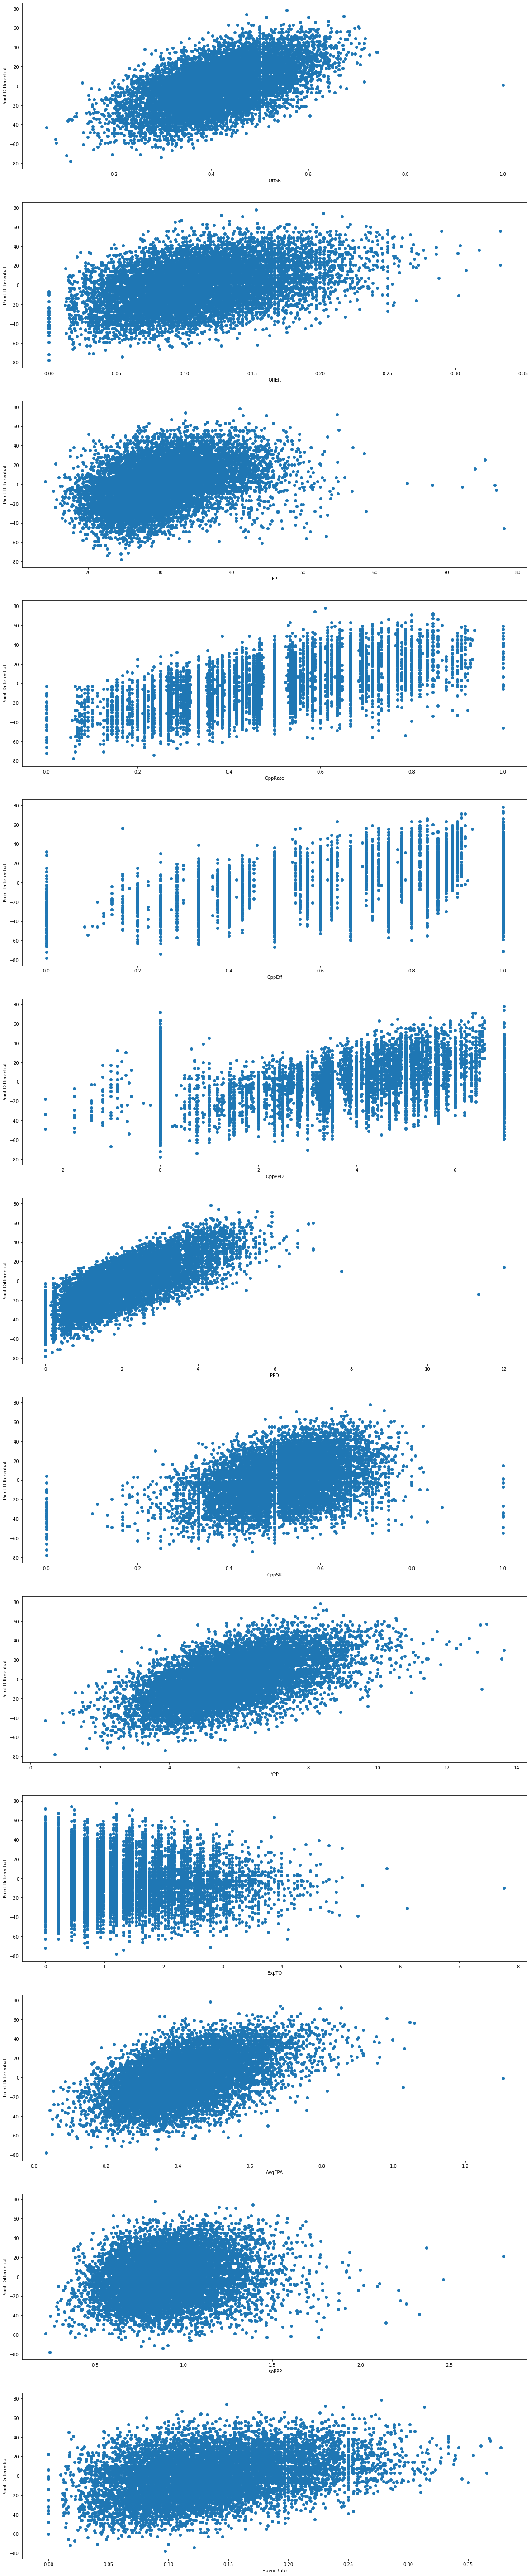

In [189]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[inpt], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [190]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0.122680,0.04152,0.006633,5.269858,1.039716,1.081095,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,-0.122680,-0.04152,-0.006633,4.230142,-1.039716,1.081095,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0.017305,-0.42232,0.042920,4.708140,-0.083720,0.087052,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,-0.017305,0.42232,-0.042920,4.791860,0.083720,0.087052,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0.087917,0.26167,0.059391,4.320653,-0.858694,0.892868,0.499553


In [191]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [192]:
# outliers

In [193]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,-0.122680,-0.04152,-0.006633,4.230142,-1.039716,1.081095,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0.017305,-0.42232,0.042920,4.708140,-0.083720,0.087052,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,-0.017305,0.42232,-0.042920,4.791860,0.083720,0.087052,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0.087917,0.26167,0.059391,4.320653,-0.858694,0.892868,0.499553
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,-0.084175,0.172264,0.00,-0.087917,-0.26167,-0.059391,5.179347,0.858694,0.892868,0.499553


In [194]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [195]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 20.70311x + -0.00620
Mean Pred Score: 0.6749798131728656
Pred Std Dev: 19.16813246598933
MAPE: 242.3008031058793%
Mean Abs Error: 7.204206915603556
Mdn Abs Error: 5.707659013135979
R-squared: 0.8125296769929743



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.754111,0.564060,0.491796,0.797539,0.590925,0.576859,0.982933,0.479003,0.771905,-0.457391,0.706897,0.254748,0.519274,0.900346,0.900346,0.900346
OffSRDiff,0.754111,1.000000,0.460962,0.286568,0.674184,0.391581,0.415505,0.750162,0.720527,0.706477,-0.300680,0.618826,-0.048590,0.523391,0.840976,0.840976,0.840976
OffERDiff,0.564060,0.460962,1.000000,0.132674,0.495064,0.302934,0.317417,0.555019,0.310761,0.801797,-0.206174,0.745517,0.584378,0.203135,0.536559,0.536559,0.536559
FPDiff,0.491796,0.286568,0.132674,1.000000,0.608785,0.095687,0.074038,0.466178,0.019838,0.218693,-0.280316,0.207159,0.007921,0.247992,0.623600,0.623600,0.623600
OppRateDiff,0.797539,0.674184,0.495064,0.608785,1.000000,0.195581,0.179481,0.792118,0.217017,0.659310,-0.317114,0.572424,0.151228,0.490533,0.909393,0.909393,0.909393
OppEffDiff,0.590925,0.391581,0.302934,0.095687,0.195581,1.000000,0.739370,0.594390,0.500104,0.432787,-0.294590,0.404787,0.193084,0.300650,0.431303,0.431303,0.431303
OppPPDDiff,0.576859,0.415505,0.317417,0.074038,0.179481,0.739370,1.000000,0.592482,0.525669,0.456178,-0.311465,0.421399,0.196145,0.308876,0.480808,0.480808,0.480808
PPDDiff,0.982933,0.750162,0.555019,0.466178,0.792118,0.594390,0.592482,1.000000,0.482473,0.759689,-0.448867,0.693622,0.244725,0.524976,0.894662,0.894662,0.894662
OppSRDiff,0.479003,0.720527,0.310761,0.019838,0.217017,0.500104,0.525669,0.482473,1.000000,0.494558,-0.231541,0.451672,-0.013374,0.328174,0.518110,0.518110,0.518110
YPPDiff,0.771905,0.706477,0.801797,0.218693,0.659310,0.432787,0.456178,0.759689,0.494558,1.000000,-0.322219,0.900517,0.542928,0.433333,0.751421,0.751421,0.751421


In [196]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [197]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by 0.0 (exact value: 0.40275928309248055)
Z score: -0.014201724167098449
Win Prob for Virginia Tech: 49.43%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,1.791667,-0.052381,0.118588,0.994779,-0.66,0.103211,0.124959,-0.040309,4.740123,-0.019753
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.103211,-0.124959,0.040309,4.759877,0.019753


In [198]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -18.0 (exact value: -17.845380246926922)
Z score: -0.9662057632876385
Win Prob for Georgia Tech: 16.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,1.166667,1.361111,0.07619,-0.330005,-0.66,-0.014422,-0.121075,0.018689,4.319167,-0.861667
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-1.166667,-1.361111,-0.07619,0.330005,0.66,0.014422,0.121075,-0.018689,5.180833,0.861667


In [199]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by 3.0 (exact value: 3.0222663741183355)
Z score: 0.12245775977969374
Win Prob for Georgia Tech: 54.87%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,0.5,0.054545,-0.01919,-1.322588,0.0,-0.06305,-0.300725,0.012719,4.67686,-0.146281
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,-0.5,-0.054545,0.01919,1.322588,0.0,0.06305,0.300725,-0.012719,4.82314,0.146281


In [200]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by -0.0 (exact value: -0.052981573611685)
Z score: -0.03797768969283769
Win Prob for Mississippi State: 48.49%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-1.05,0.068182,-0.059649,0.080622,0.22,0.020976,0.092249,0.000243,4.75113,0.00226
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,1.05,-0.068182,0.059649,-0.080622,-0.22,-0.020976,-0.092249,-0.000243,4.74887,-0.00226


In [201]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3.0 (exact value: -2.683255461496732)
Z score: -0.1751988766056489
Win Prob for Texas A&M: 43.05%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.166667,0.340557,0.014666,0.876496,0.0,-0.103285,-0.349878,0.001282,4.814654,0.129307
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.166667,-0.340557,-0.014666,-0.876496,0.0,0.103285,0.349878,-0.001282,4.685346,-0.129307


In [202]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.945575,13,12.0,1.0
2,Clemson,0.944132,13,12.0,1.0
3,Alabama,0.917134,12,11.0,1.0
4,LSU,0.902168,13,12.0,1.0
5,Utah,0.866538,13,11.0,2.0
6,Wisconsin,0.860942,13,11.0,2.0
7,Oregon,0.834415,13,11.0,2.0
8,Georgia,0.822709,13,11.0,2.0
9,Oklahoma,0.819602,13,11.0,2.0
10,Notre Dame,0.803994,12,10.0,2.0


In [203]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.694779,1.305221
21,Clemson,10.791217,2.208783
53,LSU,10.239165,2.760835
128,Wisconsin,9.382421,3.617579
2,Alabama,9.347957,2.652043
115,Utah,9.333205,3.666795
78,Oklahoma,9.100107,3.899893
82,Oregon,8.871850,4.128150
34,Georgia,8.852127,4.147873
75,Notre Dame,8.701376,3.298624


In [204]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].median()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].median()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.08741634513367758, -25.333070711442122]

In [205]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Georgia,Baylor,7.5,4.369778,0.576426,False,Georgia,Baylor
0,LSU,Oklahoma,11.0,1.386737,0.514810,False,LSU,Oklahoma
0,Florida,Virginia,14.0,0.803893,0.502683,False,Florida,Virginia
0,Clemson,Ohio State,2.5,-0.186127,0.482084,False,Ohio State,Ohio State
0,Penn State,Memphis,7.0,-1.092550,0.463265,False,Memphis,Memphis
0,Wisconsin,Oregon,2.5,-1.324057,0.458470,False,Oregon,Oregon


In [206]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by -1.0 (exact value: -1.2502461504076743)
Z score: -0.1004388907994315
Win Prob for Virginia: 46.00%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.571429,-1.0,0.073684,-2.332187,0.66,-0.135068,-0.403644,-0.089435,4.780045,0.06009
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.571429,1.0,-0.073684,2.332187,-0.66,0.135068,0.403644,0.089435,4.719955,-0.06009


In [207]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10.0 (exact value: 10.497962365378388)
Z score: 0.5124642460414323
Win Prob for North Carolina: 69.58%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,0.178571,1.230769,-0.123887,-0.349659,0.0,-0.01403,-0.235394,0.079888,5.003686,0.507371
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,-0.178571,-1.230769,0.123887,0.349659,0.0,0.01403,0.235394,-0.079888,4.496314,-0.507371


In [208]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 17.0 (exact value: 17.28875606056078)
Z score: 0.8667394320686328
Win Prob for Pittsburgh: 80.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.833333,0.659341,0.20743,1.49512,0.0,0.130501,-0.248736,0.038746,5.16769,0.835379
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.833333,-0.659341,-0.20743,-1.49512,0.0,-0.130501,0.248736,-0.038746,4.33231,-0.835379


In [209]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -10.08557290269022)
Z score: -0.5613772095406739
Win Prob for Auburn: 28.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.063492,-0.538462,0.114729,1.117419,0.44,0.063274,-0.083465,-0.033763,4.993427,0.486853
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.063492,0.538462,-0.114729,-1.117419,-0.44,-0.063274,0.083465,0.033763,4.506573,-0.486853


In [210]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 37.0 (exact value: 37.45705534585103)
Z score: 1.9189180582898127
Win Prob for Georgia: 97.25%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,2.666667,3.276786,-0.047059,4.45067,0.0,0.330151,0.455922,0.020115,5.654773,1.809547
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-2.666667,-3.276786,0.047059,-4.45067,0.0,-0.330151,-0.455922,-0.020115,3.845227,-1.809547


In [211]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 24.0 (exact value: 24.17723342018778)
Z score: 1.2261107673747436
Win Prob for Clemson: 88.99%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 8.0 (exact value: 8.49987852280342)
Z score: 0.40822436528517003
Win Prob for Georgia Tech: 65.84%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -10.0 (exact value: -10.187572321710896)
Z score: -0.5666985114046743
Win Prob for The Citadel: 28.55%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 17.0 (exact value: 16.95396102261922)
Z score: 0.8492732006276932
Win Prob for Temple: 80.21%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10.0 (exact value: 10.497962365378388)
Z score: 0.51246424604143

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,11.007850
5900,401112441,2019,Georgia Tech,South Florida,4.0,65.844552
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,71.454048
6107,401112469,2019,Georgia Tech,Temple,-22.0,19.786464
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,30.416307
6198,401112480,2019,Georgia Tech,Duke,-18.0,28.943692
6251,401112488,2019,Georgia Tech,Miami,7.0,16.697061
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,19.304240
6418,401112504,2019,Georgia Tech,Virginia,-5.0,19.199119
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.061306


In [212]:
retrieve_win_probs("Ohio State", 2019)

Game: Florida Atlantic @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 24.0
Proj MOV: Ohio State by 24.0 (exact value: 23.928312592545126)
Z score: 1.2131245868960598
Win Prob for Ohio State: 88.75%
---
Game: Cincinnati @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 42.0
Proj MOV: Ohio State by 40.0 (exact value: 39.97569157202439)
Z score: 2.0503151169569653
Win Prob for Ohio State: 97.98%
---
Game: Ohio State @ Indiana
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 36.0 (exact value: 36.33883867678089)
Z score: 1.8605807804640133
Win Prob for Ohio State: 96.86%
---
Game: Miami (OH) @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 71.0
Proj MOV: Ohio State by 66.0 (exact value: 65.99918233213778)
Z score: 3.4079586331569787
Win Prob for Ohio State: 99.97%
---
Game: Ohio State @ Nebraska
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 39.0 (exact value: 39.34061821783333)
Z score: 2.017183388797329
Win P

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5821,401112251,2019,Ohio State,Florida Atlantic,24.0,88.745890
5887,401112252,2019,Ohio State,Cincinnati,42.0,97.983315
5965,401112159,2019,Ohio State,Indiana,41.0,96.859830
6043,401112253,2019,Ohio State,Miami (OH),71.0,99.967275
6125,401112241,2019,Ohio State,Nebraska,41.0,97.816181
6173,401112216,2019,Ohio State,Michigan State,24.0,84.870170
6241,401112248,2019,Ohio State,Northwestern,49.0,97.913645
6307,401112254,2019,Ohio State,Wisconsin,31.0,87.273819
6413,401112209,2019,Ohio State,Maryland,59.0,99.069021
6481,401112255,2019,Ohio State,Rutgers,35.0,95.760660


In [213]:
retrieve_win_probs("Georgia Tech", 2018)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 51.0 (exact value: 51.40977759228704)
Z score: 2.646830507308662
Win Prob for Georgia Tech: 99.59%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 9.0 (exact value: 8.93497909611232)
Z score: 0.43092352880988544
Win Prob for South Florida: 66.67%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 4.0 (exact value: 4.464350152498598)
Z score: 0.197691159848219
Win Prob for Pittsburgh: 57.84%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 27.0 (exact value: 27.130067244362785)
Z score: 1.380159881414117
Win Prob for Clemson: 91.62%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 36.0 (exact value: 35.932813951749)
Z score: 1.8

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
4986,401013090,2018,Georgia Tech,Alcorn State,41.0,99.593750
5048,401013100,2018,Georgia Tech,South Florida,-11.0,33.326199
5135,401013112,2018,Georgia Tech,Pittsburgh,-5.0,42.164335
5206,401013120,2018,Georgia Tech,Clemson,-28.0,8.376871
5249,401013134,2018,Georgia Tech,Bowling Green,46.0,96.707170
5304,401013138,2018,Georgia Tech,Louisville,35.0,96.990206
5373,401013145,2018,Georgia Tech,Duke,-14.0,18.010690
5473,401013153,2018,Georgia Tech,Virginia Tech,21.0,80.496590
5545,401013165,2018,Georgia Tech,North Carolina,10.0,83.814441
5636,401013172,2018,Georgia Tech,Miami,6.0,57.249115


In [214]:
retrieve_win_probs("Clemson", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 24.0 (exact value: 24.17723342018778)
Z score: 1.2261107673747436
Win Prob for Clemson: 88.99%
---
Game: Texas A&M @ Clemson
Actual Winner: Clemson
MOV: Clemson by 14.0
Proj MOV: Clemson by 11.0 (exact value: 10.868068922969131)
Z score: 0.5317726767530541
Win Prob for Clemson: 70.26%
---
Game: Clemson @ Syracuse
Actual Winner: Clemson
MOV: Clemson by 35.0
Proj MOV: Clemson by 28.0 (exact value: 28.050743971880113)
Z score: 1.428191515646138
Win Prob for Clemson: 92.34%
---
Game: Charlotte @ Clemson
Actual Winner: Clemson
MOV: Clemson by 42.0
Proj MOV: Clemson by 51.0 (exact value: 51.42773670864903)
Z score: 2.647767433031283
Win Prob for Clemson: 99.59%
---
Game: Clemson @ North Carolina
Actual Winner: Clemson
MOV: Clemson by 1.0
Proj MOV: Clemson by 3.0 (exact value: 2.60339211927393)
Z score: 0.10060512204424256
Win Prob for Clemson: 54.01%
---
Game: Florida State @ Clemson
Actual Winner: 

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Clemson,Georgia Tech,38.0,88.992150
5905,401110784,2019,Clemson,Texas A&M,14.0,70.255828
6008,401112449,2019,Clemson,Syracuse,35.0,92.338163
6067,401112456,2019,Clemson,Charlotte,42.0,99.594874
6103,401112467,2019,Clemson,North Carolina,1.0,54.006803
6204,401112479,2019,Clemson,Florida State,31.0,91.353421
6250,401112485,2019,Clemson,Louisville,35.0,95.014958
6344,401112490,2019,Clemson,Boston College,52.0,96.107269
6381,401112496,2019,Clemson,Wofford,45.0,99.150430
6445,401112503,2019,Clemson,NC State,45.0,96.570855


In [215]:
retrieve_win_probs("Georgia Tech", 2016)

Game: Georgia Tech @ Boston College
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.413317154064737)
Z score: -0.3697959089032074
Win Prob for Georgia Tech: 35.58%
---
Game: Mercer @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 25.0
Proj MOV: Georgia Tech by 29.0 (exact value: 28.75592142137358)
Z score: 1.4649805690786875
Win Prob for Georgia Tech: 92.85%
---
Game: Vanderbilt @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 31.0
Proj MOV: Georgia Tech by 30.0 (exact value: 29.745124103576355)
Z score: 1.516587197108724
Win Prob for Georgia Tech: 93.53%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 19.0
Proj MOV: Clemson by 23.0 (exact value: 23.236247405553055)
Z score: 1.1770195991921182
Win Prob for Clemson: 88.04%
---
Game: Miami @ Georgia Tech
Actual Winner: Miami
MOV: Miami by 14.0
Proj MOV: Miami by 4.0 (exact value: 4.207718080759888)
Z score: 0.1843026843567197
Win Pr

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
3312,400869424,2016,Georgia Tech,Boston College,3.0,35.576728
3393,400869433,2016,Georgia Tech,Mercer,25.0,92.853689
3462,400869001,2016,Georgia Tech,Vanderbilt,31.0,93.531453
3513,400869446,2016,Georgia Tech,Clemson,-19.0,11.959384
3576,400869721,2016,Georgia Tech,Miami,-14.0,42.688800
3650,400869458,2016,Georgia Tech,Pittsburgh,-3.0,44.583895
3702,400869464,2016,Georgia Tech,Georgia Southern,11.0,78.009760
3807,400869474,2016,Georgia Tech,Duke,3.0,29.643408
3874,400869480,2016,Georgia Tech,North Carolina,-28.0,25.374575
3946,400869486,2016,Georgia Tech,Virginia Tech,10.0,36.214137


In [216]:
retrieve_win_probs("Alabama", 2012)

Game: Michigan @ Alabama
Actual Winner: Alabama
MOV: Alabama by 27.0
Proj MOV: Alabama by 39.0 (exact value: 38.79367457921023)
Z score: 1.9886493811367727
Win Prob for Alabama: 97.66%
---
Game: Western Kentucky @ Alabama
Actual Winner: Alabama
MOV: Alabama by 35.0
Proj MOV: Alabama by 31.0 (exact value: 30.79361172794488)
Z score: 1.5712867160226762
Win Prob for Alabama: 94.19%
---
Game: Alabama @ Arkansas
Actual Winner: Alabama
MOV: Alabama by 52.0
Proj MOV: Alabama by 33.0 (exact value: 33.29055756833542)
Z score: 1.7015521889278198
Win Prob for Alabama: 95.56%
---
Game: Florida Atlantic @ Alabama
Actual Winner: Alabama
MOV: Alabama by 33.0
Proj MOV: Alabama by 50.0 (exact value: 50.043519877467986)
Z score: 2.5755529471580707
Win Prob for Alabama: 99.50%
---
Game: Ole Miss @ Alabama
Actual Winner: Alabama
MOV: Alabama by 19.0
Proj MOV: Alabama by 19.0 (exact value: 19.093387075060157)
Z score: 0.9608868936276238
Win Prob for Alabama: 83.17%
---
Game: Alabama @ Missouri
Actual Winne

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
67,322450333,2012,Alabama,Michigan,27.0,97.663004
100,322520333,2012,Alabama,Western Kentucky,35.0,94.194197
167,322590008,2012,Alabama,Arkansas,52.0,95.558033
246,322660333,2012,Alabama,Florida Atlantic,33.0,99.499600
326,322730333,2012,Alabama,Ole Miss,19.0,83.169548
414,322870142,2012,Alabama,Missouri,32.0,88.972219
478,322942633,2012,Alabama,Tennessee,31.0,83.021098
551,323010333,2012,Alabama,Mississippi State,31.0,89.545915
606,323080099,2012,Alabama,LSU,4.0,58.601929
638,323150333,2012,Alabama,Texas A&M,-5.0,52.810605


In [217]:
predict_matchup("Georgia Tech","Georgia", 2015)
# calculate_box_score(400547779, 2014)

[0.3320008261477149, -7.651560447569389]

In [218]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 51.0 (exact value: 51.0679251489938)
Z score: 2.6289960915720325
Win Prob for Georgia Tech: 99.57%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 46.0 (exact value: 46.1360257311681)
Z score: 2.3716992773635255
Win Prob for Georgia Tech: 99.11%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 11.0 (exact value: 11.01602087090107)
Z score: 0.5394913185244657
Win Prob for Notre Dame: 70.52%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 15.0 (exact value: 14.513514864798095)
Z score: 0.7219553118270344
Win Prob for Duke: 76.48%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 8.0 (exact value: 7.60292839099058)
Z score: 0.36143054573053524


,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2460,400756895,2015,Georgia Tech,Alcorn State,63.0,99.571813
2567,400756910,2015,Georgia Tech,Tulane,55.0,99.114675
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,29.477394
2688,400756933,2015,Georgia Tech,Duke,-14.0,23.516098
2775,400756942,2015,Georgia Tech,North Carolina,-7.0,35.888881
2827,400756948,2015,Georgia Tech,Clemson,-19.0,13.285701
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,26.176038
2965,400756962,2015,Georgia Tech,Florida State,6.0,19.755314
2997,400756972,2015,Georgia Tech,Virginia,-6.0,24.028909
3090,400756979,2015,Georgia Tech,Virginia Tech,-2.0,29.036175


In [219]:
predict_matchup("Georgia Tech","Florida State",2015)

[0.20419572894391275, -15.171844884988179]

In [220]:
predict_matchup("Army","Navy", 2019)

[0.3694785545316556, -5.712507507052233]

In [221]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 51.0 (exact value: 51.0679251489938)
Z score: 2.6289960915720325
Win Prob for Georgia Tech: 99.57%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 46.0 (exact value: 46.1360257311681)
Z score: 2.3716992773635255
Win Prob for Georgia Tech: 99.11%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 11.0 (exact value: 11.01602087090107)
Z score: 0.5394913185244657
Win Prob for Notre Dame: 70.52%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 15.0 (exact value: 14.513514864798095)
Z score: 0.7219553118270344
Win Prob for Duke: 76.48%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 8.0 (exact value: 7.60292839099058)
Z score: 0.36143054573053524


,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2460,400756895,2015,Georgia Tech,Alcorn State,63.0,99.571813
2567,400756910,2015,Georgia Tech,Tulane,55.0,99.114675
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,29.477394
2688,400756933,2015,Georgia Tech,Duke,-14.0,23.516098
2775,400756942,2015,Georgia Tech,North Carolina,-7.0,35.888881
2827,400756948,2015,Georgia Tech,Clemson,-19.0,13.285701
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,26.176038
2965,400756962,2015,Georgia Tech,Florida State,6.0,19.755314
2997,400756972,2015,Georgia Tech,Virginia,-6.0,24.028909
3090,400756979,2015,Georgia Tech,Virginia Tech,-2.0,29.036175


In [222]:
retrieve_win_probs("Georgia Tech", 2013)

Game: Elon @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 70.0
Proj MOV: Georgia Tech by 34.0 (exact value: 34.05098176108978)
Z score: 1.7412234607172654
Win Prob for Georgia Tech: 95.92%
---
Game: Georgia Tech @ Duke
Actual Winner: Georgia Tech
MOV: Georgia Tech by 24.0
Proj MOV: Georgia Tech by 23.0 (exact value: 22.860483015435673)
Z score: 1.1574159997917013
Win Prob for Georgia Tech: 87.64%
---
Game: North Carolina @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 8.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.8115508832713428)
Z score: -0.07755219237355597
Win Prob for Georgia Tech: 46.91%
---
Game: Virginia Tech @ Georgia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 7.0
Proj MOV: Virginia Tech by 6.0 (exact value: 5.641395969021873)
Z score: 0.25909754978274946
Win Prob for Virginia Tech: 60.22%
---
Game: Georgia Tech @ Miami
Actual Winner: Miami
MOV: Miami by 15.0
Proj MOV: Miami by 12.0 (exact value: 11.51565389338666)
Z score: 0

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
831,332430059,2013,Georgia Tech,Elon,70.0,95.917779
982,332570150,2013,Georgia Tech,Duke,24.0,87.644878
1025,332640059,2013,Georgia Tech,North Carolina,8.0,46.909214
1077,332690059,2013,Georgia Tech,Virginia Tech,-7.0,39.777999
1156,332782390,2013,Georgia Tech,Miami,-15.0,28.584744
1220,332850252,2013,Georgia Tech,BYU,-18.0,32.923785
1246,332920059,2013,Georgia Tech,Syracuse,56.0,98.470361
1294,332990258,2013,Georgia Tech,Virginia,10.0,54.145024
1378,333060059,2013,Georgia Tech,Pittsburgh,11.0,72.150949
1445,333180228,2013,Georgia Tech,Clemson,-24.0,5.919872


In [223]:
predict_matchup("Georgia Tech","Syracuse",2013)

[0.5018711752683451, 0.7648852172416907]

In [224]:
generate_win_prob(401013177,2018)

Game: Virginia @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -4.0 (exact value: -4.153079069265881)
Z score: -0.2518794614449444
Win Prob for Georgia Tech: 40.06%
---


0.40056711763262803

In [225]:
predict_matchup("Georgia Tech","Georgia",2016)

[0.38579893356127987, -4.889250194306553]

In [226]:
predict_matchup("Georgia Tech","Georgia",2015)

[0.3320008261477149, -7.651560447569389]